# Pacotes de Instalação

In [29]:
#Utilizar caso seja necessário
#!pip install Office365-REST-Python-Client 
!pip install python-dotenv
!pip install scikit-learn
!pip install xgboost

In [1]:
from office365.runtime.auth.authentication_context import AuthenticationContext
from office365.sharepoint.client_context import ClientContext
from io import BytesIO
import pandas as pd
import os
from dotenv import load_dotenv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


In [3]:
# Carrega as variáveis do arquivo .env
load_dotenv()

username = os.getenv("SHAREPOINT_USERNAME")
password = os.getenv("SHAREPOINT_PASSWORD")

# Caminho do site e da planilha
site_url = "https://alunosunicesumaredubr.sharepoint.com/sites/TesteJupyter"
file_relative_url = "/sites/TesteJupyter/Documentos%20Compartilhados/Testes/base_ficticia_credito_com_identificacao.xlsx"

# Autenticação e leitura do arquivo
ctx_auth = AuthenticationContext(site_url)
if ctx_auth.acquire_token_for_user(username, password):
    ctx = ClientContext(site_url, ctx_auth)

    file_buffer = BytesIO()
    ctx.web.get_file_by_server_relative_url(file_relative_url).download(file_buffer)
    ctx.execute_query()

    file_buffer.seek(0)
    df = pd.read_excel(file_buffer)

    print("✅ Planilha carregada com sucesso!")
    print(df.head())
else:
    print("❌ Erro na autenticação. Verifique seu e-mail e senha.")

✅ Planilha carregada com sucesso!
                   nome             cpf  idade  renda_mensal  \
0    Dr. Danilo Costela  614.592.730-52     56       1787.11   
1           Lara Novaes  375.620.184-80     69       5406.93   
2       Catarina Duarte  048.763.921-96     46       3487.30   
3   Maria Vitória Gomes  609.431.825-06     32       2155.49   
4  Srta. Bárbara Fogaça  012.398.645-15     60       3706.85   

   tempo_emprego_anos  score_credito  possui_divida_ativa  quantidade_cartoes  \
0                10.2            719                    0                   3   
1                 3.8            925                    0                   0   
2                 5.7            551                    0                   3   
3                 7.8            918                    0                   0   
4                 0.7            848                    0                   0   

   valor_total_dividas  utilizacao_limite_cartao  \
0              7466.58                    

In [4]:
#Verifica como está as strings para o tratamento das informações
print(df['status_credito'].unique())

['RECUSADO' 'APROVADO']


In [7]:
#Transforma a target que usarei para teste e treinamento para 0 e 1

df['status_credito'] = np.where(df['status_credito'] == 'RECUSADO', 0, 1)

In [10]:
df

nome             cpf  idade  renda_mensal  \
0      Dr. Danilo Costela  614.592.730-52     56       1787.11   
1             Lara Novaes  375.620.184-80     69       5406.93   
2         Catarina Duarte  048.763.921-96     46       3487.30   
3     Maria Vitória Gomes  609.431.825-06     32       2155.49   
4    Srta. Bárbara Fogaça  012.398.645-15     60       3706.85   
..                    ...             ...    ...           ...   
995       Raquel Silveira  703.426.189-03     60       5839.06   
996         Brenda Campos  235.940.768-65     64       3225.02   
997          Elisa Aragão  958.306.172-77     62       4125.08   
998            Erick Melo  437.850.216-07     35       6444.76   
999    Letícia Nascimento  760.429.315-80     55       4254.33   

     tempo_emprego_anos  score_credito  possui_divida_ativa  \
0                  10.2            719                    0   
1                   3.8            925                    0   
2                   5.7            551                    0   
3                   7.8            918                    0   
4                   0.7            848                    0   
..                  ...            ...                  ...   
995                 9.4            649                    0   
996                 1.0            933                    0   
997                 7.1            793                    0   
998                 3.2            919                    1   
999                10.2            303                    0   

     quantidade_cartoes  valor_total_dividas  utilizacao_limite_cartao  \
0                     3              7466.58                      0.40   
1                     0               502.78                      0.30   
2                     3               466.66                      0.68   
3                     0              2802.57                      0.21   
4                     0               584.40                      0.80   
..                  ...                  ...                       ...   
995                   1              4171.12                      0.17   
996                   4              2791.44                      0.58   
997                   0                35.61                      0.56   
998                   1              1455.50                      0.74   
999                   2              1508.23                      0.50   

     movimentacao_media_mensal_credito  movimentacao_media_mensal_debito  \
0                              2228.23                           3177.13   
1                              2468.41                           2907.31   
2                              4457.49                           2605.36   
3                              3804.11                           4076.11   
4                              4606.43                           4194.34   
..                                 ...                               ...   
995                            2200.25                           2562.34   
996                            2754.09                           2562.48   
997                            4516.14                           3922.81   
998                            1439.44                           2800.44   
999                            4380.71                           2055.17   

        tipo_conta  status_credito  
0         corrente               0  
1          salario               1  
2    universitaria               0  
3         corrente               0  
4    universitaria               0  
..             ...             ...  
995       corrente               1  
996       corrente               1  
997       corrente               1  
998       corrente               0  
999  universitaria               0  

[1000 rows x 14 columns]

In [9]:
credito = df.drop(columns=['nome', 'cpf'])

In [11]:
credito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   idade                              1000 non-null   int64  
 1   renda_mensal                       1000 non-null   float64
 2   tempo_emprego_anos                 1000 non-null   float64
 3   score_credito                      1000 non-null   int64  
 4   possui_divida_ativa                1000 non-null   int64  
 5   quantidade_cartoes                 1000 non-null   int64  
 6   valor_total_dividas                1000 non-null   float64
 7   utilizacao_limite_cartao           1000 non-null   float64
 8   movimentacao_media_mensal_credito  1000 non-null   float64
 9   movimentacao_media_mensal_debito   1000 non-null   float64
 10  tipo_conta                         1000 non-null   object 
 11  status_credito                     1000 non-null   int32 

In [13]:
credito

idade  renda_mensal  tempo_emprego_anos  score_credito  \
0       56       1787.11                10.2            719   
1       69       5406.93                 3.8            925   
2       46       3487.30                 5.7            551   
3       32       2155.49                 7.8            918   
4       60       3706.85                 0.7            848   
..     ...           ...                 ...            ...   
995     60       5839.06                 9.4            649   
996     64       3225.02                 1.0            933   
997     62       4125.08                 7.1            793   
998     35       6444.76                 3.2            919   
999     55       4254.33                10.2            303   

     possui_divida_ativa  quantidade_cartoes  valor_total_dividas  \
0                      0                   3              7466.58   
1                      0                   0               502.78   
2                      0                   3               466.66   
3                      0                   0              2802.57   
4                      0                   0               584.40   
..                   ...                 ...                  ...   
995                    0                   1              4171.12   
996                    0                   4              2791.44   
997                    0                   0                35.61   
998                    1                   1              1455.50   
999                    0                   2              1508.23   

     utilizacao_limite_cartao  movimentacao_media_mensal_credito  \
0                        0.40                            2228.23   
1                        0.30                            2468.41   
2                        0.68                            4457.49   
3                        0.21                            3804.11   
4                        0.80                            4606.43   
..                        ...                                ...   
995                      0.17                            2200.25   
996                      0.58                            2754.09   
997                      0.56                            4516.14   
998                      0.74                            1439.44   
999                      0.50                            4380.71   

     movimentacao_media_mensal_debito     tipo_conta  status_credito  
0                             3177.13       corrente               0  
1                             2907.31        salario               1  
2                             2605.36  universitaria               0  
3                             4076.11       corrente               0  
4                             4194.34  universitaria               0  
..                                ...            ...             ...  
995                           2562.34       corrente               1  
996                           2562.48       corrente               1  
997                           3922.81       corrente               1  
998                           2800.44       corrente               0  
999                           2055.17  universitaria               0  

[1000 rows x 12 columns]

In [21]:
credito_dummies = pd.get_dummies(credito,
                                 columns = ['tipo_conta'],
                                 drop_first=True,
                                 dtype='int')
credito_dummies.info()
credito_dummies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   idade                              1000 non-null   int64  
 1   renda_mensal                       1000 non-null   float64
 2   tempo_emprego_anos                 1000 non-null   float64
 3   score_credito                      1000 non-null   int64  
 4   possui_divida_ativa                1000 non-null   int64  
 5   quantidade_cartoes                 1000 non-null   int64  
 6   valor_total_dividas                1000 non-null   float64
 7   utilizacao_limite_cartao           1000 non-null   float64
 8   movimentacao_media_mensal_credito  1000 non-null   float64
 9   movimentacao_media_mensal_debito   1000 non-null   float64
 10  status_credito                     1000 non-null   int32  
 11  tipo_conta_salario                 1000 non-null   int32 

idade  renda_mensal  tempo_emprego_anos  score_credito  \
0       56       1787.11                10.2            719   
1       69       5406.93                 3.8            925   
2       46       3487.30                 5.7            551   
3       32       2155.49                 7.8            918   
4       60       3706.85                 0.7            848   
..     ...           ...                 ...            ...   
995     60       5839.06                 9.4            649   
996     64       3225.02                 1.0            933   
997     62       4125.08                 7.1            793   
998     35       6444.76                 3.2            919   
999     55       4254.33                10.2            303   

     possui_divida_ativa  quantidade_cartoes  valor_total_dividas  \
0                      0                   3              7466.58   
1                      0                   0               502.78   
2                      0                   3               466.66   
3                      0                   0              2802.57   
4                      0                   0               584.40   
..                   ...                 ...                  ...   
995                    0                   1              4171.12   
996                    0                   4              2791.44   
997                    0                   0                35.61   
998                    1                   1              1455.50   
999                    0                   2              1508.23   

     utilizacao_limite_cartao  movimentacao_media_mensal_credito  \
0                        0.40                            2228.23   
1                        0.30                            2468.41   
2                        0.68                            4457.49   
3                        0.21                            3804.11   
4                        0.80                            4606.43   
..                        ...                                ...   
995                      0.17                            2200.25   
996                      0.58                            2754.09   
997                      0.56                            4516.14   
998                      0.74                            1439.44   
999                      0.50                            4380.71   

     movimentacao_media_mensal_debito  status_credito  tipo_conta_salario  \
0                             3177.13               0                   0   
1                             2907.31               1                   1   
2                             2605.36               0                   0   
3                             4076.11               0                   0   
4                             4194.34               0                   0   
..                                ...             ...                 ...   
995                           2562.34               1                   0   
996                           2562.48               1                   0   
997                           3922.81               1                   0   
998                           2800.44               0                   0   
999                           2055.17               0                   0   

     tipo_conta_universitaria  
0                           0  
1                           0  
2                           1  
3                           0  
4                           1  
..                        ...  
995                         0  
996                         0  
997                         0  
998                         0  
999                         1  

[1000 rows x 13 columns]

In [23]:
credito_dummies.describe()

idade  renda_mensal  tempo_emprego_anos  score_credito  \
count  1000.00000   1000.000000           1000.0000    1000.000000   
mean     43.81900   5115.149580              5.0614     652.942000   
std      14.99103   1976.432643              2.9438     201.097894   
min      18.00000   -792.510000             -4.1000     300.000000   
25%      31.00000   3776.325000              3.1000     485.750000   
50%      44.00000   5107.670000              5.0000     656.000000   
75%      56.00000   6370.937500              7.1000     825.000000   
max      69.00000  10264.760000             14.6000     999.000000   

       possui_divida_ativa  quantidade_cartoes  valor_total_dividas  \
count          1000.000000         1000.000000          1000.000000   
mean              0.196000            2.042000          1984.745700   
std               0.397167            1.416419          2038.966729   
min               0.000000            0.000000             1.260000   
25%               0.000000            1.000000           546.382500   
50%               0.000000            2.000000          1386.945000   
75%               0.000000            3.000000          2641.532500   
max               1.000000            4.000000         17599.700000   

       utilizacao_limite_cartao  movimentacao_media_mensal_credito  \
count               1000.000000                        1000.000000   
mean                   0.508590                        3005.788560   
std                    0.289229                         984.455586   
min                    0.000000                         220.290000   
25%                    0.270000                        2350.282500   
50%                    0.510000                        2984.530000   
75%                    0.760000                        3675.590000   
max                    1.000000                        5981.790000   

       movimentacao_media_mensal_debito  status_credito  tipo_conta_salario  \
count                       1000.000000     1000.000000         1000.000000   
mean                        2517.234760        0.274000            0.188000   
std                          832.203944        0.446232            0.390908   
min                         -227.170000        0.000000            0.000000   
25%                         1959.992500        0.000000            0.000000   
50%                         2515.420000        0.000000            0.000000   
75%                         3078.910000        1.000000            0.000000   
max                         5344.490000        1.000000            1.000000   

       tipo_conta_universitaria  
count               1000.000000  
mean                   0.099000  
std                    0.298811  
min                    0.000000  
25%                    0.000000  
50%                    0.000000  
75%                    0.000000  
max                    1.000000

In [25]:
dados = credito_dummies

In [27]:
X = dados.drop(columns = ['status_credito'])
y = dados['status_credito']

In [29]:
y

0      0
1      1
2      0
3      0
4      0
      ..
995    1
996    1
997    1
998    0
999    0
Name: status_credito, Length: 1000, dtype: int32

In [31]:
#escolhendo 70% das observações para treino e 30% para teste

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [33]:
#iniciando com arvore de pequena profundidade: profundidade maxima 2

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [35]:
#verificação da ordem para o utilizar o plot_tree

print(sorted(y.unique()))

[0, 1]


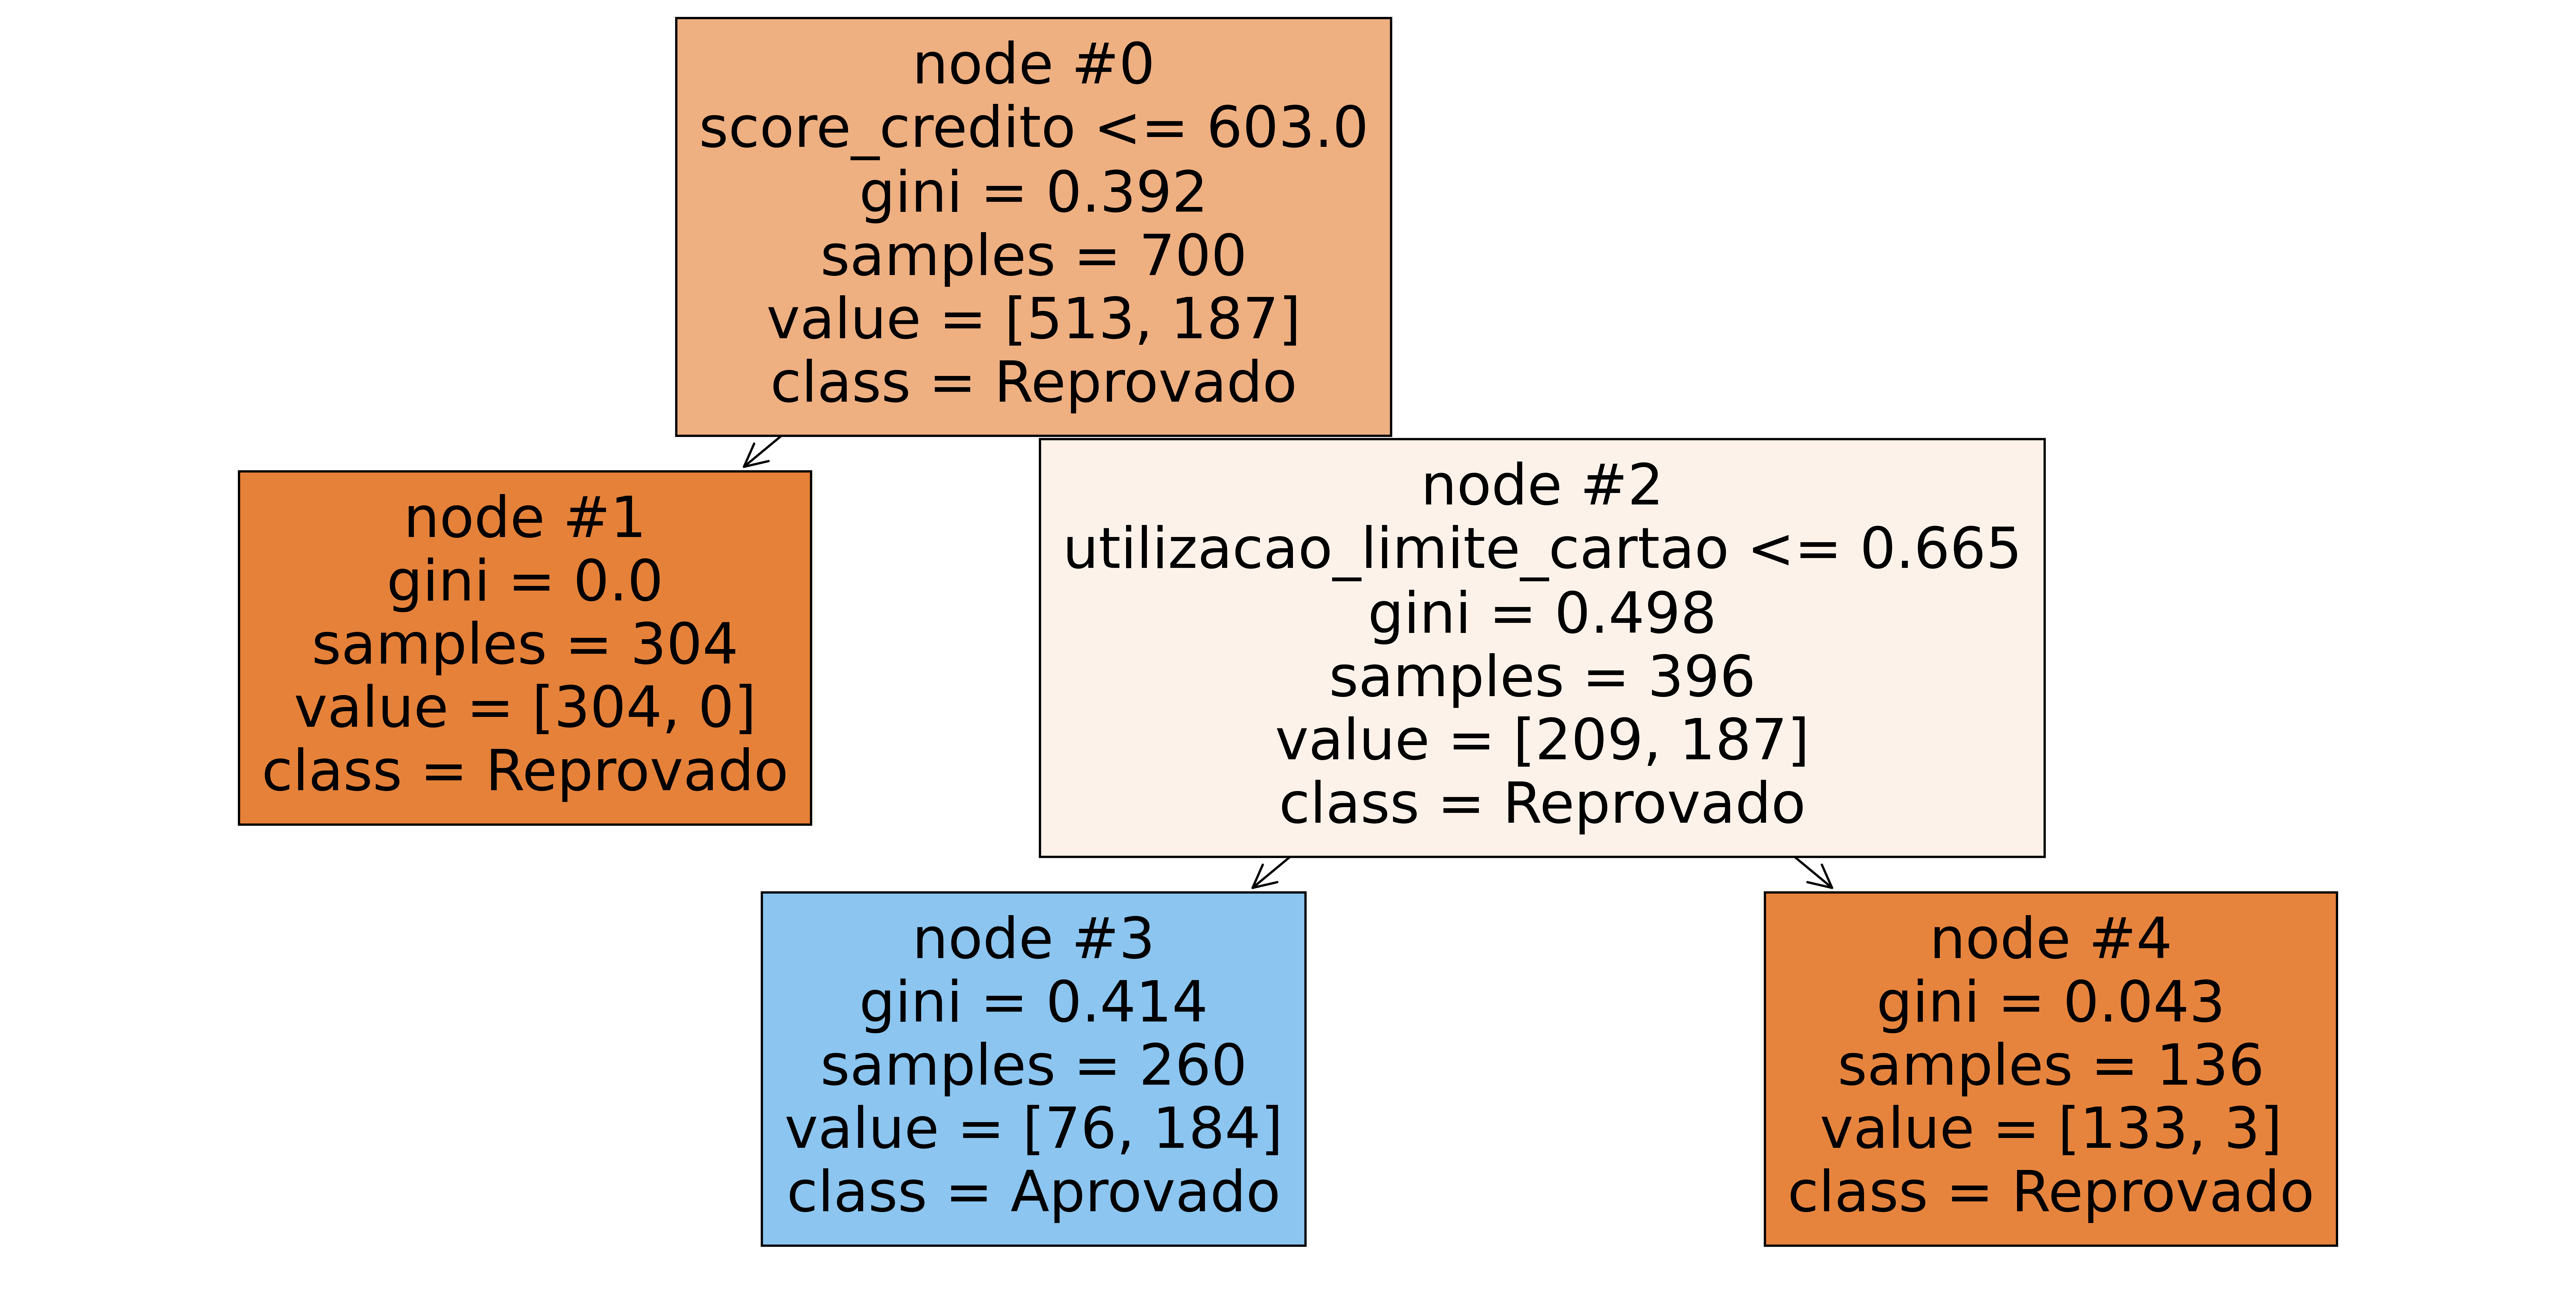

In [37]:
#Plotando a árvore

plt.figure(figsize=(20,10), dpi=600)
plot_tree(tree_clf,
          feature_names=X.columns.tolist(),
          class_names=['Reprovado','Aprovado'],
          proportion=False,
          filled=True,
          node_ids=True)
plt.show()

In [39]:
#Verificando se a muita disparidade entre aqueles aprovados e aqueles reprovados

print(df['status_credito'].value_counts(normalize=True))

status_credito
0    0.726
1    0.274
Name: proportion, dtype: float64


In [41]:
#Verificando variancia das targets

variancias = X.var().sort_values()
print(variancias)

utilizacao_limite_cartao             8.365317e-02
tipo_conta_universitaria             8.928829e-02
tipo_conta_salario                   1.528088e-01
possui_divida_ativa                  1.577417e-01
quantidade_cartoes                   2.006242e+00
tempo_emprego_anos                   8.665956e+00
idade                                2.247310e+02
score_credito                        4.044036e+04
movimentacao_media_mensal_debito     6.925634e+05
movimentacao_media_mensal_credito    9.691528e+05
renda_mensal                         3.906286e+06
valor_total_dividas                  4.157385e+06
dtype: float64


In [43]:
#vericando se há targuets com baixa variância

low_variance_cols = variancias[variancias < 0.01].index.tolist()
print("🔍 Variáveis com baixa variância:", low_variance_cols)

🔍 Variáveis com baixa variância: []


In [45]:
#tentando corrigir o desequilibrio entre classes Oversampling com SMOTE

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

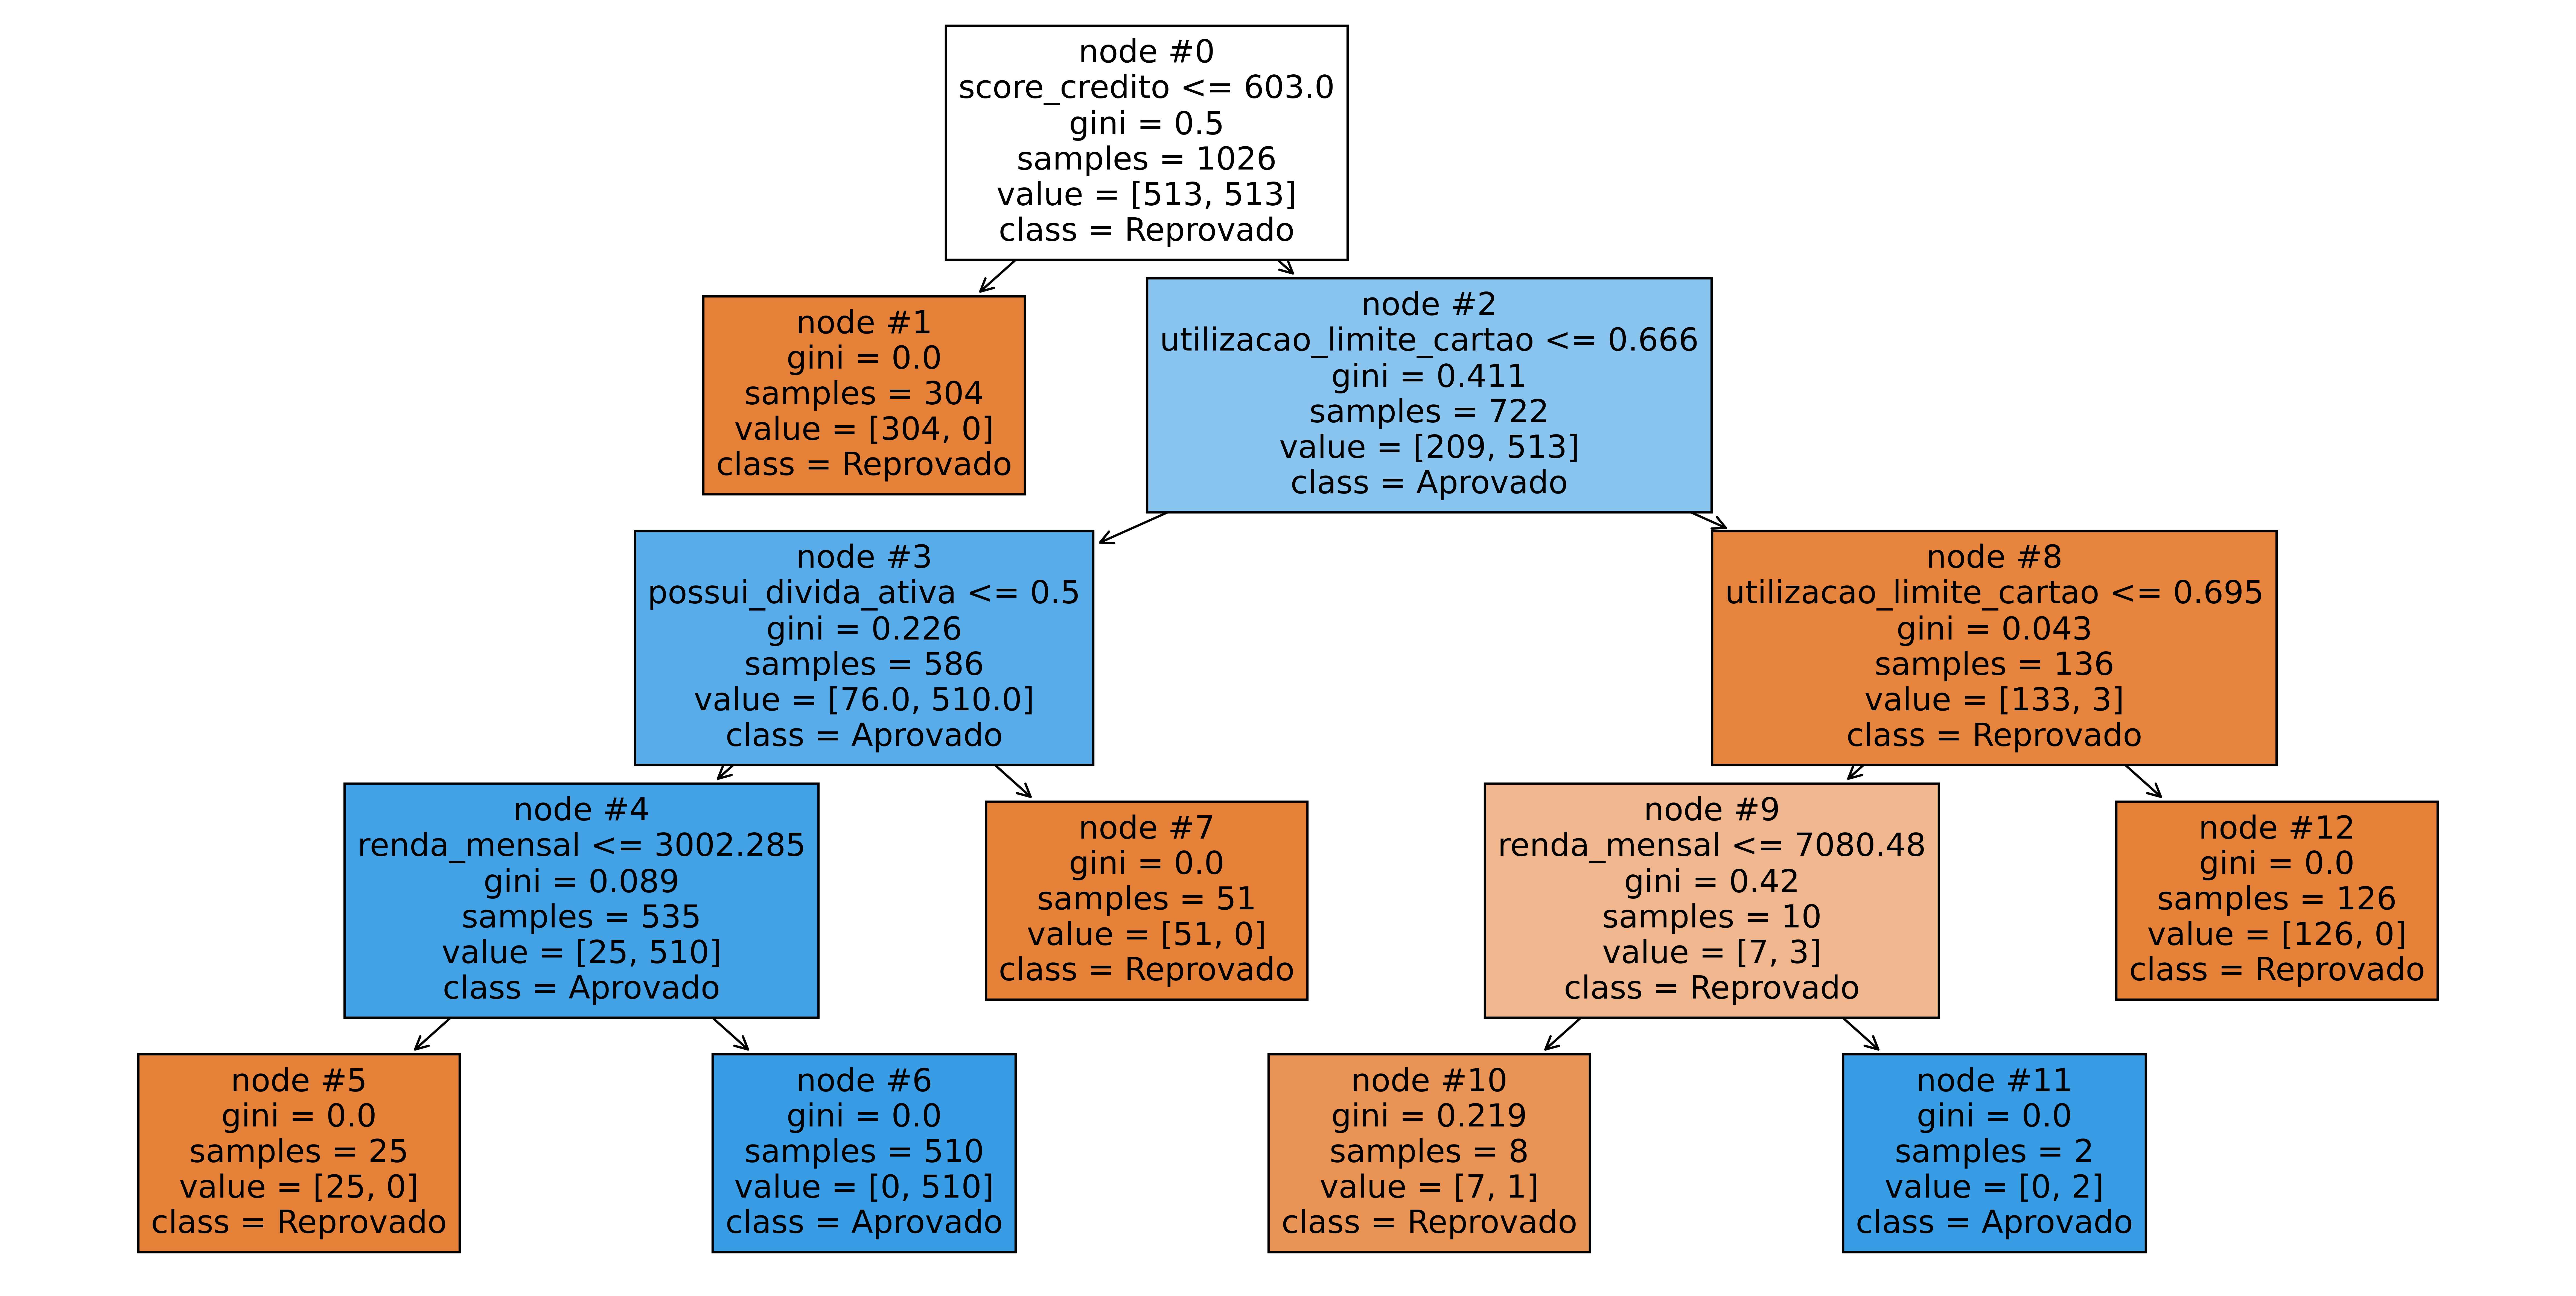

In [50]:
plt.figure(figsize=(20,10), dpi=600)
plot_tree(tree_clf,
          feature_names=X.columns.tolist(),
          class_names=['Reprovado','Aprovado'],
          proportion=False,
          filled=True,
          node_ids=True)
plt.show()

In [150]:
#Utilizar caso o DataSet seja muito grande

#from imblearn.under_sampling import RandomUnderSampler

#undersample = RandomUnderSampler(random_state=42)
#X_res, y_res = undersample.fit_resample(X_train, y_train)

#tree_clf = DecisionTreeClassifier(max_depth=10, random_state=42)
#tree_clf.fit(X_res, y_res)

In [47]:
#Analisando os resultados dos splits 

tree_split = pd.DataFrame(tree_clf.cost_complexity_pruning_path(X_train, y_train))
tree_split.sort_index(ascending=False, inplace=True)

print(tree_split)

   ccp_alphas  impurities
5    0.210526    0.500000
4    0.154820    0.289474
3    0.082479    0.134653
2    0.046456    0.052175
1    0.002007    0.005719
0    0.000000    0.001706


In [49]:
#Importância das variáveis preditoras
tree_features = pd.DataFrame({'features':X.columns.tolist(),
                              'importance':tree_clf.feature_importances_})

print(tree_features)

                             features  importance
0                               idade    0.000000
1                        renda_mensal    0.098022
2                  tempo_emprego_anos    0.000000
3                       score_credito    0.422494
4                 possui_divida_ativa    0.165522
5                  quantidade_cartoes    0.000000
6                 valor_total_dividas    0.000000
7            utilizacao_limite_cartao    0.313962
8   movimentacao_media_mensal_credito    0.000000
9    movimentacao_media_mensal_debito    0.000000
10                 tipo_conta_salario    0.000000
11           tipo_conta_universitaria    0.000000


In [51]:
# Predict na base de treinamento
tree_pred_train_class = tree_clf.predict(X_train)
tree_pred_train_prob = tree_clf.predict_proba(X_train)

In [53]:
# Predict na base de testes
tree_pred_test_class = tree_clf.predict(X_test)
tree_pred_test_prob = tree_clf.predict_proba(X_test)

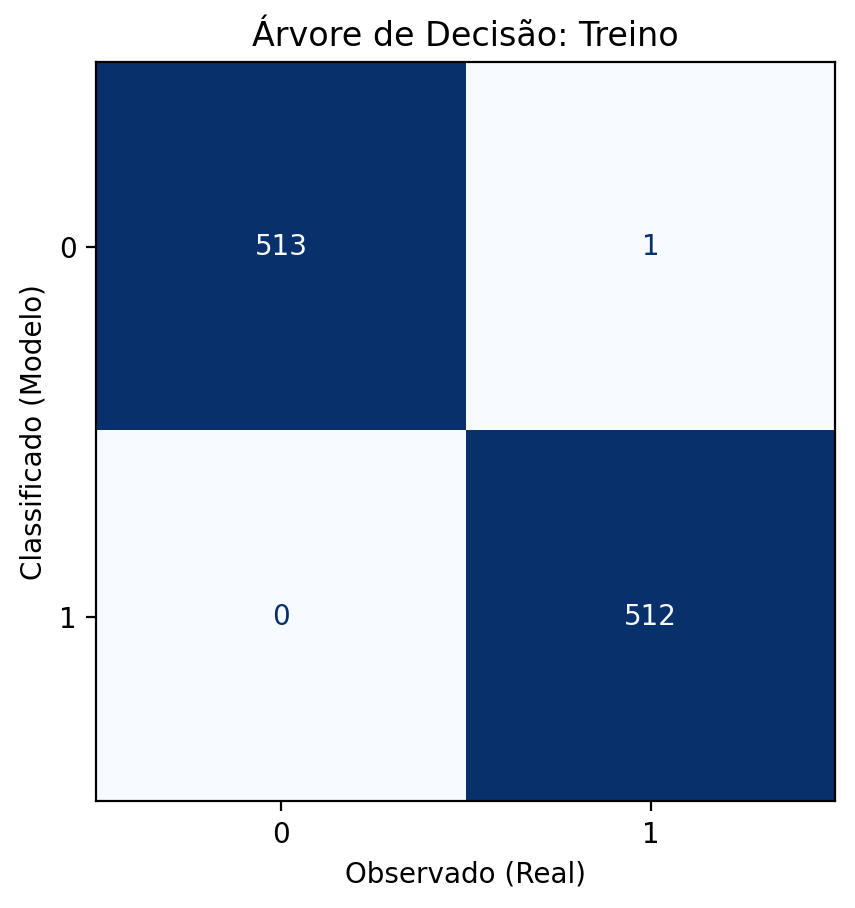

Avaliação da Árvore (Base de Treino)
Acurácia: 99.9%
Sensibilidade: 99.8%
Especificidade: 100.0%
Precision: 100.0%


In [55]:
#Matriz de confusão (base de treino)

tree_cm_train = confusion_matrix(tree_pred_train_class, y_train)
cm_train_disp_tree = ConfusionMatrixDisplay(tree_cm_train)

plt.rcParams['figure.dpi'] = 200
cm_train_disp_tree.plot(colorbar=False, cmap='Blues')
plt.title('Árvore de Decisão: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_tree_train = accuracy_score(y_train, tree_pred_train_class)
sens_tree_train = recall_score(y_train, tree_pred_train_class, pos_label=1)
espec_tree_train = recall_score(y_train, tree_pred_train_class, pos_label=0)
prec_tree_train = precision_score(y_train, tree_pred_train_class)

print("Avaliação da Árvore (Base de Treino)")
print(f"Acurácia: {acc_tree_train:.1%}")
print(f"Sensibilidade: {sens_tree_train:.1%}")
print(f"Especificidade: {espec_tree_train:.1%}")
print(f"Precision: {prec_tree_train:.1%}")

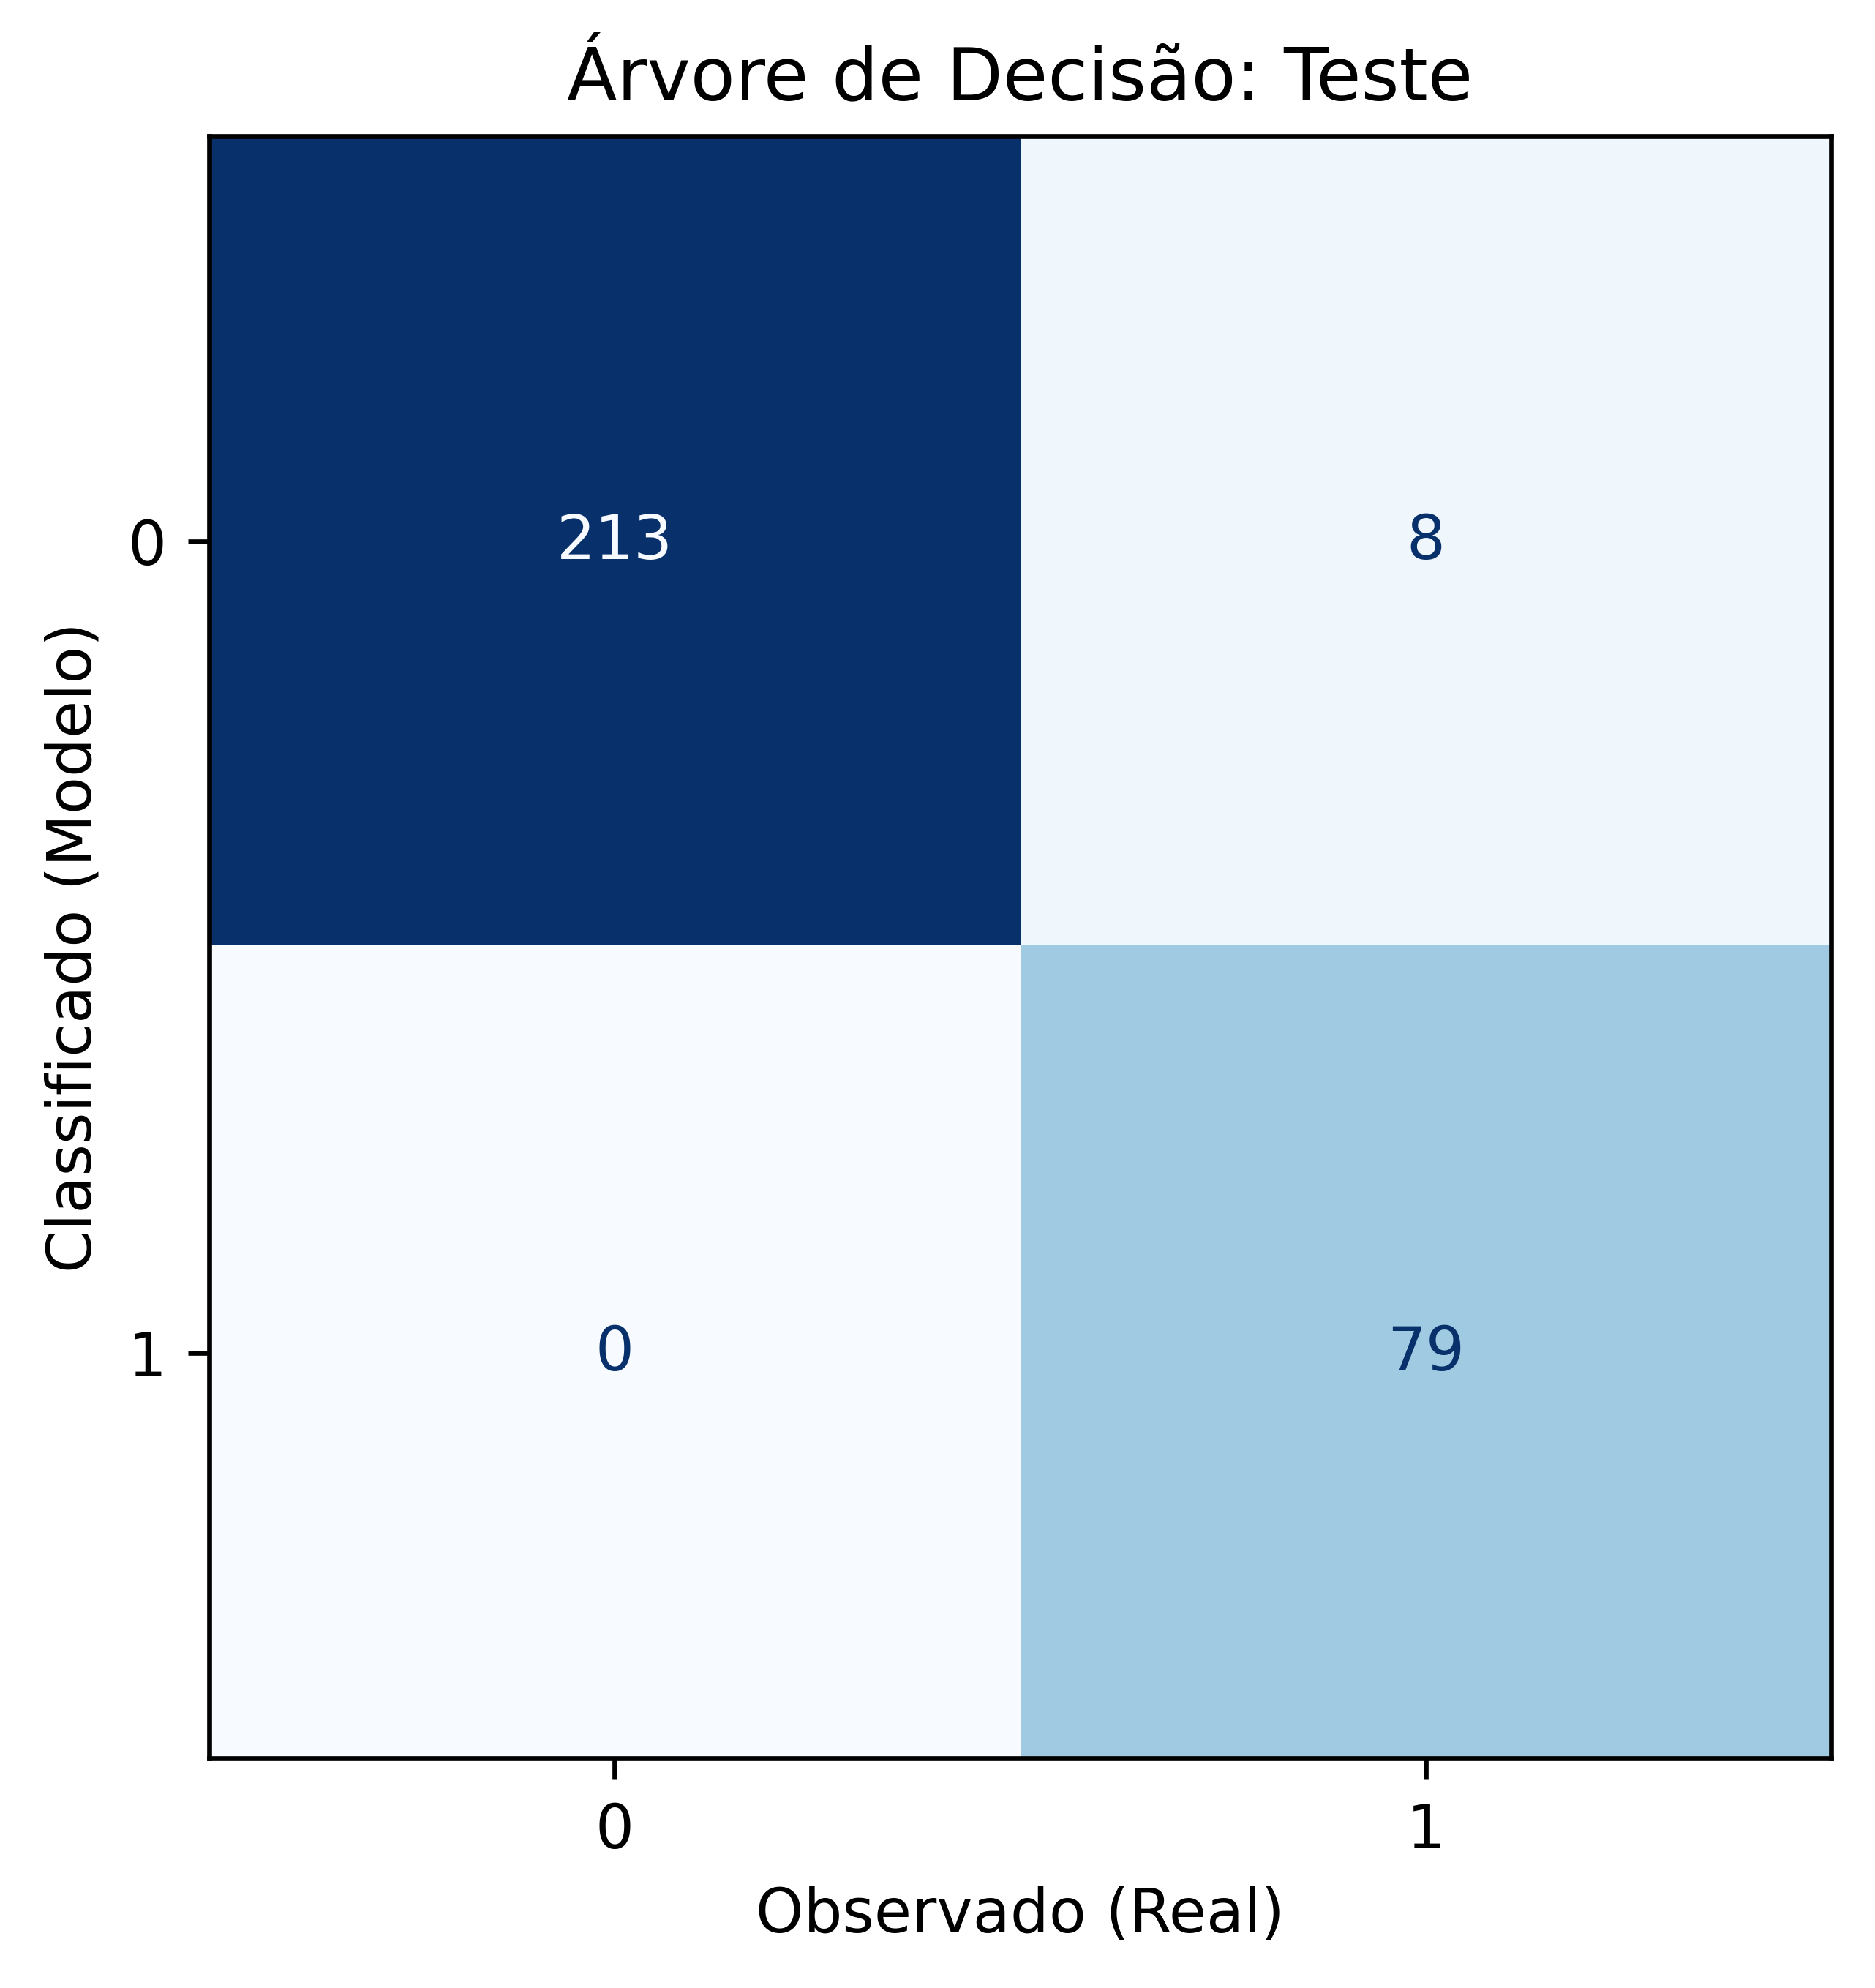

Avaliação da Árvore (Base de Teste)
Acurácia: 97.3%
Sensibilidade: 90.8%
Especificidade: 100.0%
Precision: 100.0%


In [92]:
#Matriz de confusão (base de teste)

tree_cm_test = confusion_matrix(tree_pred_test_class, y_test)
cm_test_disp_tree = ConfusionMatrixDisplay(tree_cm_test)

plt.rcParams['figure.dpi'] = 600
cm_test_disp_tree.plot(colorbar=False, cmap='Blues')
plt.title('Árvore de Decisão: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_tree_test = accuracy_score(y_test, tree_pred_test_class)
sens_tree_test = recall_score(y_test, tree_pred_test_class, pos_label=1)
espec_tree_test = recall_score(y_test, tree_pred_test_class, pos_label=0)
prec_tree_test = precision_score(y_test, tree_pred_test_class)

print("Avaliação da Árvore (Base de Teste)")
print(f"Acurácia: {acc_tree_test:.1%}")
print(f"Sensibilidade: {sens_tree_test:.1%}")
print(f"Especificidade: {espec_tree_test:.1%}")
print(f"Precision: {prec_tree_test:.1%}")

In [57]:
#Hiperparâmetros do modelo

# max_depth: profundidade máxima da árvore
# min_samples_split: qtde mínima de observações exigidas para dividir o nó
# min_samples_leaf: qtde mínima de observações exigidas para ser nó folha

tree_clf_aj = DecisionTreeClassifier(max_depth=7,
                                     min_samples_split=10,
                                     min_samples_leaf=5,
                                     random_state=42)
tree_clf_aj.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

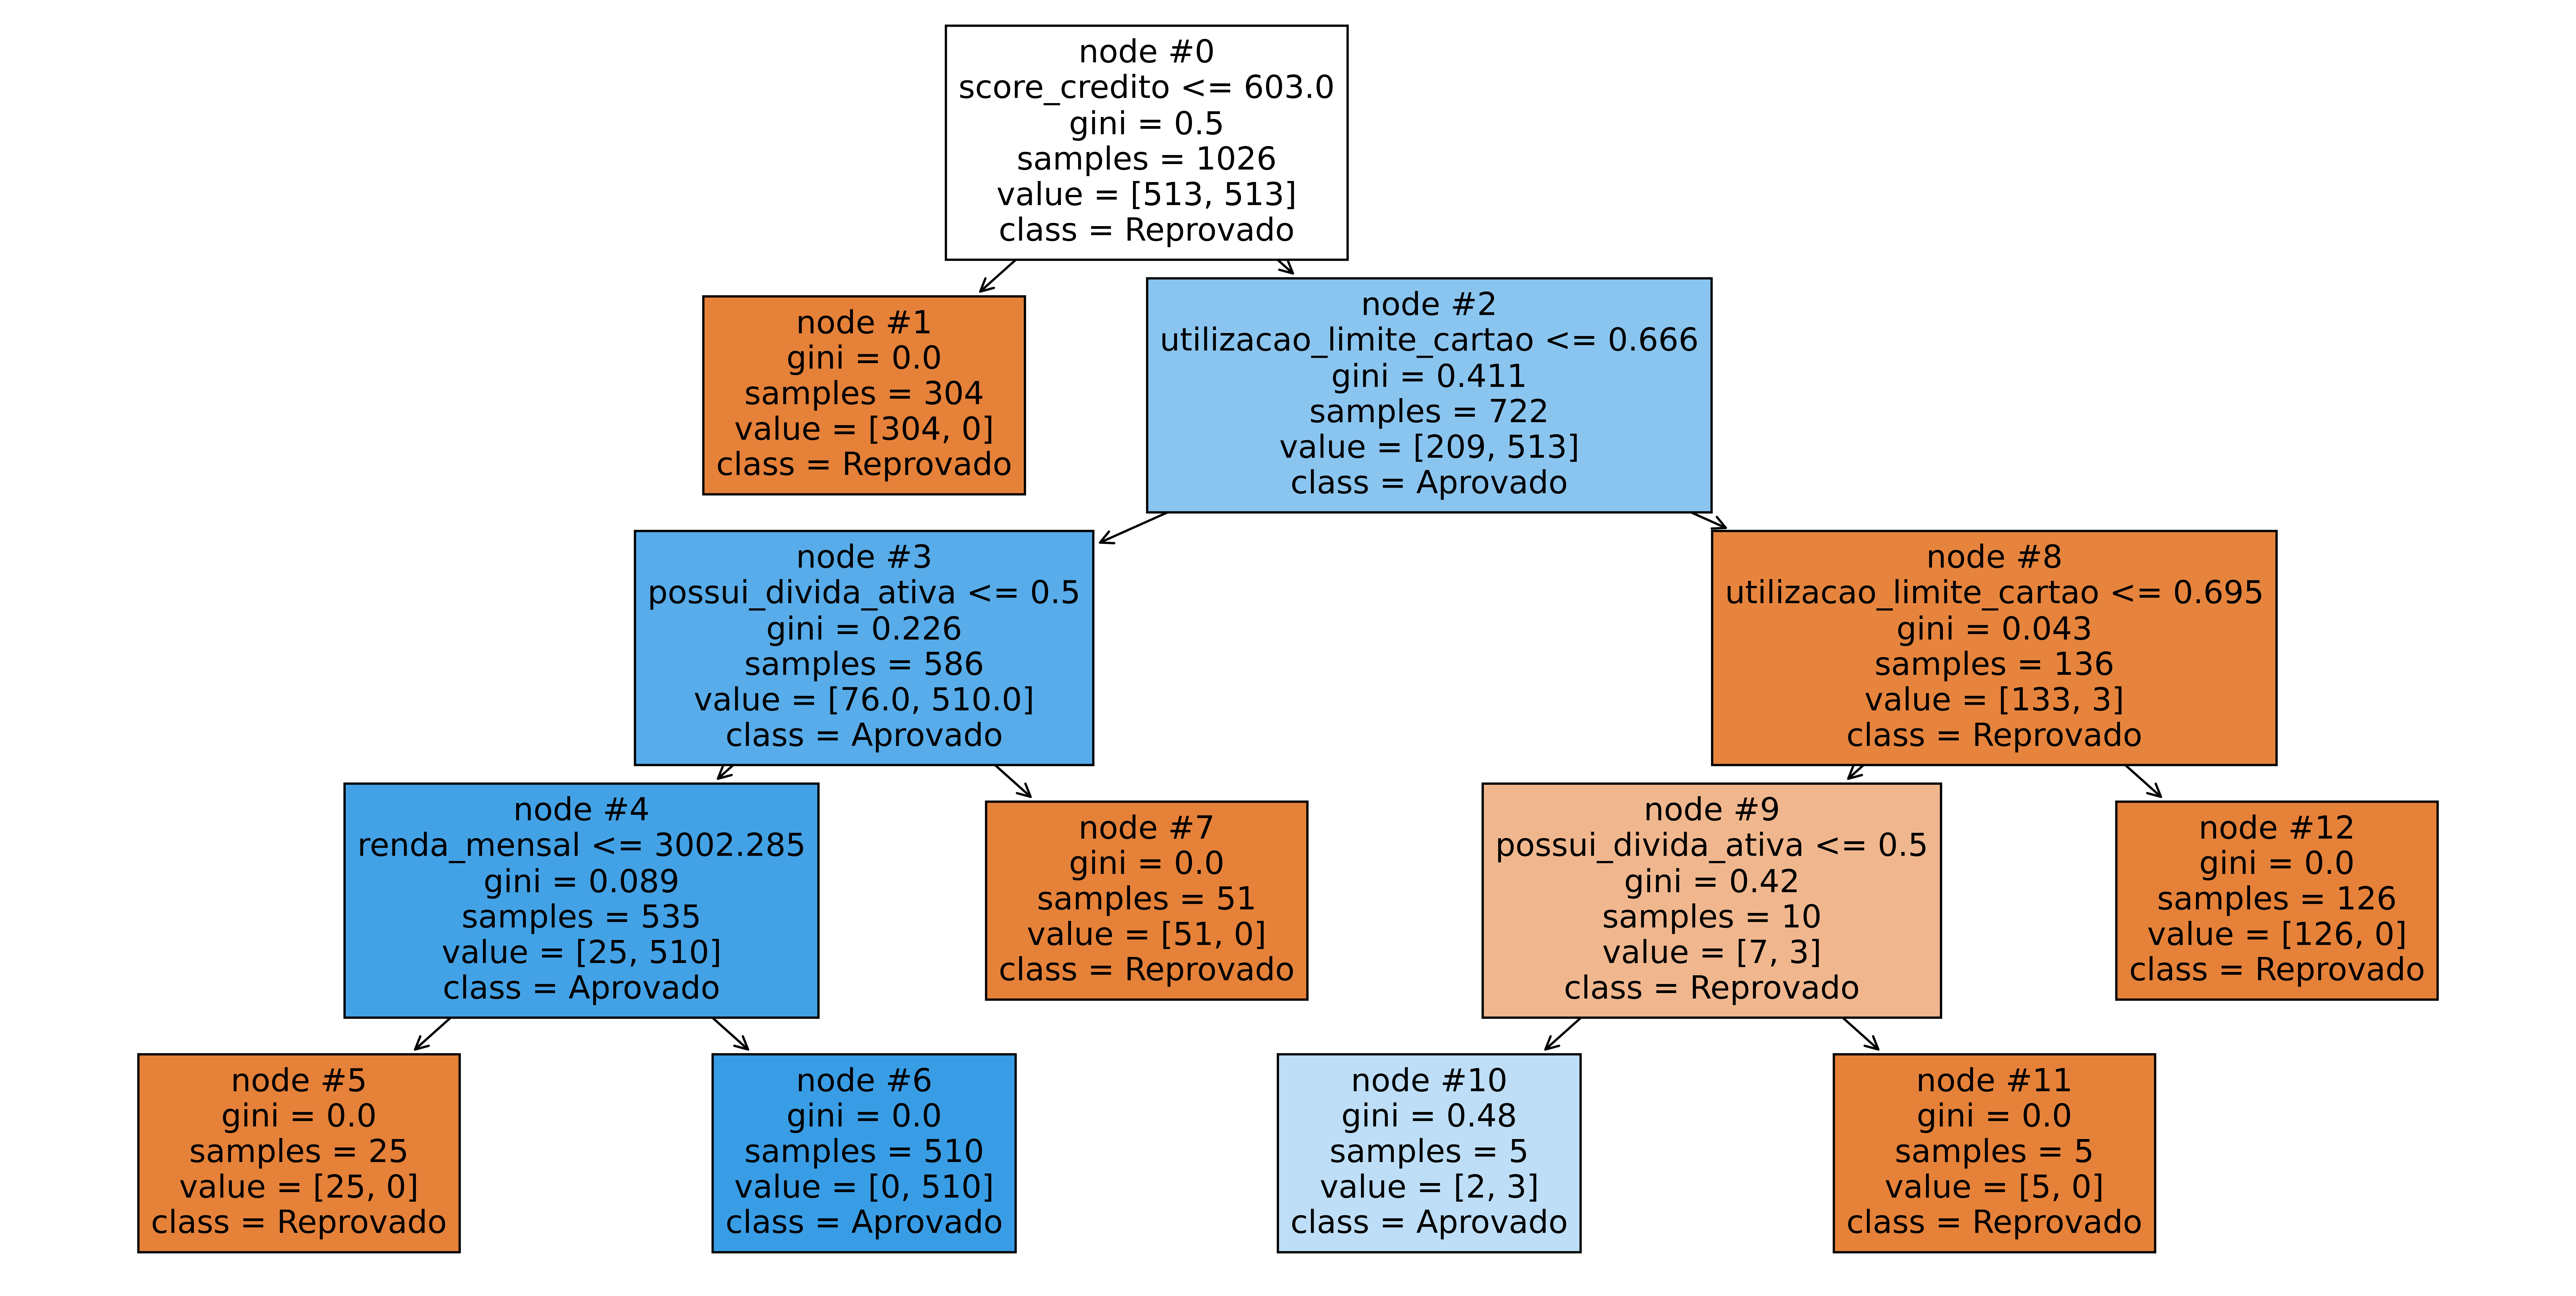

In [59]:
#Plotando a Arvore

plt.figure(figsize=(20,10), dpi=600)
plot_tree(tree_clf_aj,
          feature_names=X.columns.tolist(),
          class_names=['Reprovado','Aprovado'],
          proportion=False,
          filled=True,
          node_ids=True)
plt.show()

In [63]:
#Obtendo os valores preditos pelo modelo ajustado (base de teste)

tree_pred_test_class_aj = tree_clf_aj.predict(X_test)
tree_pred_test_prob_aj = tree_clf_aj.predict_proba(X_test)

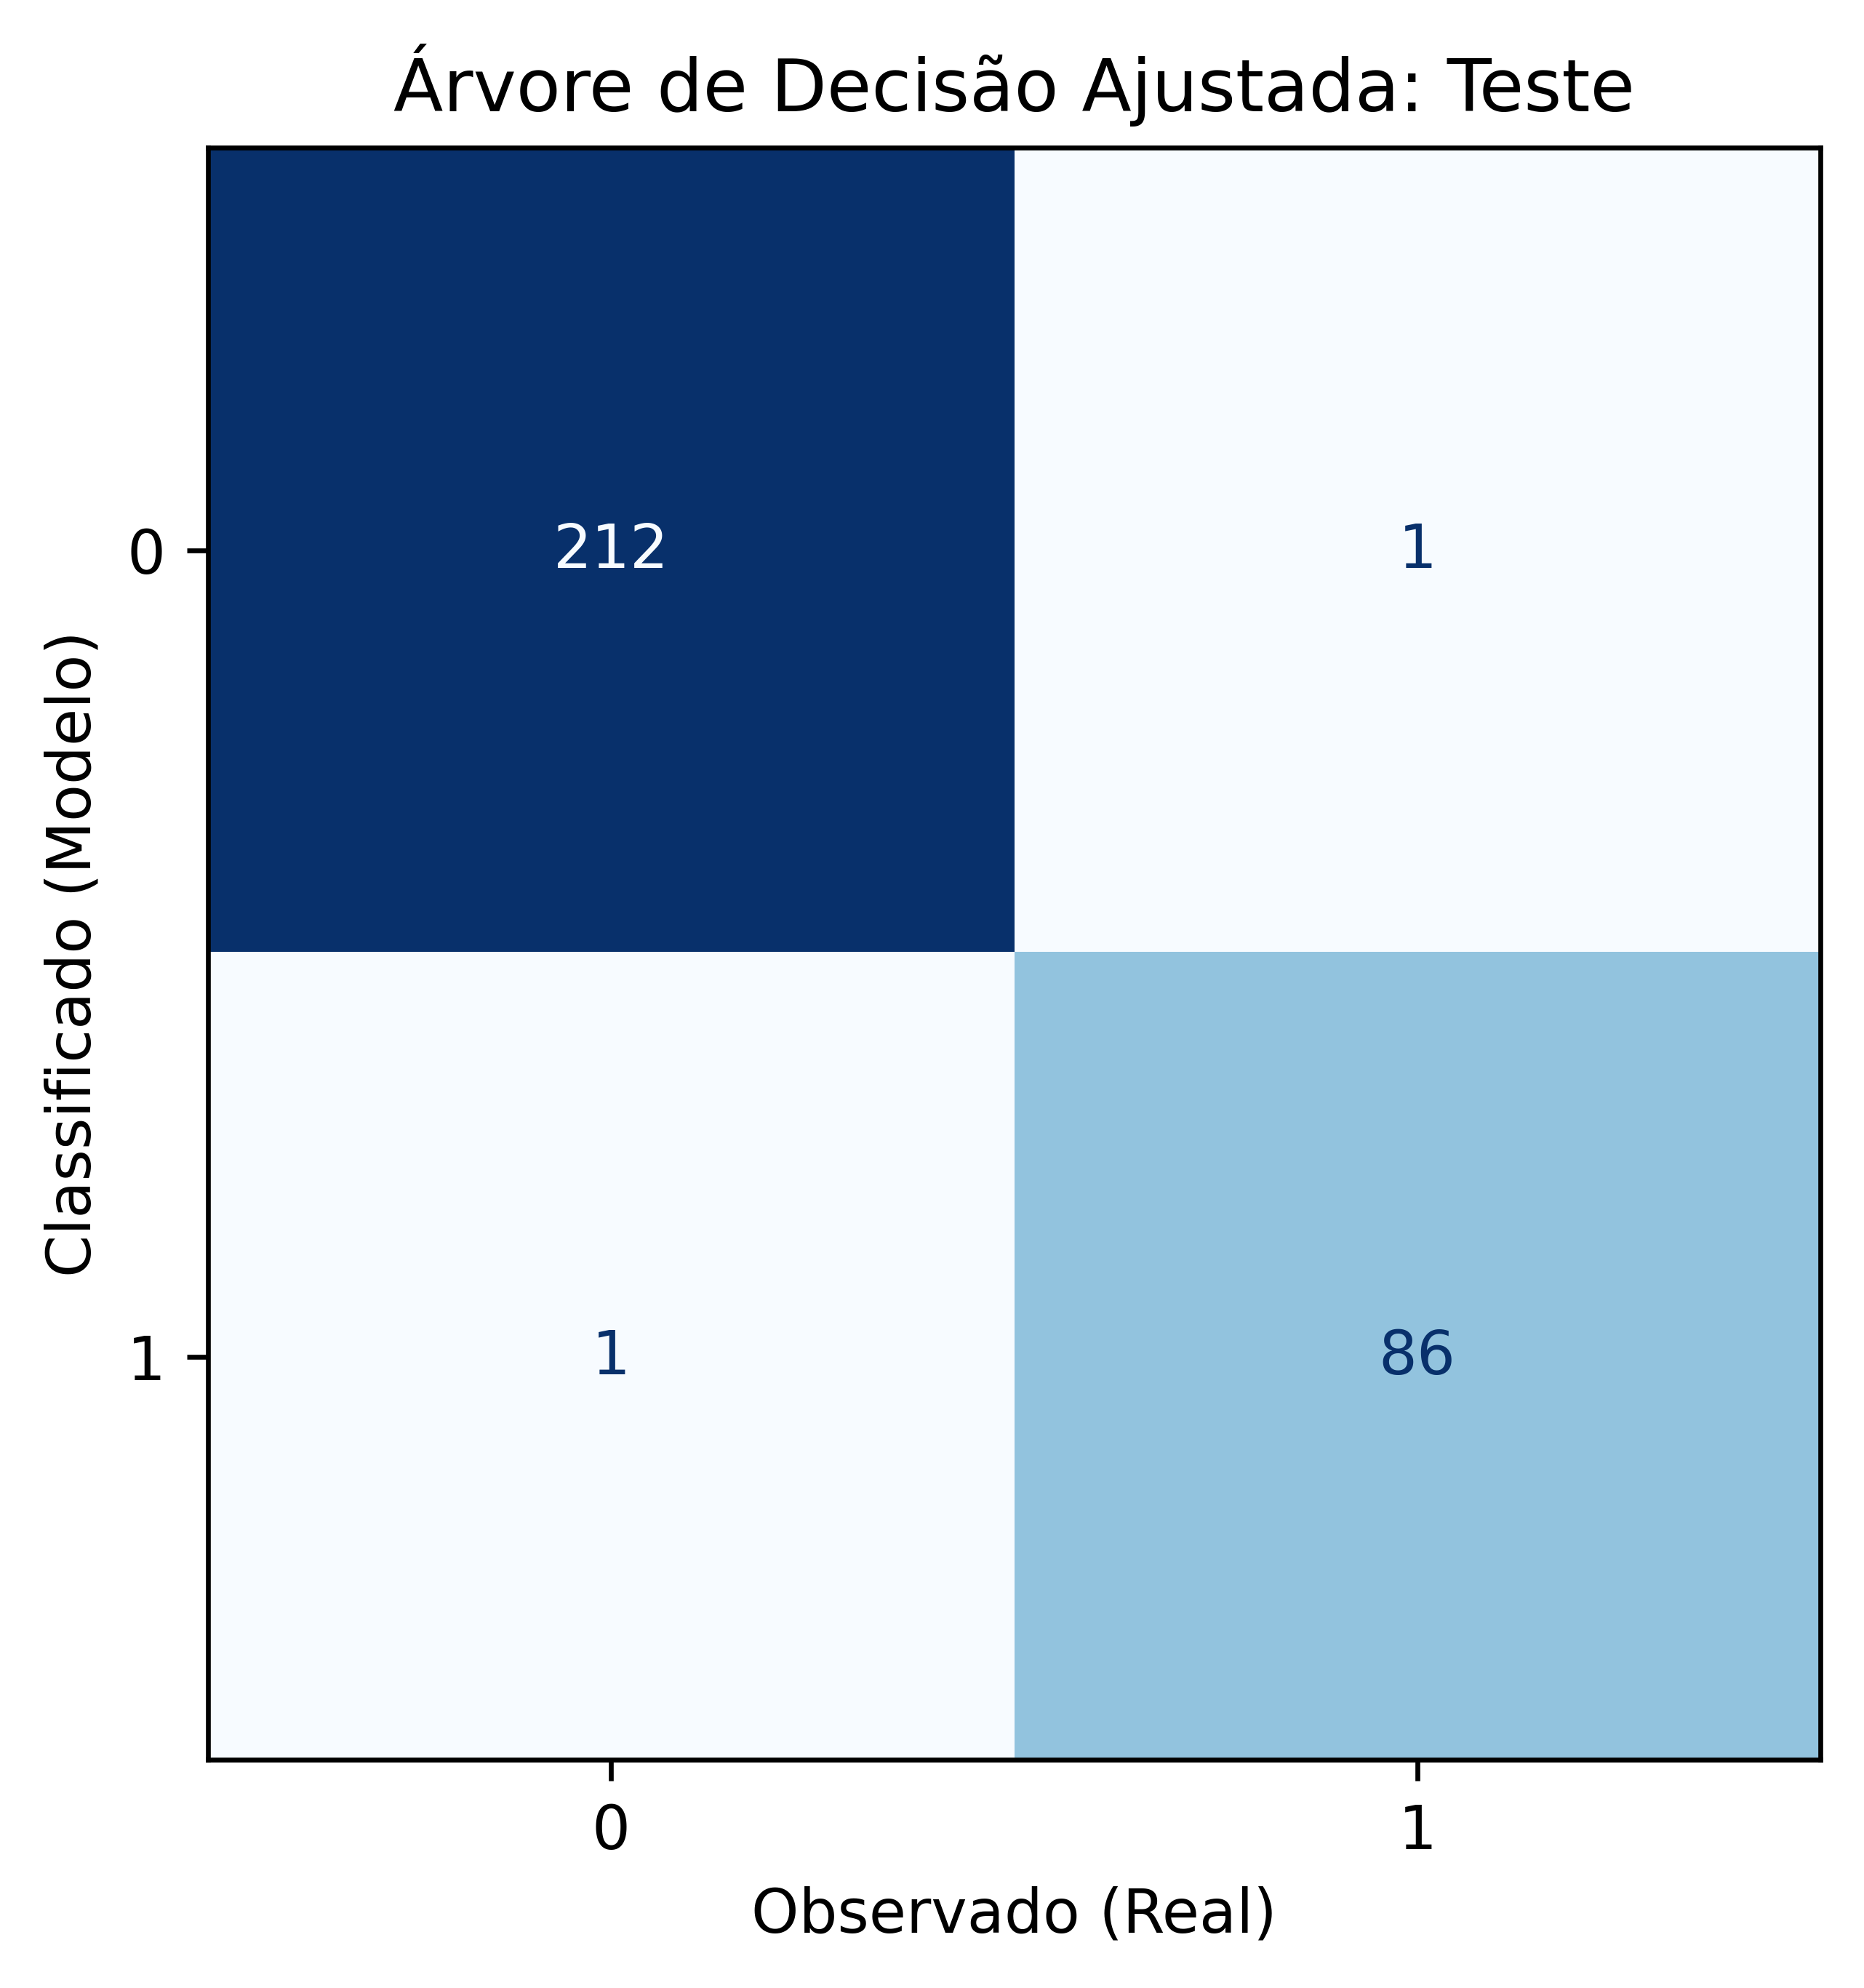

Avaliação da Árvore Ajustada (Base de Teste)
Acurácia: 99.3%
Sensibilidade: 98.9%
Especificidade: 99.5%
Precision: 98.9%


In [65]:
#Matriz de confusão (base de teste)

tree_cm_test_aj = confusion_matrix(tree_pred_test_class_aj, y_test)
cm_test_disp_aj = ConfusionMatrixDisplay(tree_cm_test_aj)

plt.rcParams['figure.dpi'] = 600
cm_test_disp_aj.plot(colorbar=False, cmap='Blues')
plt.title('Árvore de Decisão Ajustada: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_tree_test_aj = accuracy_score(y_test, tree_pred_test_class_aj)
sens_tree_test_aj = recall_score(y_test, tree_pred_test_class_aj, pos_label=1)
espec_tree_test_aj = recall_score(y_test, tree_pred_test_class_aj, pos_label=0)
prec_tree_test_aj = precision_score(y_test, tree_pred_test_class_aj)

print("Avaliação da Árvore Ajustada (Base de Teste)")
print(f"Acurácia: {acc_tree_test_aj:.1%}")
print(f"Sensibilidade: {sens_tree_test_aj:.1%}")
print(f"Especificidade: {espec_tree_test_aj:.1%}")
print(f"Precision: {prec_tree_test_aj:.1%}")

## Não há melhoria expressiva em relação à árvore menor!


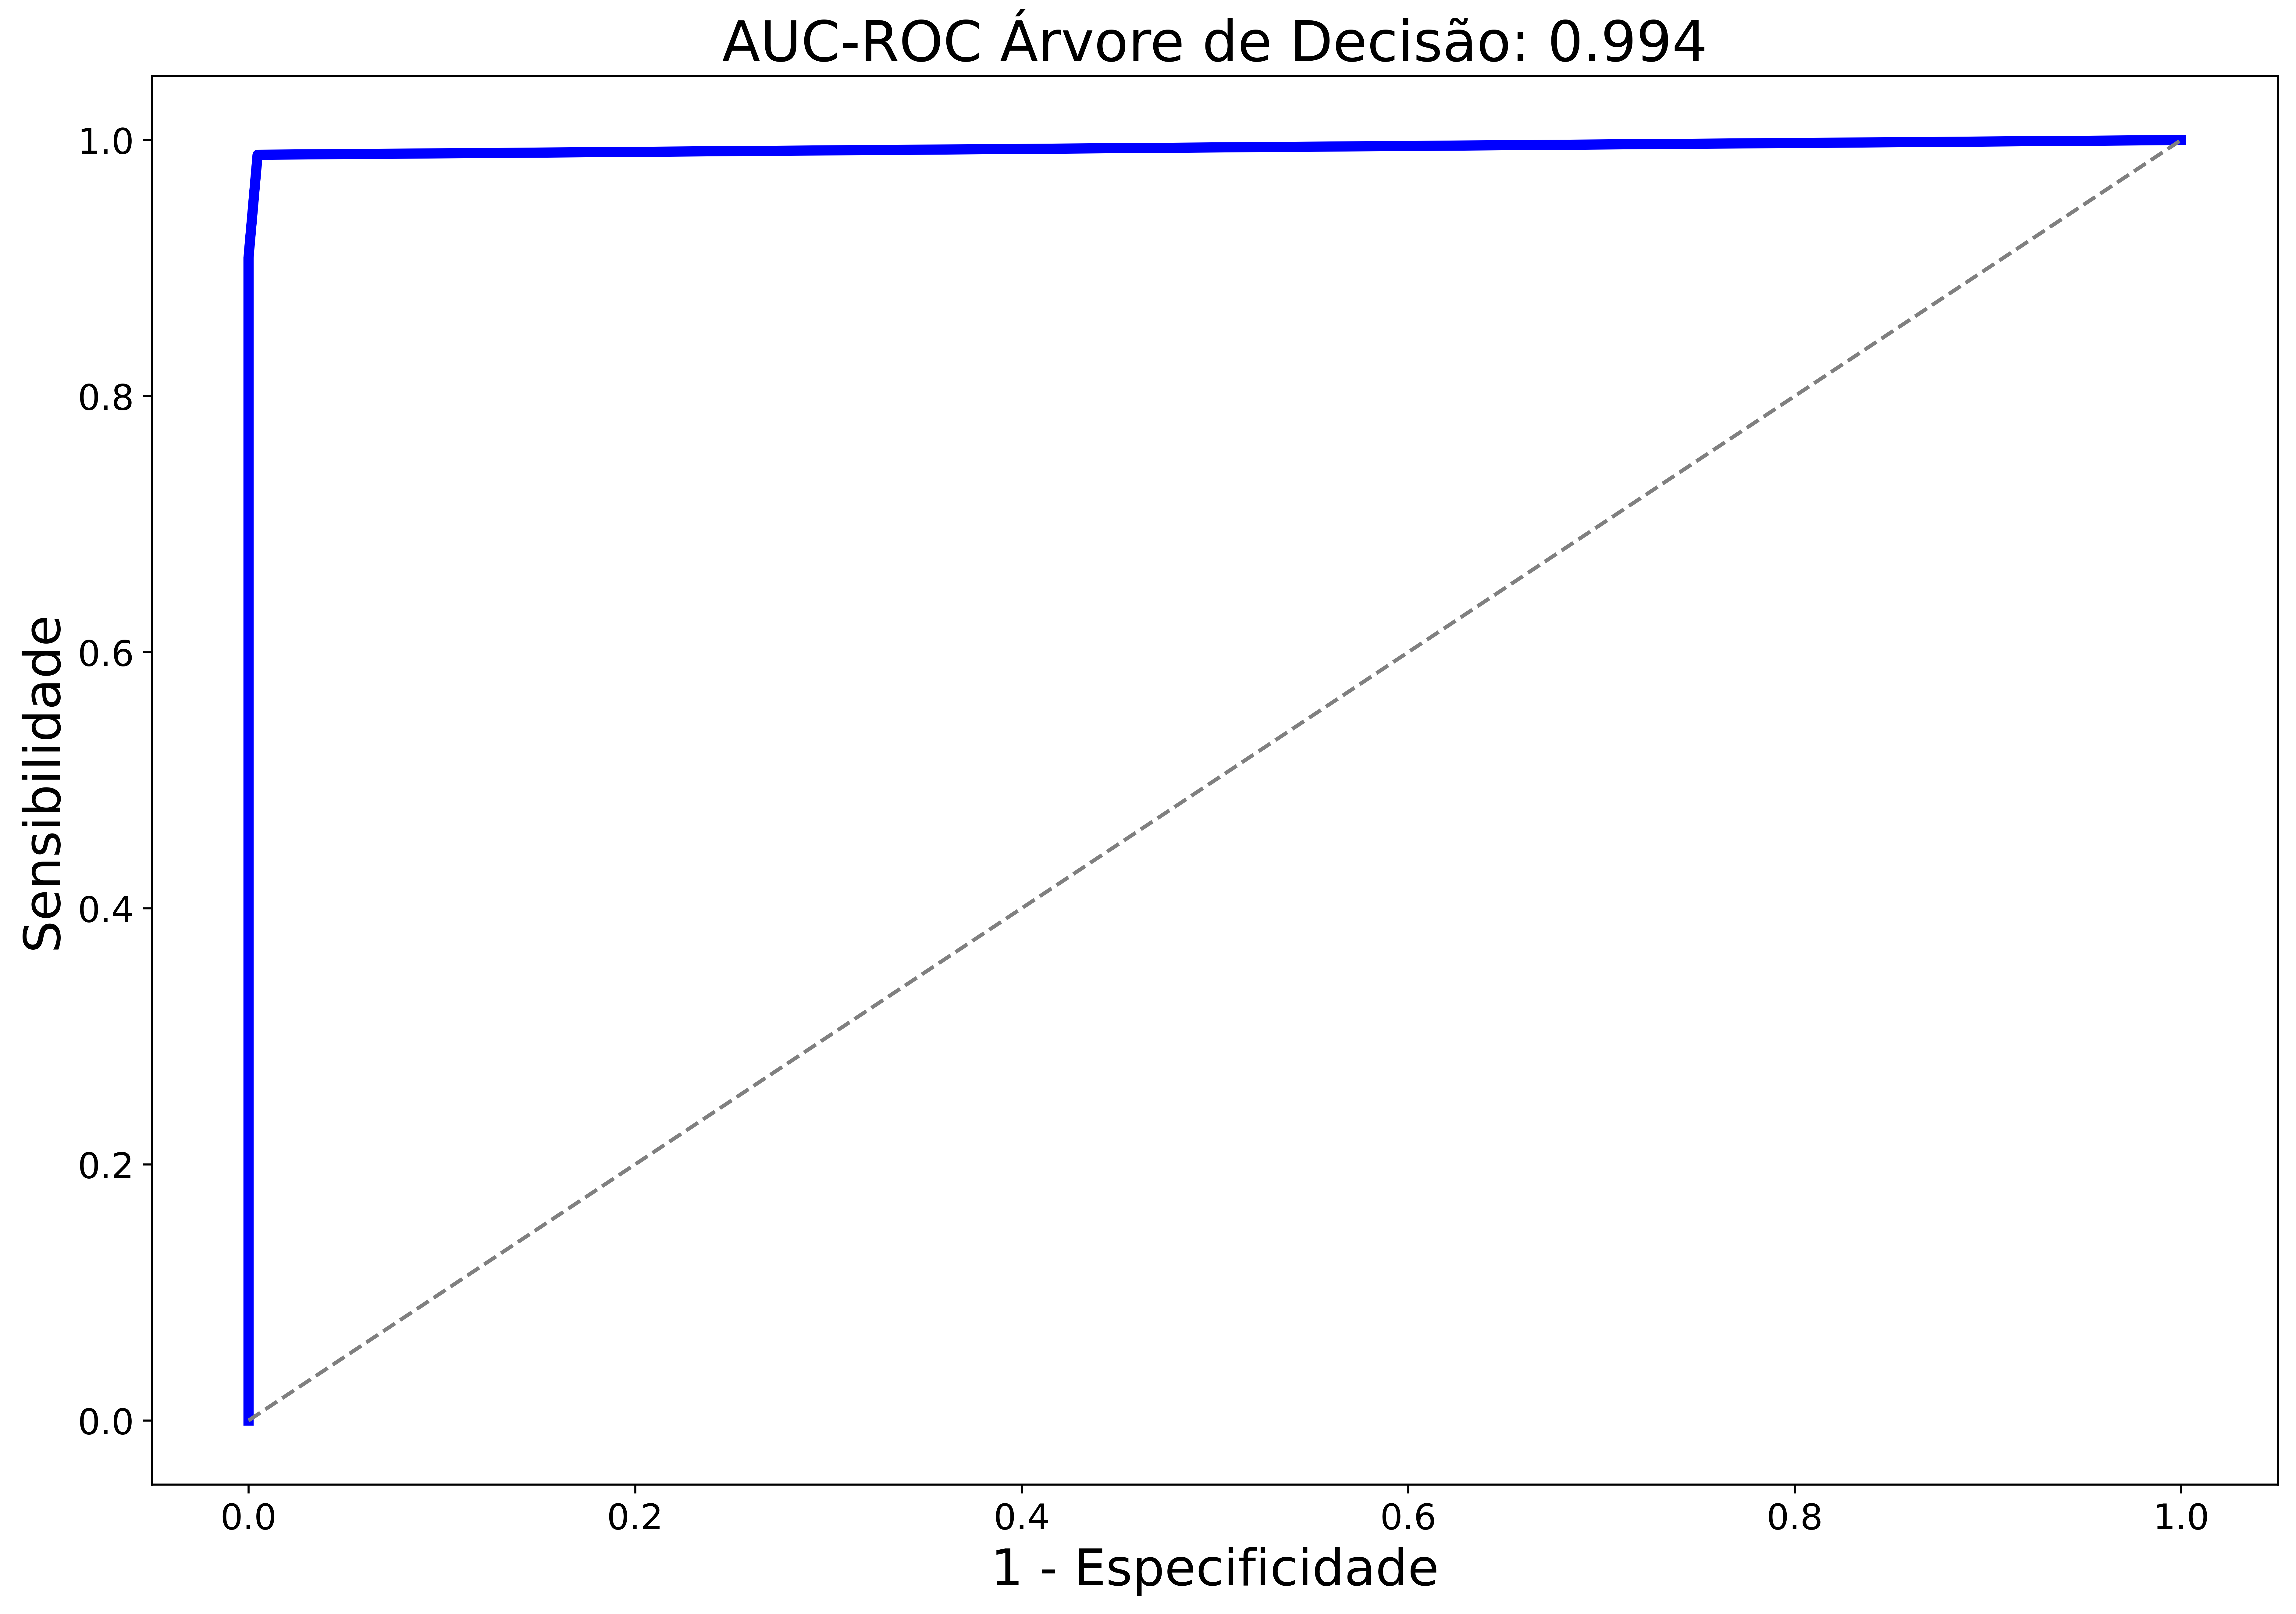

In [67]:
#Curva ROC (base de teste)

# Parametrizando a função da curva ROC (real vs. previsto)
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, tree_pred_test_prob_aj[:,1])
roc_auc_tree = auc(fpr_tree, tpr_tree)

# Plotando a curva ROC
plt.figure(figsize=(15,10), dpi=600)
plt.plot(fpr_tree, tpr_tree, color='blue', linewidth=4)
plt.plot(fpr_tree, fpr_tree, color='gray', linestyle='dashed')
plt.title('AUC-ROC Árvore de Decisão: %g' % round(roc_auc_tree, 3), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensibilidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

In [69]:
#Random Forest

# Estimando uma random forest

rf_clf = RandomForestClassifier(n_estimators=50, 
                                max_depth=2,
                                max_features=3,
                                random_state=42)
rf_clf.fit(X_train, y_train)

# Alguns hiperparâmetros:

# n_estimators: qtde de árvores estimadas
# max_depth: profundidade máxima das árvores
# max_features: qtde de variáveis preditoras consideradas nos splits
# min_samples_split: qtde mínima de observações exigidas para dividir o nó
# min_samples_leaf: qtde mínima de observações exigidas para ser nó folha


RandomForestClassifier(max_depth=2, max_features=3, n_estimators=50,
                       random_state=42)

In [77]:
#Obtendo os valores preditos pela RF

# Predict na base de treinamento
rf_pred_train_class = rf_clf.predict(X_train)
rf_pred_train_prob = rf_clf.predict_proba(X_train)

# Predict na base de testes
rf_pred_test_class = rf_clf.predict(X_test)
rf_pred_test_prob = rf_clf.predict_proba(X_test)

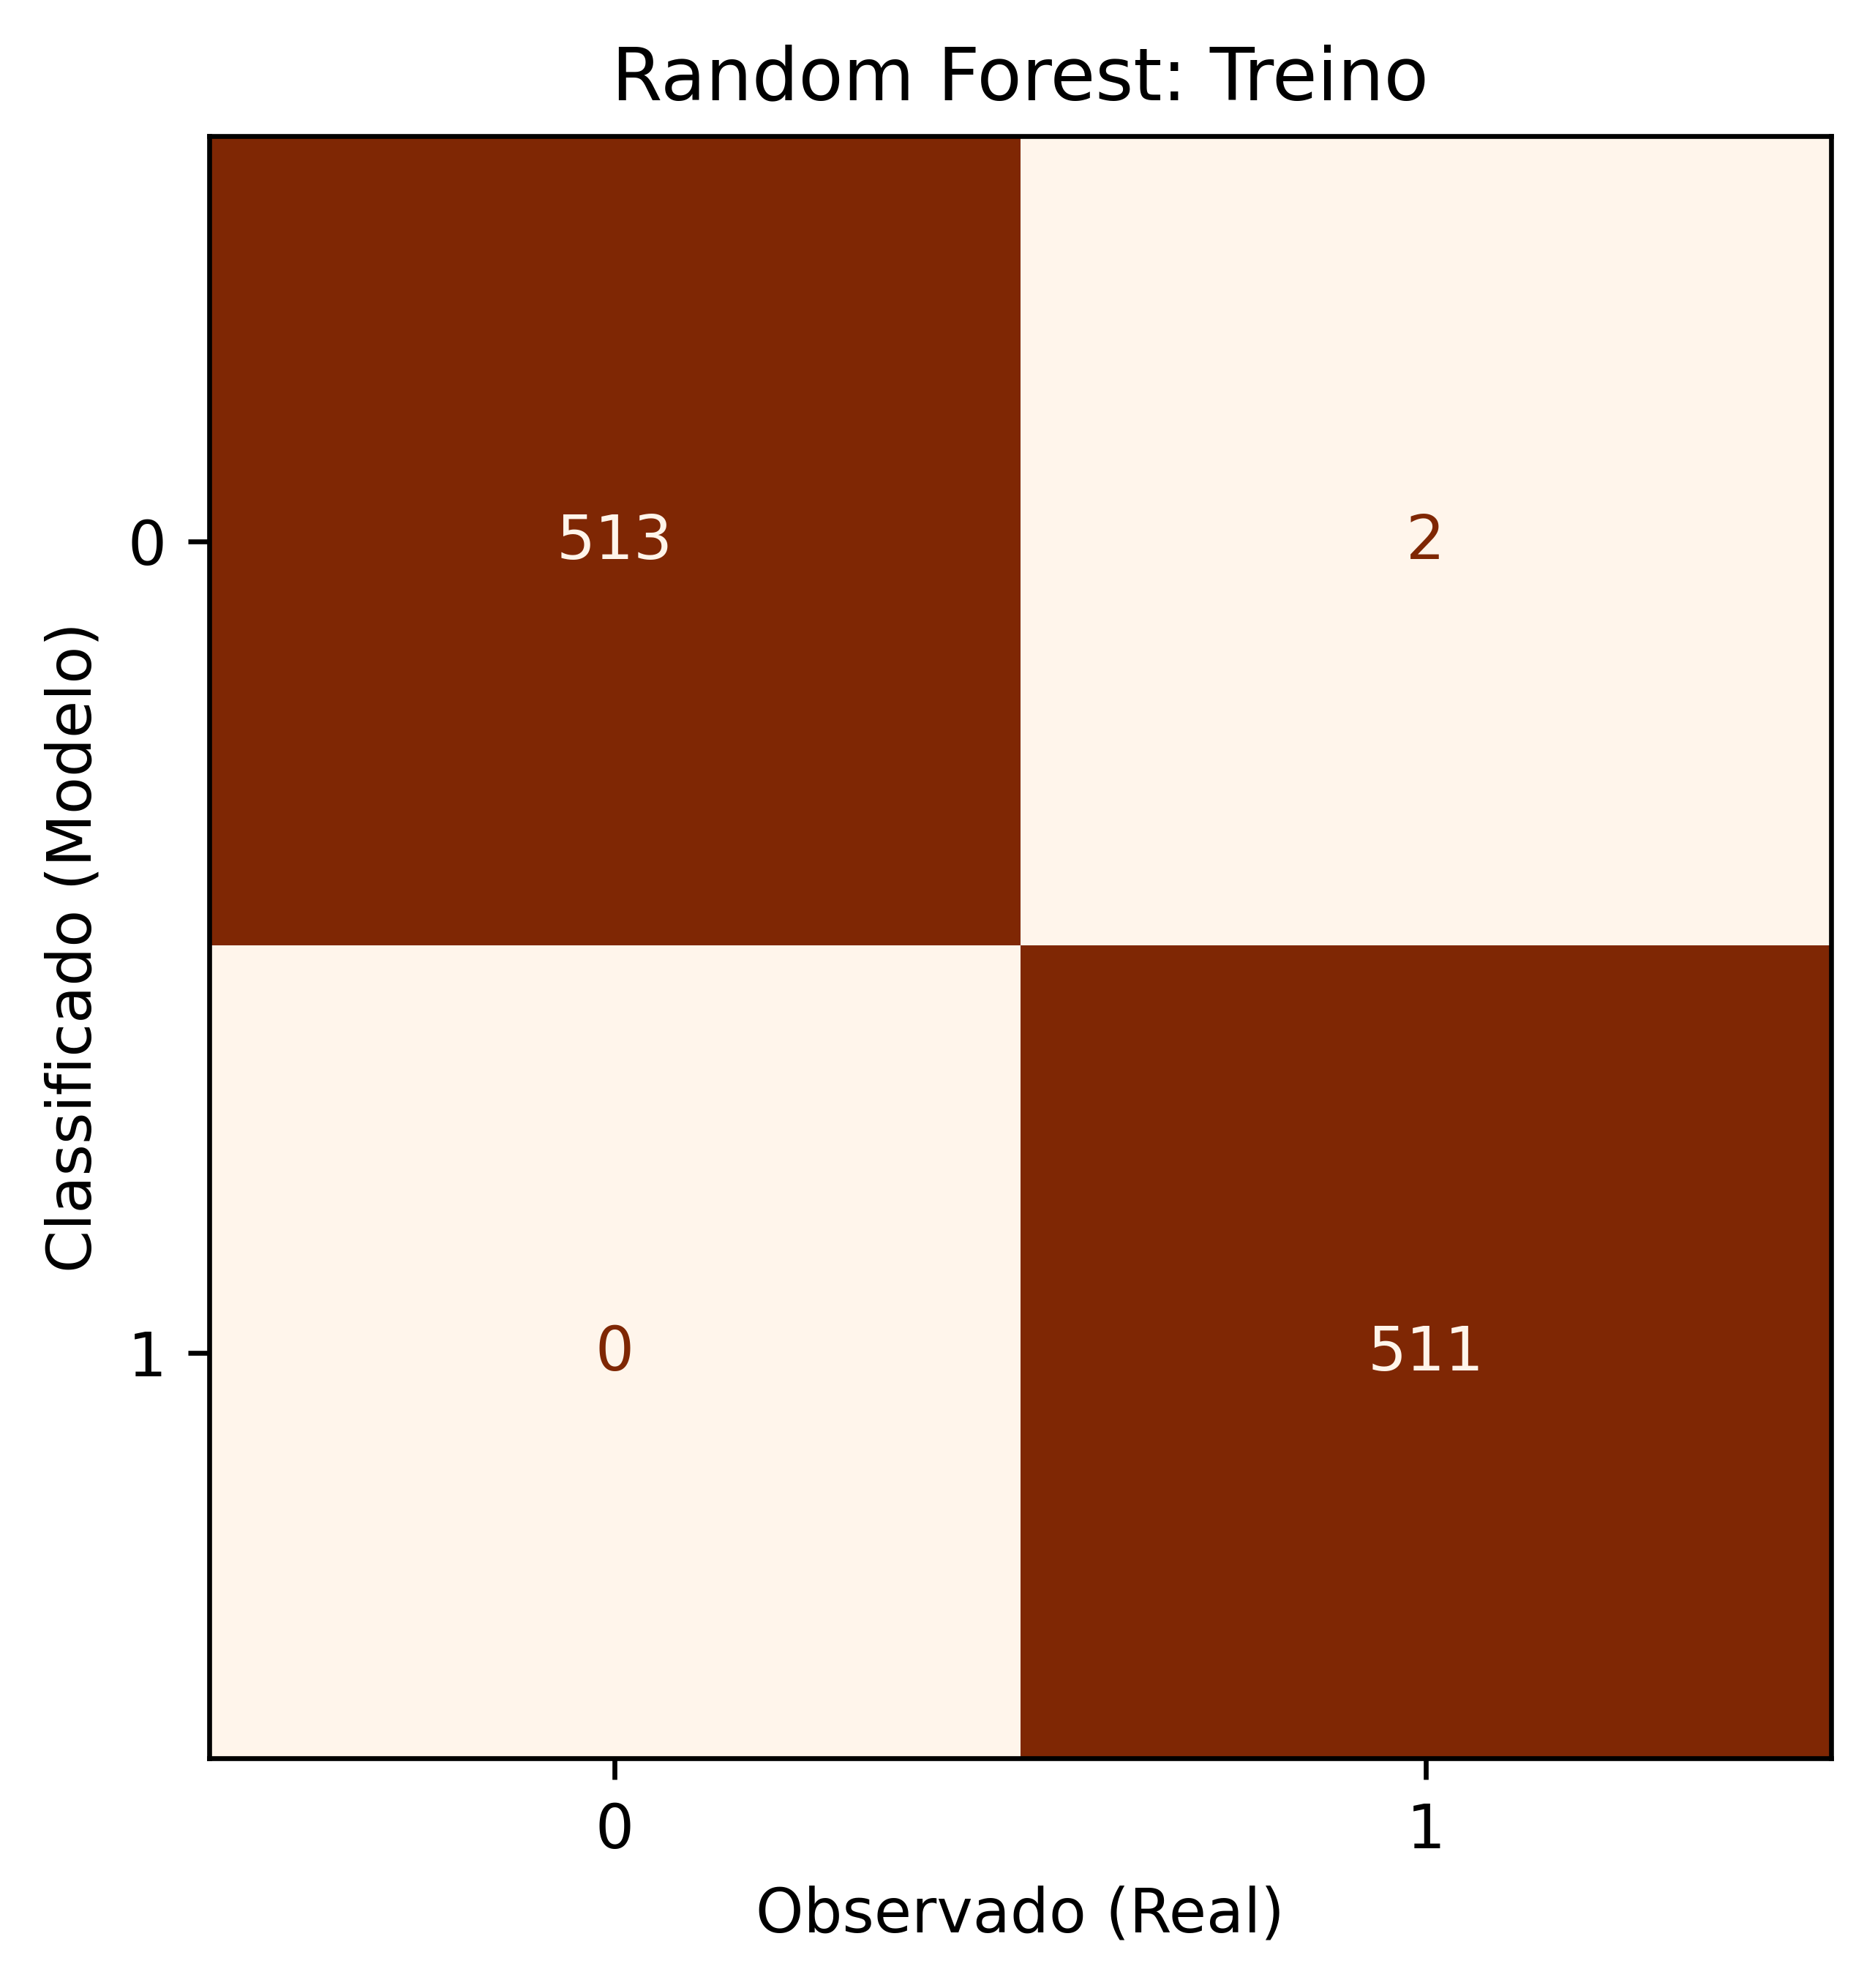

Avaliação da RF (Base de Treino)
Acurácia: 99.8%
Sensibilidade: 99.6%
Especificidade: 100.0%
Precision: 100.0%


In [79]:
#Matriz de confusão (base de treino)

rf_cm_train = confusion_matrix(rf_pred_train_class, y_train)
cm_rf_train = ConfusionMatrixDisplay(rf_cm_train)

plt.rcParams['figure.dpi'] = 600
cm_rf_train.plot(colorbar=False, cmap='Oranges')
plt.title('Random Forest: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_rf_train = accuracy_score(y_train, rf_pred_train_class)
sens_rf_train = recall_score(y_train, rf_pred_train_class, pos_label=1)
espec_rf_train = recall_score(y_train, rf_pred_train_class, pos_label=0)
prec_rf_train = precision_score(y_train, rf_pred_train_class)

print("Avaliação da RF (Base de Treino)")
print(f"Acurácia: {acc_rf_train:.1%}")
print(f"Sensibilidade: {sens_rf_train:.1%}")
print(f"Especificidade: {espec_rf_train:.1%}")
print(f"Precision: {prec_rf_train:.1%}")

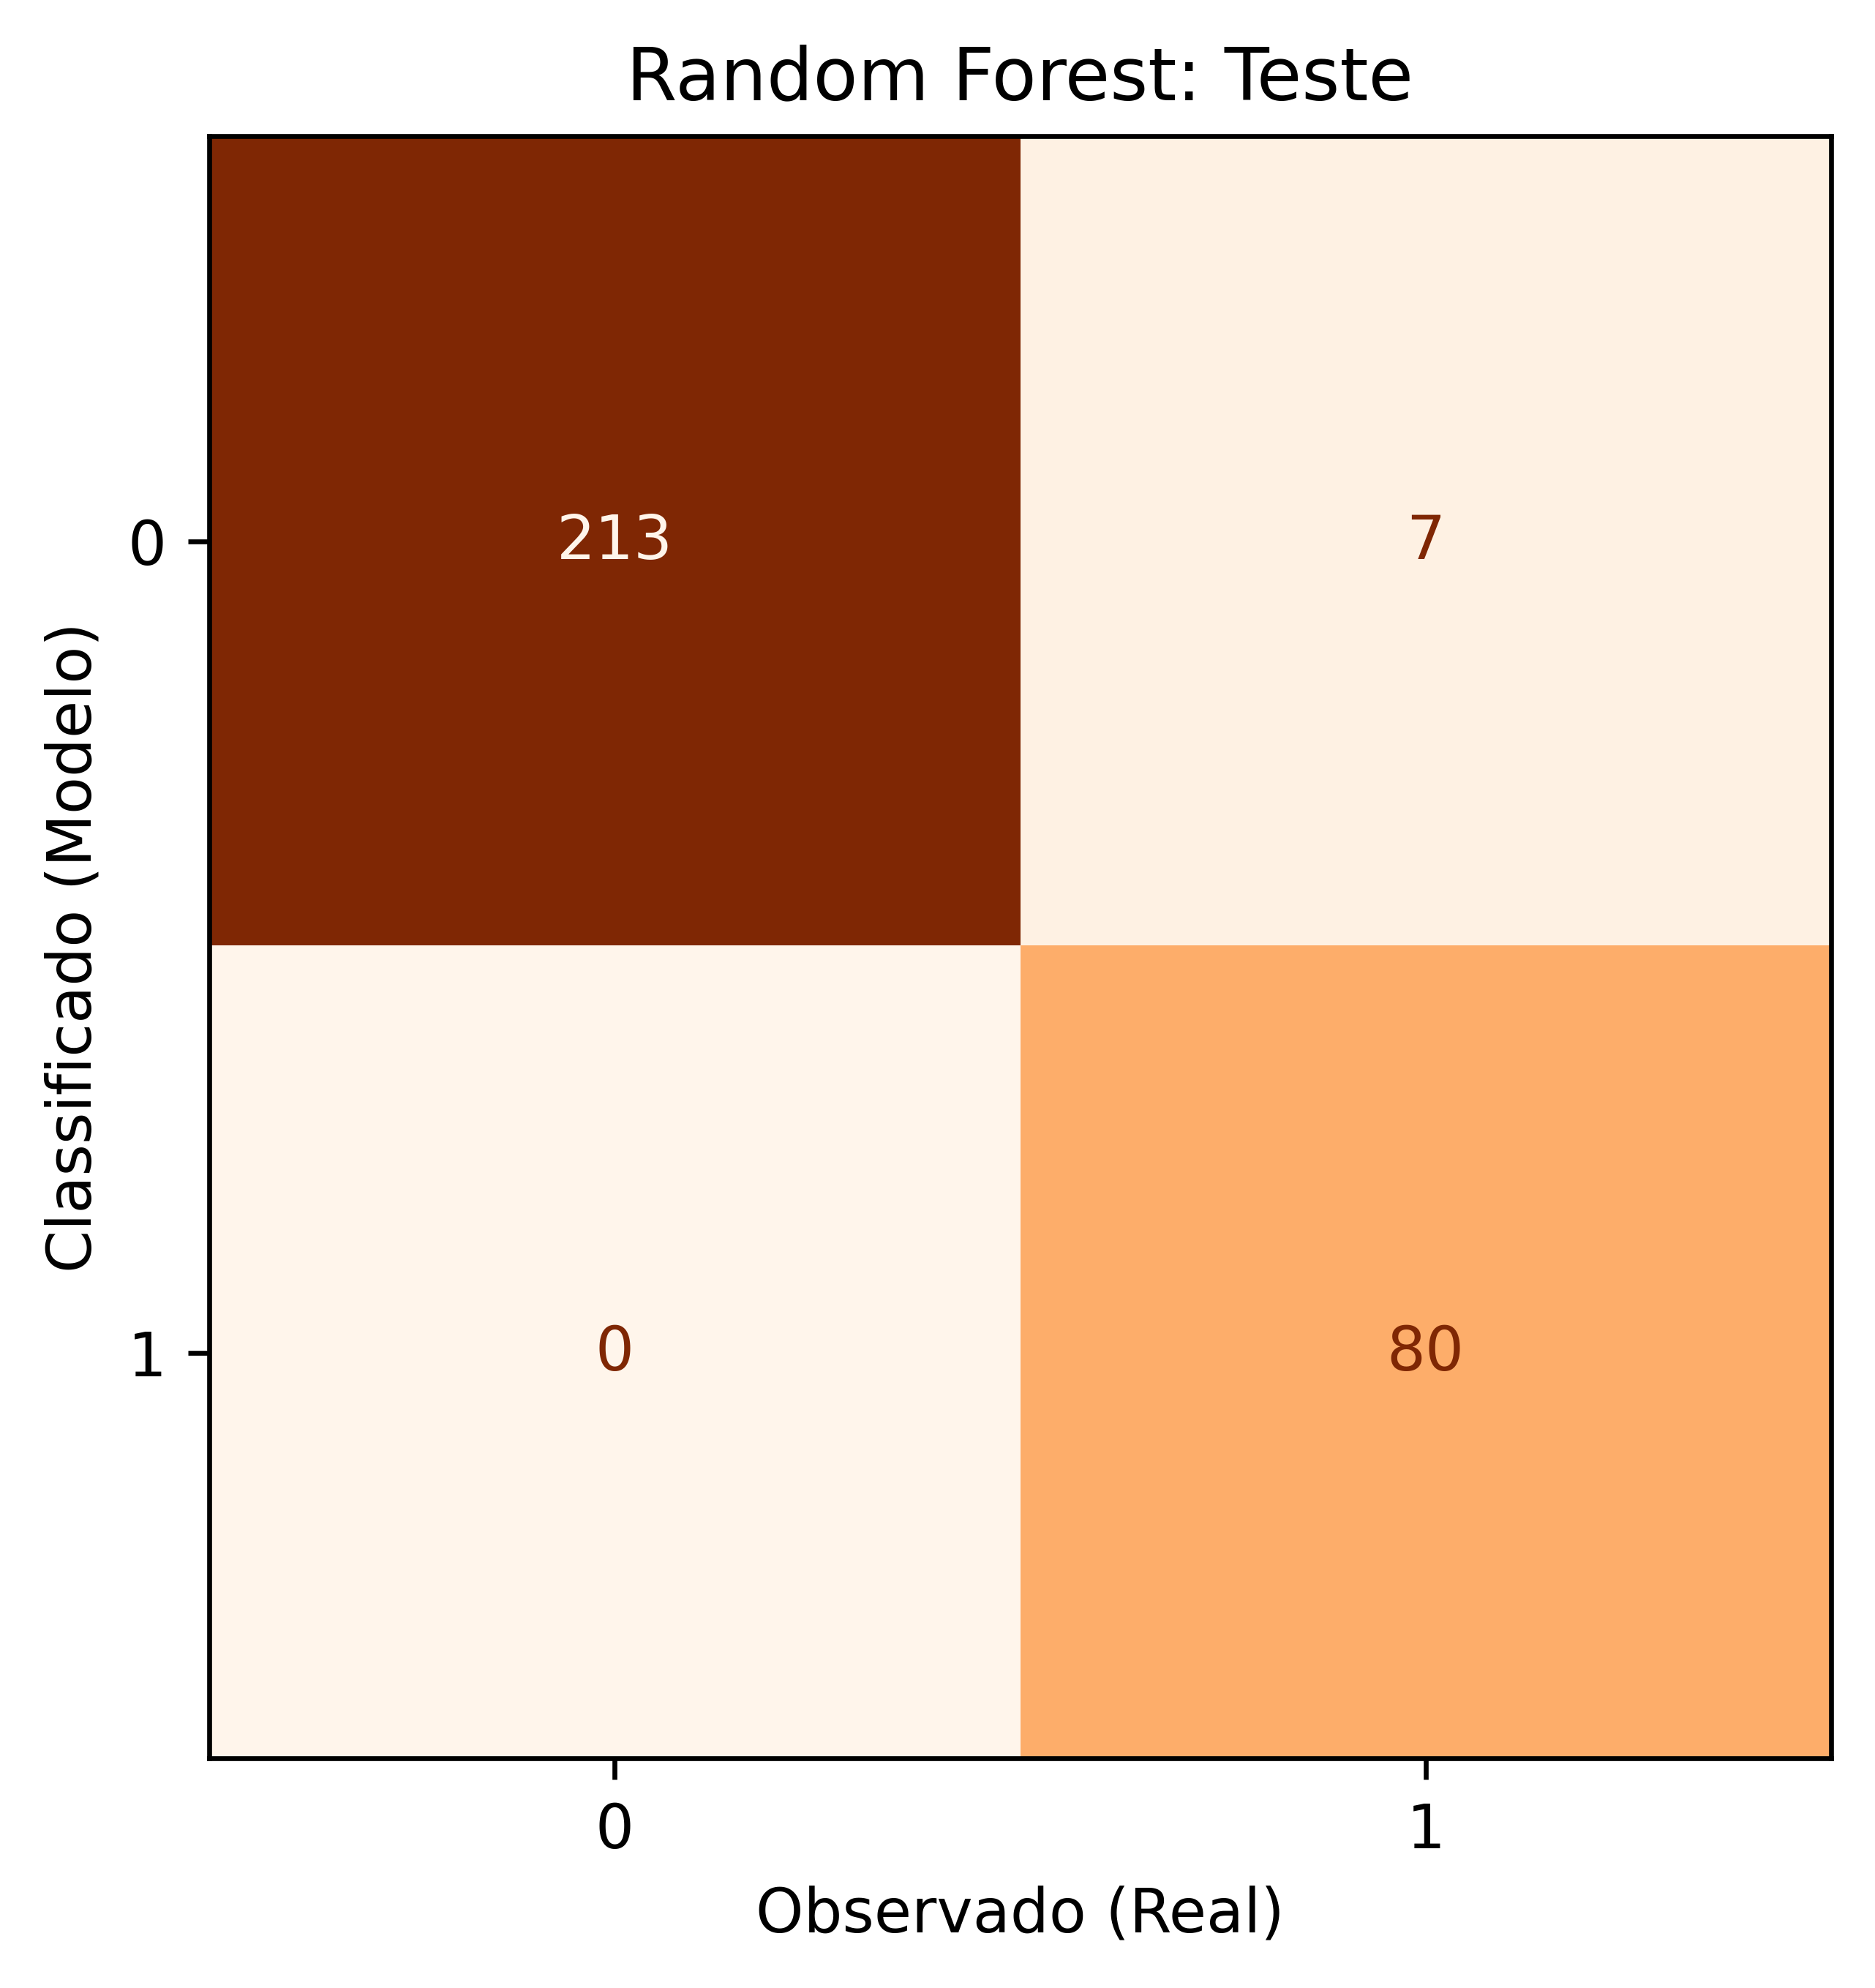

Avaliação da RF (Base de Teste)
Acurácia: 97.7%
Sensibilidade: 92.0%
Especificidade: 100.0%
Precision: 100.0%


In [110]:
#Matriz de confusão (base de teste)

rf_cm_test = confusion_matrix(rf_pred_test_class, y_test)
cm_rf_test = ConfusionMatrixDisplay(rf_cm_test)

plt.rcParams['figure.dpi'] = 600
cm_rf_test.plot(colorbar=False, cmap='Oranges')
plt.title('Random Forest: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_rf_test = accuracy_score(y_test, rf_pred_test_class)
sens_rf_test = recall_score(y_test, rf_pred_test_class, pos_label=1)
espec_rf_test = recall_score(y_test, rf_pred_test_class, pos_label=0)
prec_rf_test = precision_score(y_test, rf_pred_test_class)

print("Avaliação da RF (Base de Teste)")
print(f"Acurácia: {acc_rf_test:.1%}")
print(f"Sensibilidade: {sens_rf_test:.1%}")
print(f"Especificidade: {espec_rf_test:.1%}")
print(f"Precision: {prec_rf_test:.1%}")

In [81]:
#Grid Search

# Vamos especificar a lista de hiperparâmetros desejados e seus valores
param_grid_rf = {
    'n_estimators': [500, 1000],
    'max_depth': [5, 7],
    'max_features': [2, 3],
    'min_samples_split': [20, 50]
}

# Identificar o algoritmo em uso
rf_grid = RandomForestClassifier(random_state=42)

# Treinar os modelos para o grid search
rf_grid_model = GridSearchCV(estimator = rf_grid, 
                             param_grid = param_grid_rf,
                             scoring='accuracy',
                             cv=5, verbose=2)

rf_grid_model.fit(X_train, y_train)

# Verificando os melhores parâmetros obtidos
rf_grid_model.best_params_

# Gerando o modelo com os melhores hiperparâmetros
rf_best = rf_grid_model.best_estimator_

# Predict na base de treino
rf_grid_pred_train_class = rf_best.predict(X_train)
rf_grid_pred_train_prob = rf_best.predict_proba(X_train)

# Predict na base de testes
rf_grid_pred_test_class = rf_best.predict(X_test)
rf_grid_pred_test_prob = rf_best.predict_proba(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=500; total time=   0.8s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=500; total time=   1.3s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=500; total time=   1.1s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=500; total time=   1.1s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=500; total time=   1.0s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=1000; total time=   1.7s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=1000; total time=   1.7s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=1000; total time=   1.6s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_estimators=1000; total time=   1.7s
[CV] END max_depth=5, max_features=2, min_samples_split=20, n_

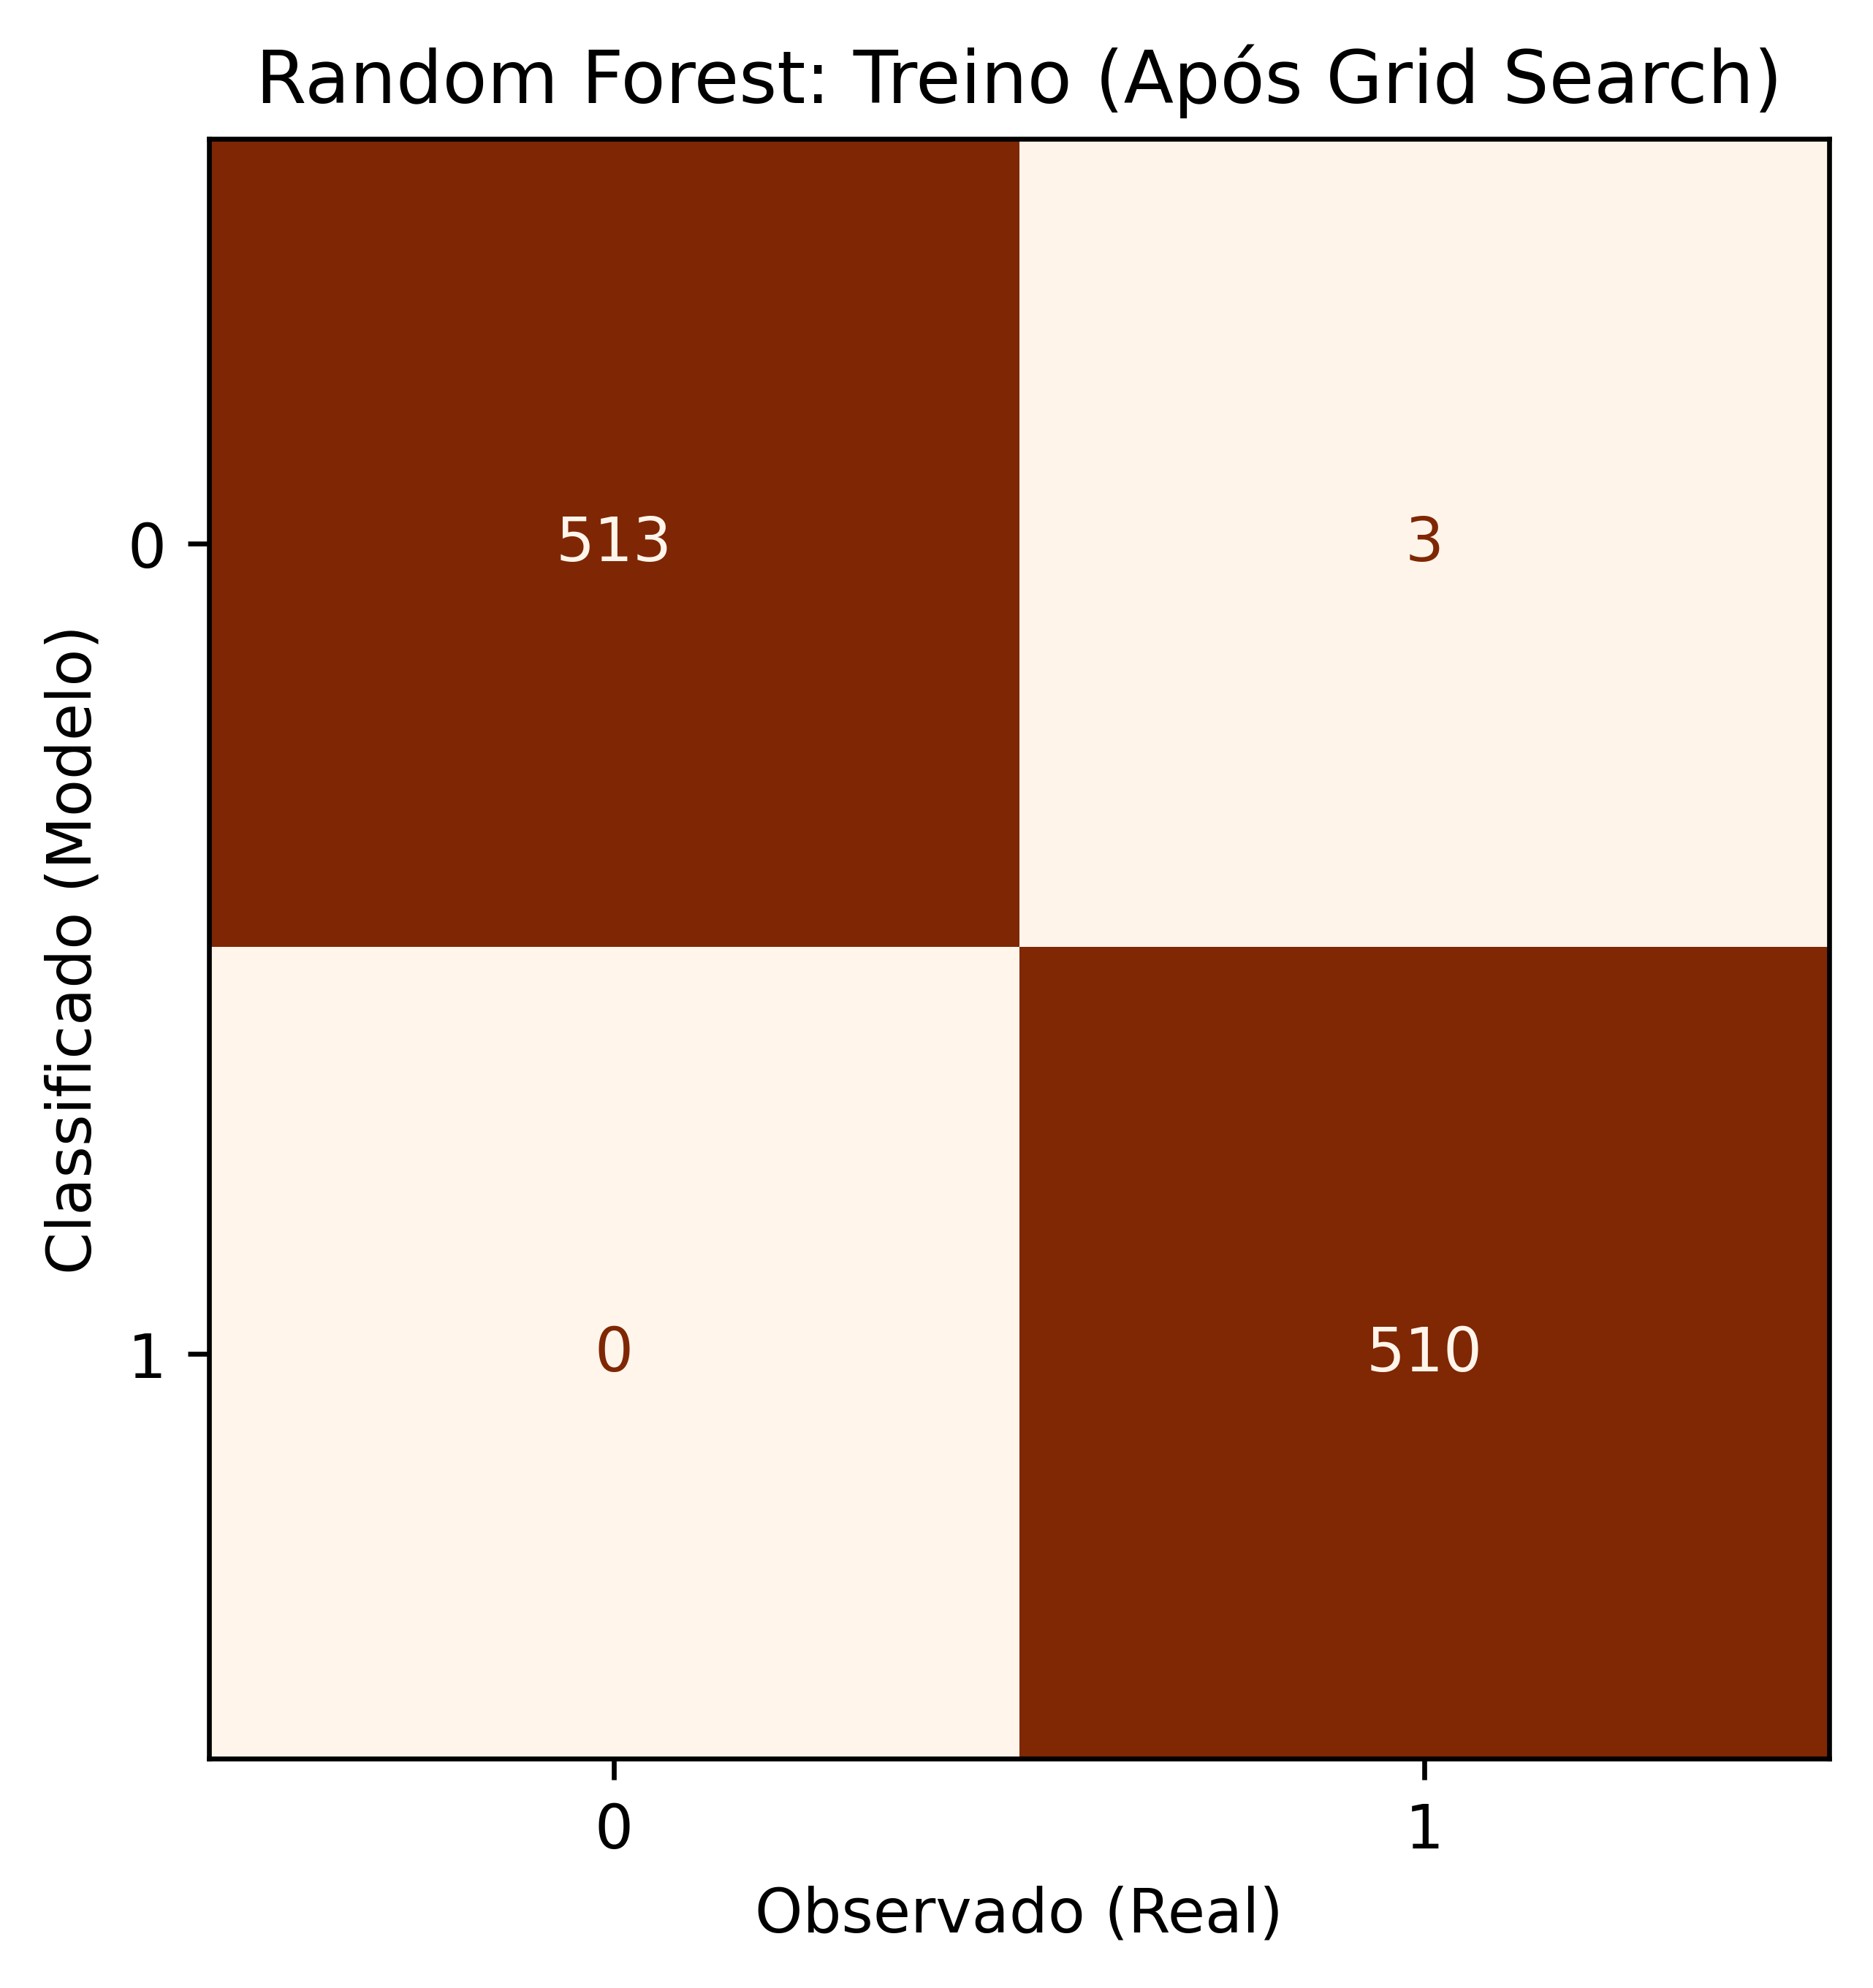

Avaliação da RF Após Grid Search (Base de Treino)
Acurácia: 99.7%
Sensibilidade: 99.4%
Especificidade: 100.0%
Precision: 100.0%


In [82]:
#Matriz de confusão (base de treino)

rf_grid_cm_train = confusion_matrix(rf_grid_pred_train_class, y_train)
cm_rf_grid_train = ConfusionMatrixDisplay(rf_grid_cm_train)

plt.rcParams['figure.dpi'] = 600
cm_rf_grid_train.plot(colorbar=False, cmap='Oranges')
plt.title('Random Forest: Treino (Após Grid Search)')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_rf_grid_train = accuracy_score(y_train, rf_grid_pred_train_class)
sens_rf_grid_train = recall_score(y_train, rf_grid_pred_train_class, pos_label=1)
espec_rf_grid_train = recall_score(y_train, rf_grid_pred_train_class, pos_label=0)
prec_rf_grid_train = precision_score(y_train, rf_grid_pred_train_class)

print("Avaliação da RF Após Grid Search (Base de Treino)")
print(f"Acurácia: {acc_rf_grid_train:.1%}")
print(f"Sensibilidade: {sens_rf_grid_train:.1%}")
print(f"Especificidade: {espec_rf_grid_train:.1%}")
print(f"Precision: {prec_rf_grid_train:.1%}")

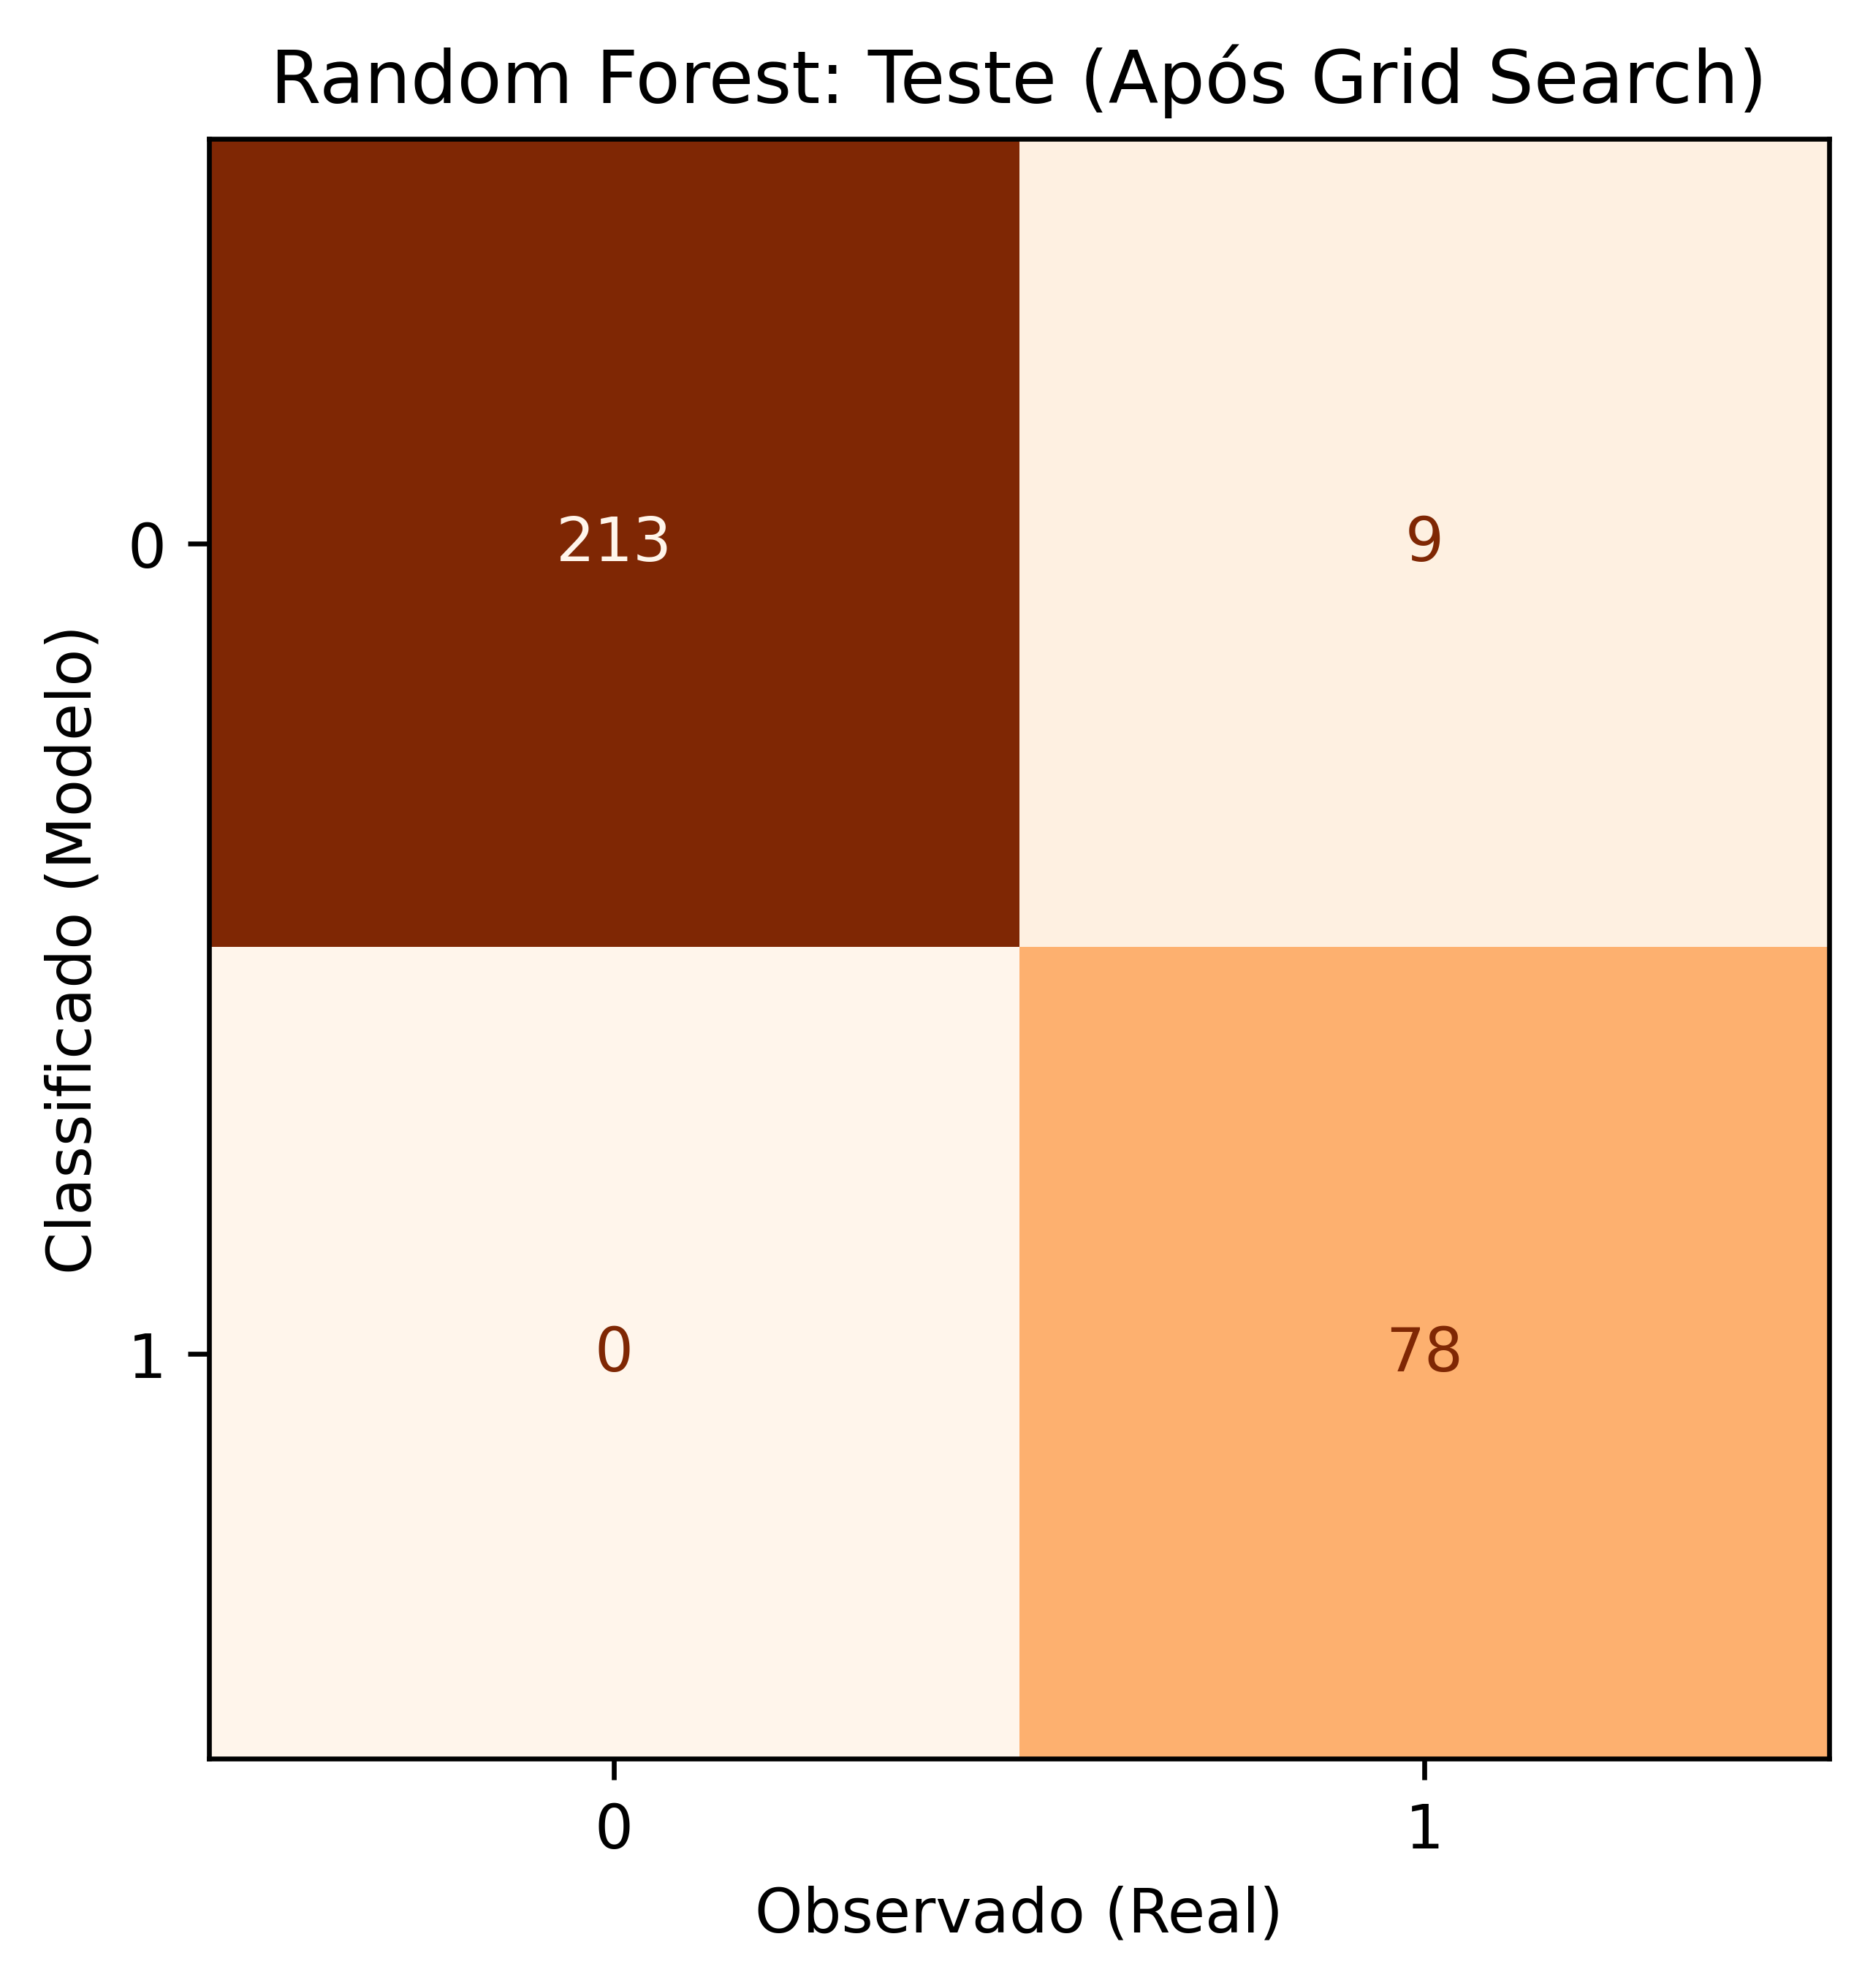

Avaliação da RF Após Grid Search (Base de Teste)
Acurácia: 97.0%
Sensibilidade: 89.7%
Especificidade: 100.0%
Precision: 100.0%


In [83]:
#Matriz de confusão (base de teste)

rf_grid_cm_test = confusion_matrix(rf_grid_pred_test_class, y_test)
cm_rf_grid_test = ConfusionMatrixDisplay(rf_grid_cm_test)

plt.rcParams['figure.dpi'] = 600
cm_rf_grid_test.plot(colorbar=False, cmap='Oranges')
plt.title('Random Forest: Teste (Após Grid Search)')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_rf_grid_test = accuracy_score(y_test, rf_grid_pred_test_class)
sens_rf_grid_test = recall_score(y_test, rf_grid_pred_test_class, pos_label=1)
espec_rf_grid_test = recall_score(y_test, rf_grid_pred_test_class, pos_label=0)
prec_rf_grid_test = precision_score(y_test, rf_grid_pred_test_class)

print("Avaliação da RF Após Grid Search (Base de Teste)")
print(f"Acurácia: {acc_rf_grid_test:.1%}")
print(f"Sensibilidade: {sens_rf_grid_test:.1%}")
print(f"Especificidade: {espec_rf_grid_test:.1%}")
print(f"Precision: {prec_rf_grid_test:.1%}")

In [84]:
#Importância das variáveis preditoras

rf_features = pd.DataFrame({'features':X.columns.tolist(),
                            'importance':rf_best.feature_importances_})

print(rf_features)

                             features  importance
0                               idade    0.012347
1                        renda_mensal    0.105468
2                  tempo_emprego_anos    0.010963
3                       score_credito    0.358182
4                 possui_divida_ativa    0.153693
5                  quantidade_cartoes    0.017127
6                 valor_total_dividas    0.014911
7            utilizacao_limite_cartao    0.289053
8   movimentacao_media_mensal_credito    0.008862
9    movimentacao_media_mensal_debito    0.013561
10                 tipo_conta_salario    0.007818
11           tipo_conta_universitaria    0.008016


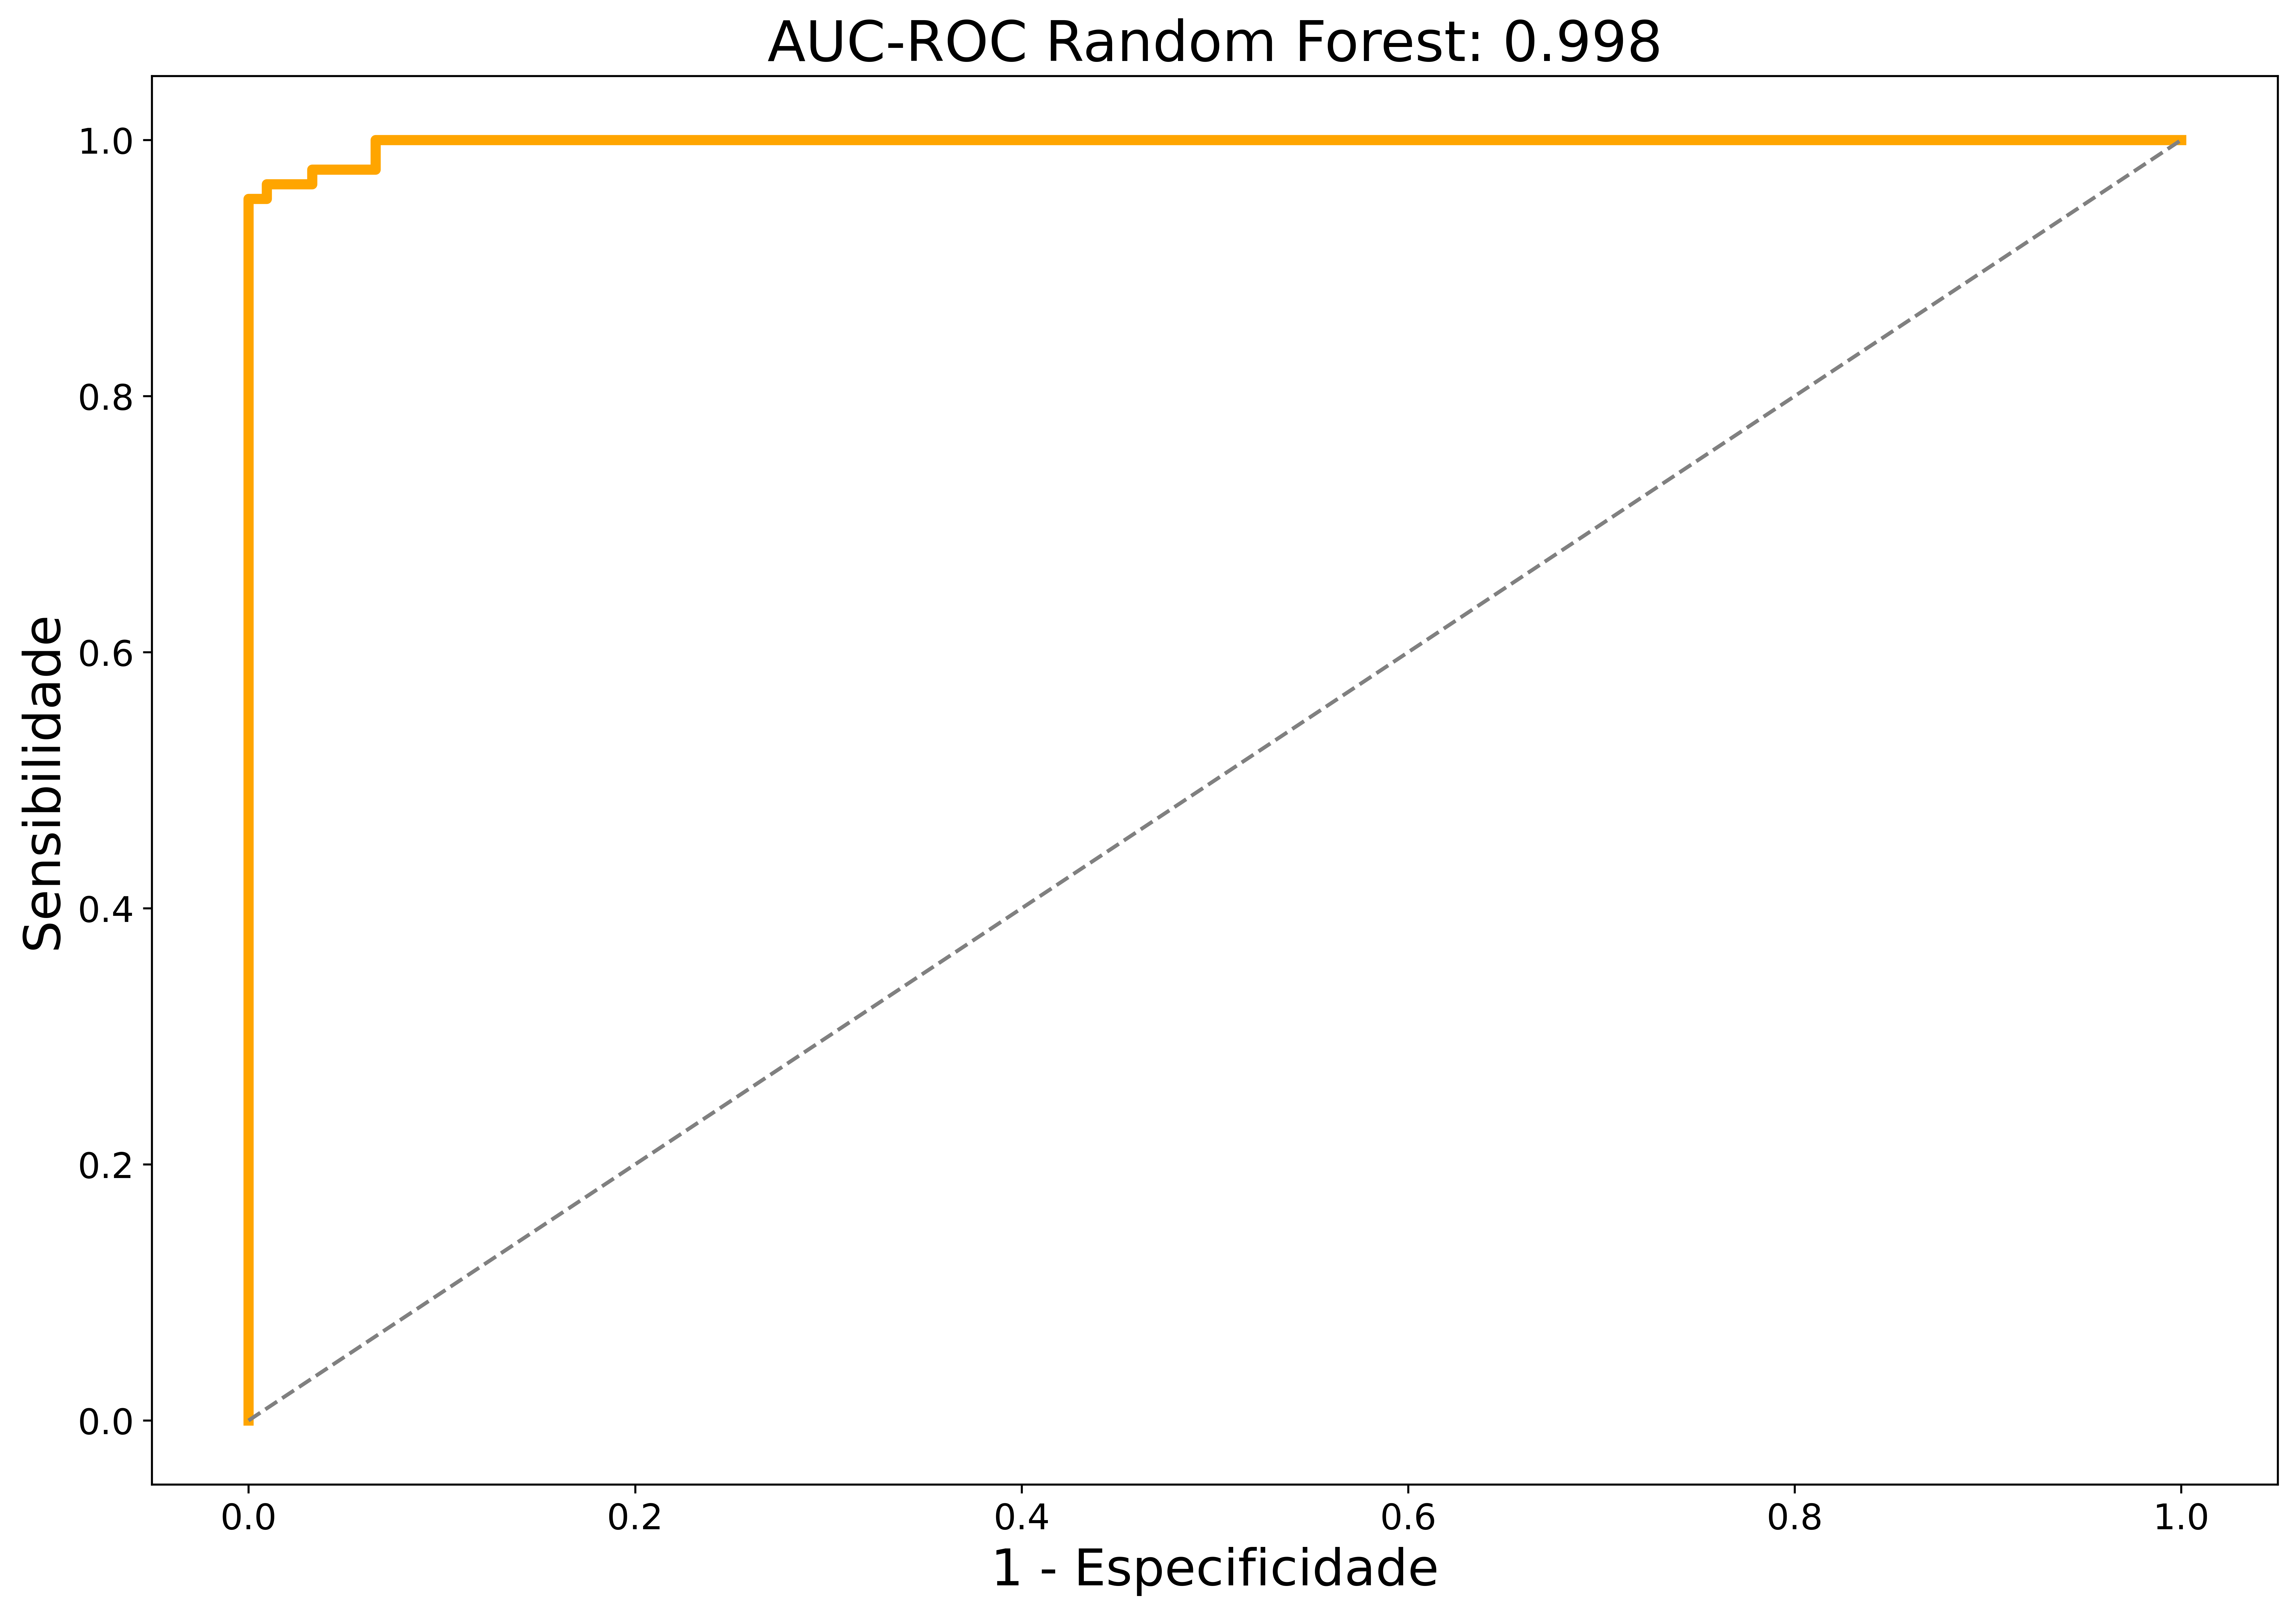

In [85]:
#Curva ROC (base de teste)

# Parametrizando a função da curva ROC (real vs. previsto)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_grid_pred_test_prob[:,1])
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotando a curva ROC
plt.figure(figsize=(15,10), dpi=600)
plt.plot(fpr_rf, tpr_rf, color='Orange', linewidth=4)
plt.plot(fpr_rf, fpr_rf, color='gray', linestyle='dashed')
plt.title('AUC-ROC Random Forest: %g' % round(roc_auc_rf, 3), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensibilidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

In [128]:
#Estimando um XGBoost

xgb_clf = XGBClassifier(n_estimators=50,
                        max_depth=3,
                        colsample_bytree=0.5,
                        learning_rate=0.1,
                        random_state=100)
xgb_clf.fit(X_train, y_train)

# Alguns hiperparâmetros do modelo

# n_estimators: qtde de árvores no modelo
# max_depth: profundidade máxima das árvores
# colsample_bytree: percentual de variáveis X subamostradas para cada árvore
# learning_rate: taxa de aprendizagem

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=100, ...)

In [86]:
#Grid Search

# Especificar a lista de hiperparâmetros
param_grid_xgb = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5],
    'colsample_bytree': [0.5, 1],
    'learning_rate': [0.01, 0.1]
}

# Identificar o algoritmo em uso
xgb_grid = XGBClassifier(random_state=100)

# Treinar os modelos para o grid search
xgb_grid_model = GridSearchCV(estimator = xgb_grid, 
                              param_grid = param_grid_xgb,
                              scoring='accuracy', 
                              cv=5, verbose=2)

xgb_grid_model.fit(X_train, y_train)

# Verificando os melhores parâmetros obtidos
xgb_grid_model.best_params_

# Gerando o modelo com os melhores hiperparâmetros
xgb_best = xgb_grid_model.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=500; total time=   0.3s
[CV] END colsample_bytree=0.5,

In [132]:
#Importância das variáveis preditoras

xgb_features = pd.DataFrame({'features':X.columns.tolist(),
                            'importance':xgb_best.feature_importances_})

print(xgb_features)


                             features  importance
0                               idade    0.006220
1                        renda_mensal    0.108041
2                  tempo_emprego_anos    0.004420
3                       score_credito    0.416597
4                 possui_divida_ativa    0.199329
5                  quantidade_cartoes    0.018478
6                 valor_total_dividas    0.007887
7            utilizacao_limite_cartao    0.202257
8   movimentacao_media_mensal_credito    0.003704
9    movimentacao_media_mensal_debito    0.006170
10                 tipo_conta_salario    0.013030
11           tipo_conta_universitaria    0.013866


In [87]:
#Obtendo os valores preditos pelo XGBoost

# Predict na base de treinamento
xgb_grid_pred_train_class = xgb_best.predict(X_train)
xgb_grid_pred_train_prob = xgb_best.predict_proba(X_train)

# Predict na base de testes
xgb_grid_pred_test_class = xgb_best.predict(X_test)
xgb_grid_pred_test_prob = xgb_best.predict_proba(X_test)

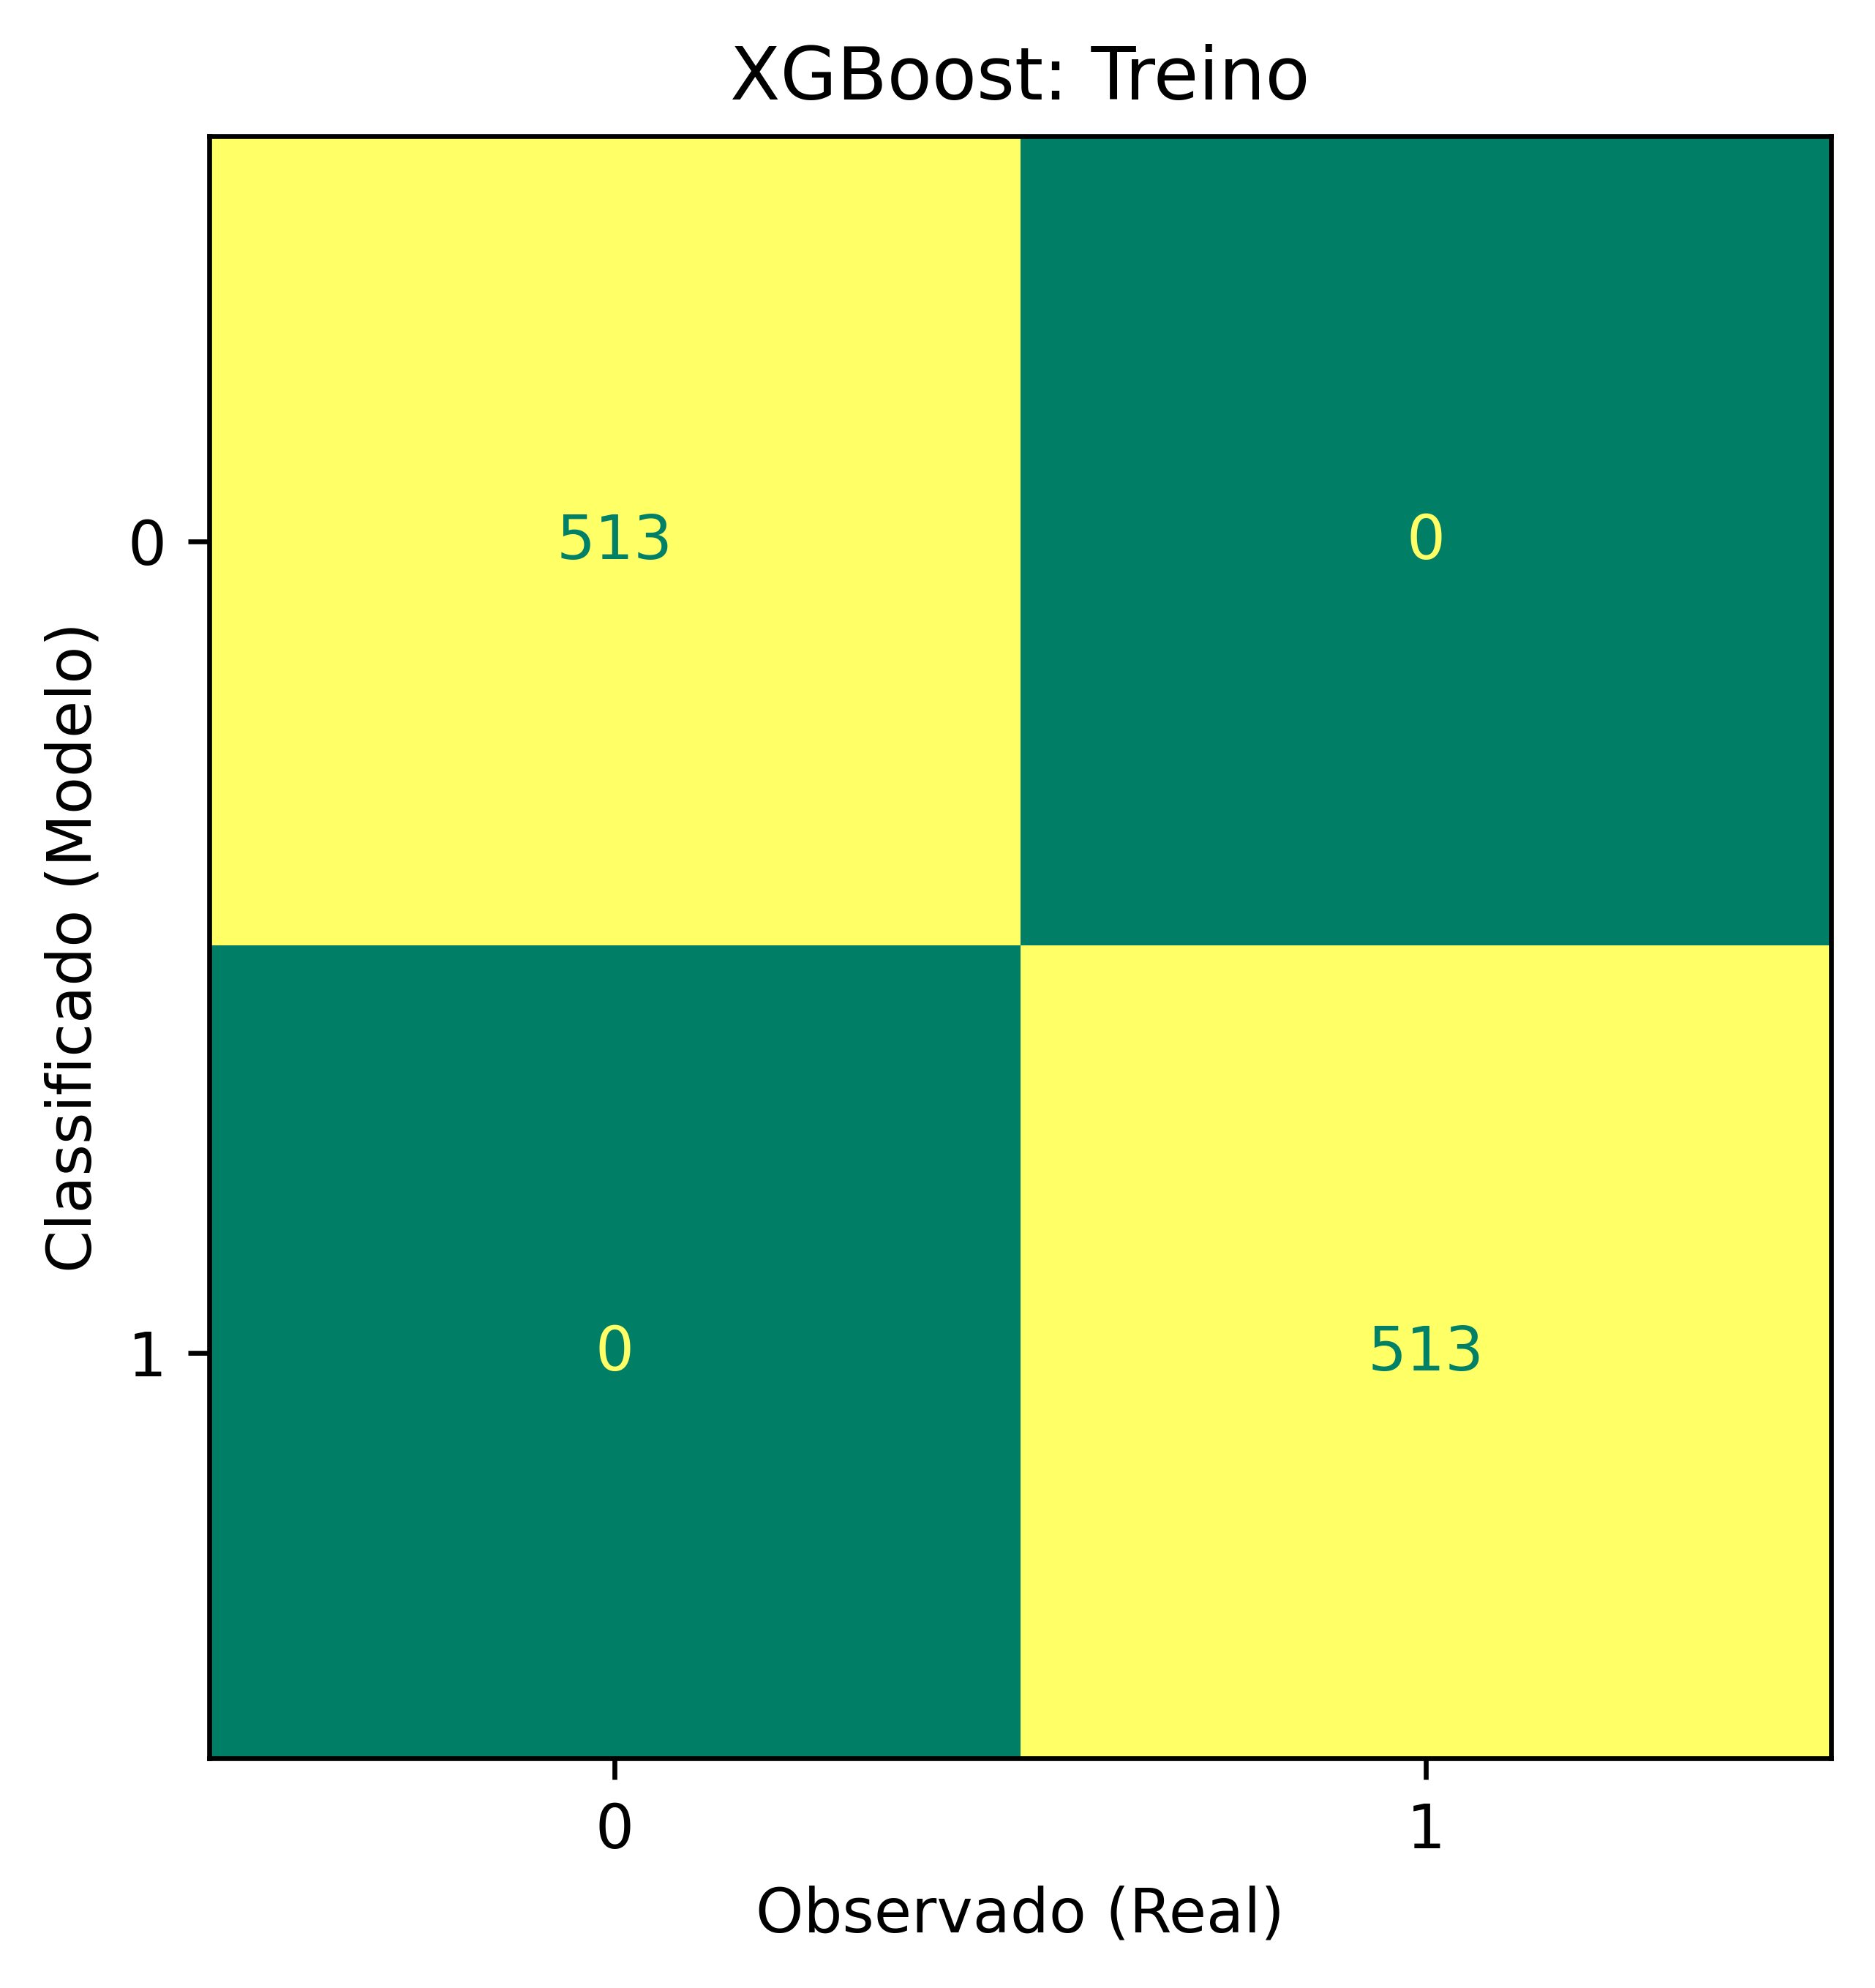

Avaliação do XGBoost (Base de Treino)
Acurácia: 100.0%
Sensibilidade: 100.0%
Especificidade: 100.0%
Precision: 100.0%


In [88]:
#Matriz de confusão (base de treino)

xgb_cm_train = confusion_matrix(xgb_grid_pred_train_class, y_train)
cm_xgb_train = ConfusionMatrixDisplay(xgb_cm_train)

plt.rcParams['figure.dpi'] = 600
cm_xgb_train.plot(colorbar=False, cmap='summer')
plt.title('XGBoost: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_xgb_train = accuracy_score(y_train, xgb_grid_pred_train_class)
sens_xgb_train = recall_score(y_train, xgb_grid_pred_train_class, pos_label=1)
espec_xgb_train = recall_score(y_train, xgb_grid_pred_train_class, pos_label=0)
prec_xgb_train = precision_score(y_train, xgb_grid_pred_train_class)

print("Avaliação do XGBoost (Base de Treino)")
print(f"Acurácia: {acc_xgb_train:.1%}")
print(f"Sensibilidade: {sens_xgb_train:.1%}")
print(f"Especificidade: {espec_xgb_train:.1%}")
print(f"Precision: {prec_xgb_train:.1%}")

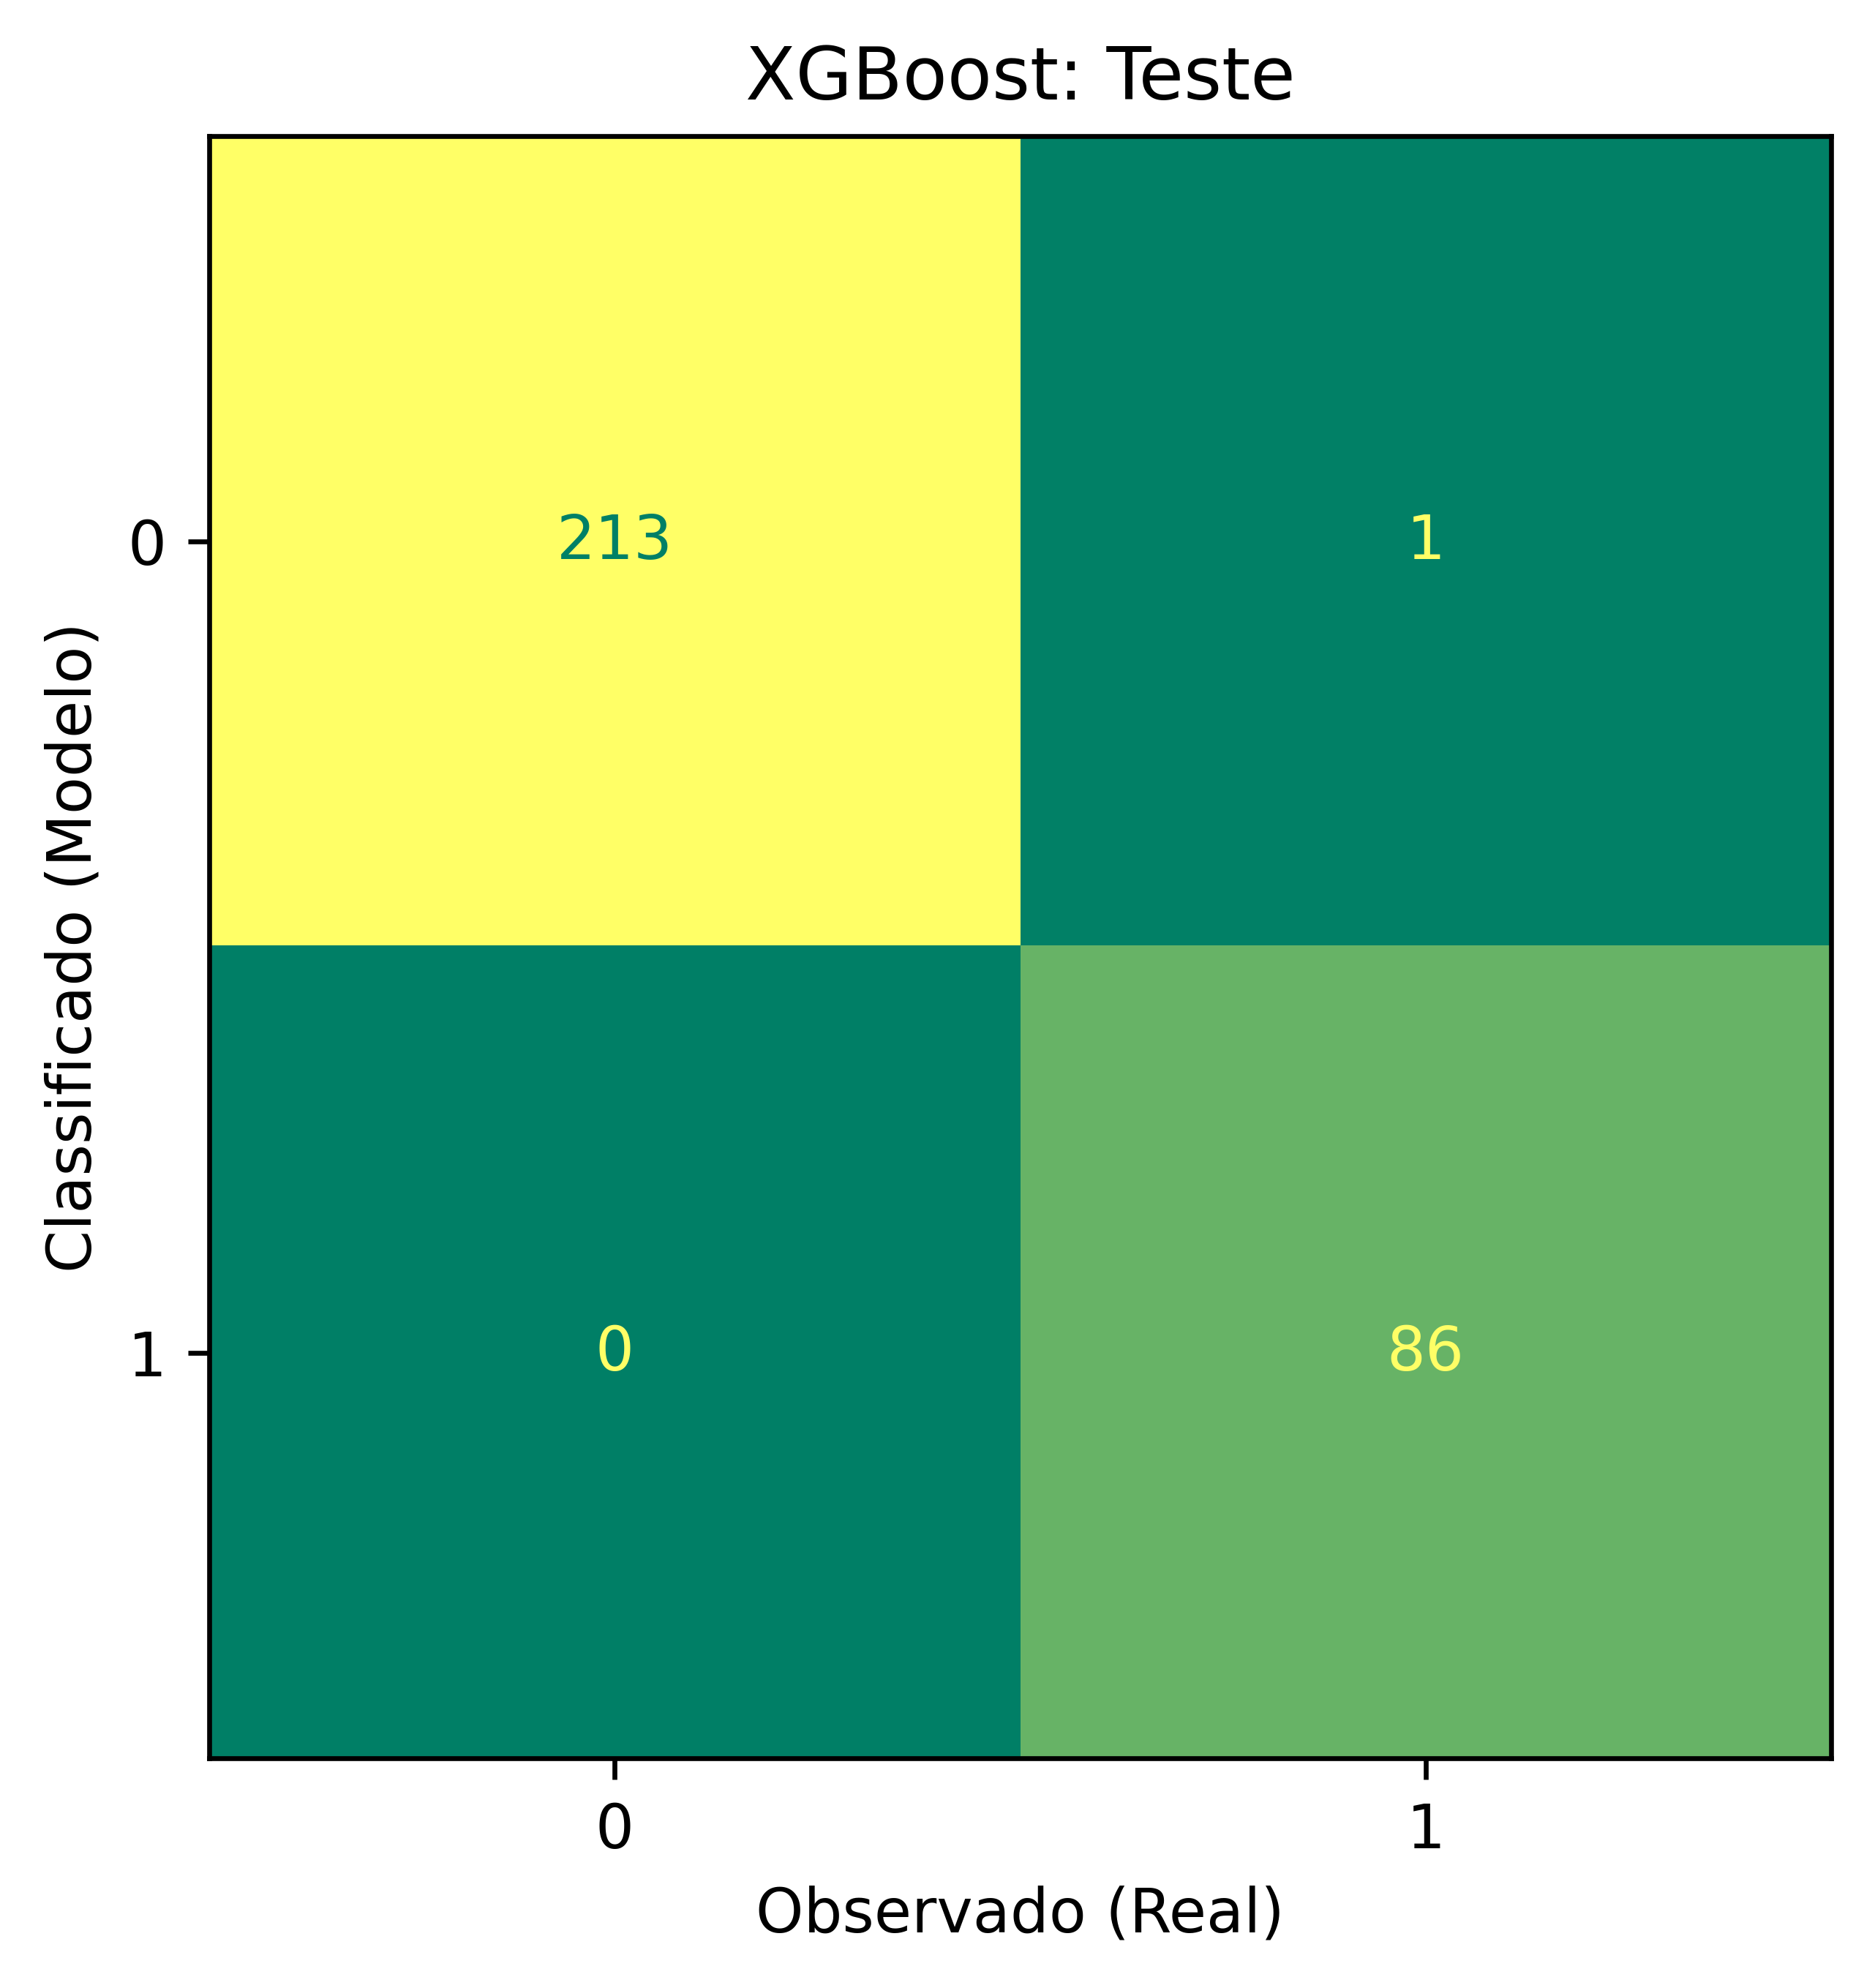

Avaliação do XGBoost (Base de Teste)
Acurácia: 99.7%
Sensibilidade: 98.9%
Especificidade: 100.0%
Precision: 100.0%


In [89]:
#Matriz de confusão (base de teste)

xgb_cm_test = confusion_matrix(xgb_grid_pred_test_class, y_test)
cm_xgb_test = ConfusionMatrixDisplay(xgb_cm_test)

plt.rcParams['figure.dpi'] = 600
cm_xgb_test.plot(colorbar=False, cmap='summer')
plt.title('XGBoost: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

acc_xgb_test = accuracy_score(y_test, xgb_grid_pred_test_class)
sens_xgb_test = recall_score(y_test, xgb_grid_pred_test_class, pos_label=1)
espec_xgb_test = recall_score(y_test, xgb_grid_pred_test_class, pos_label=0)
prec_xgb_test = precision_score(y_test, xgb_grid_pred_test_class)

print("Avaliação do XGBoost (Base de Teste)")
print(f"Acurácia: {acc_xgb_test:.1%}")
print(f"Sensibilidade: {sens_xgb_test:.1%}")
print(f"Especificidade: {espec_xgb_test:.1%}")
print(f"Precision: {prec_xgb_test:.1%}")


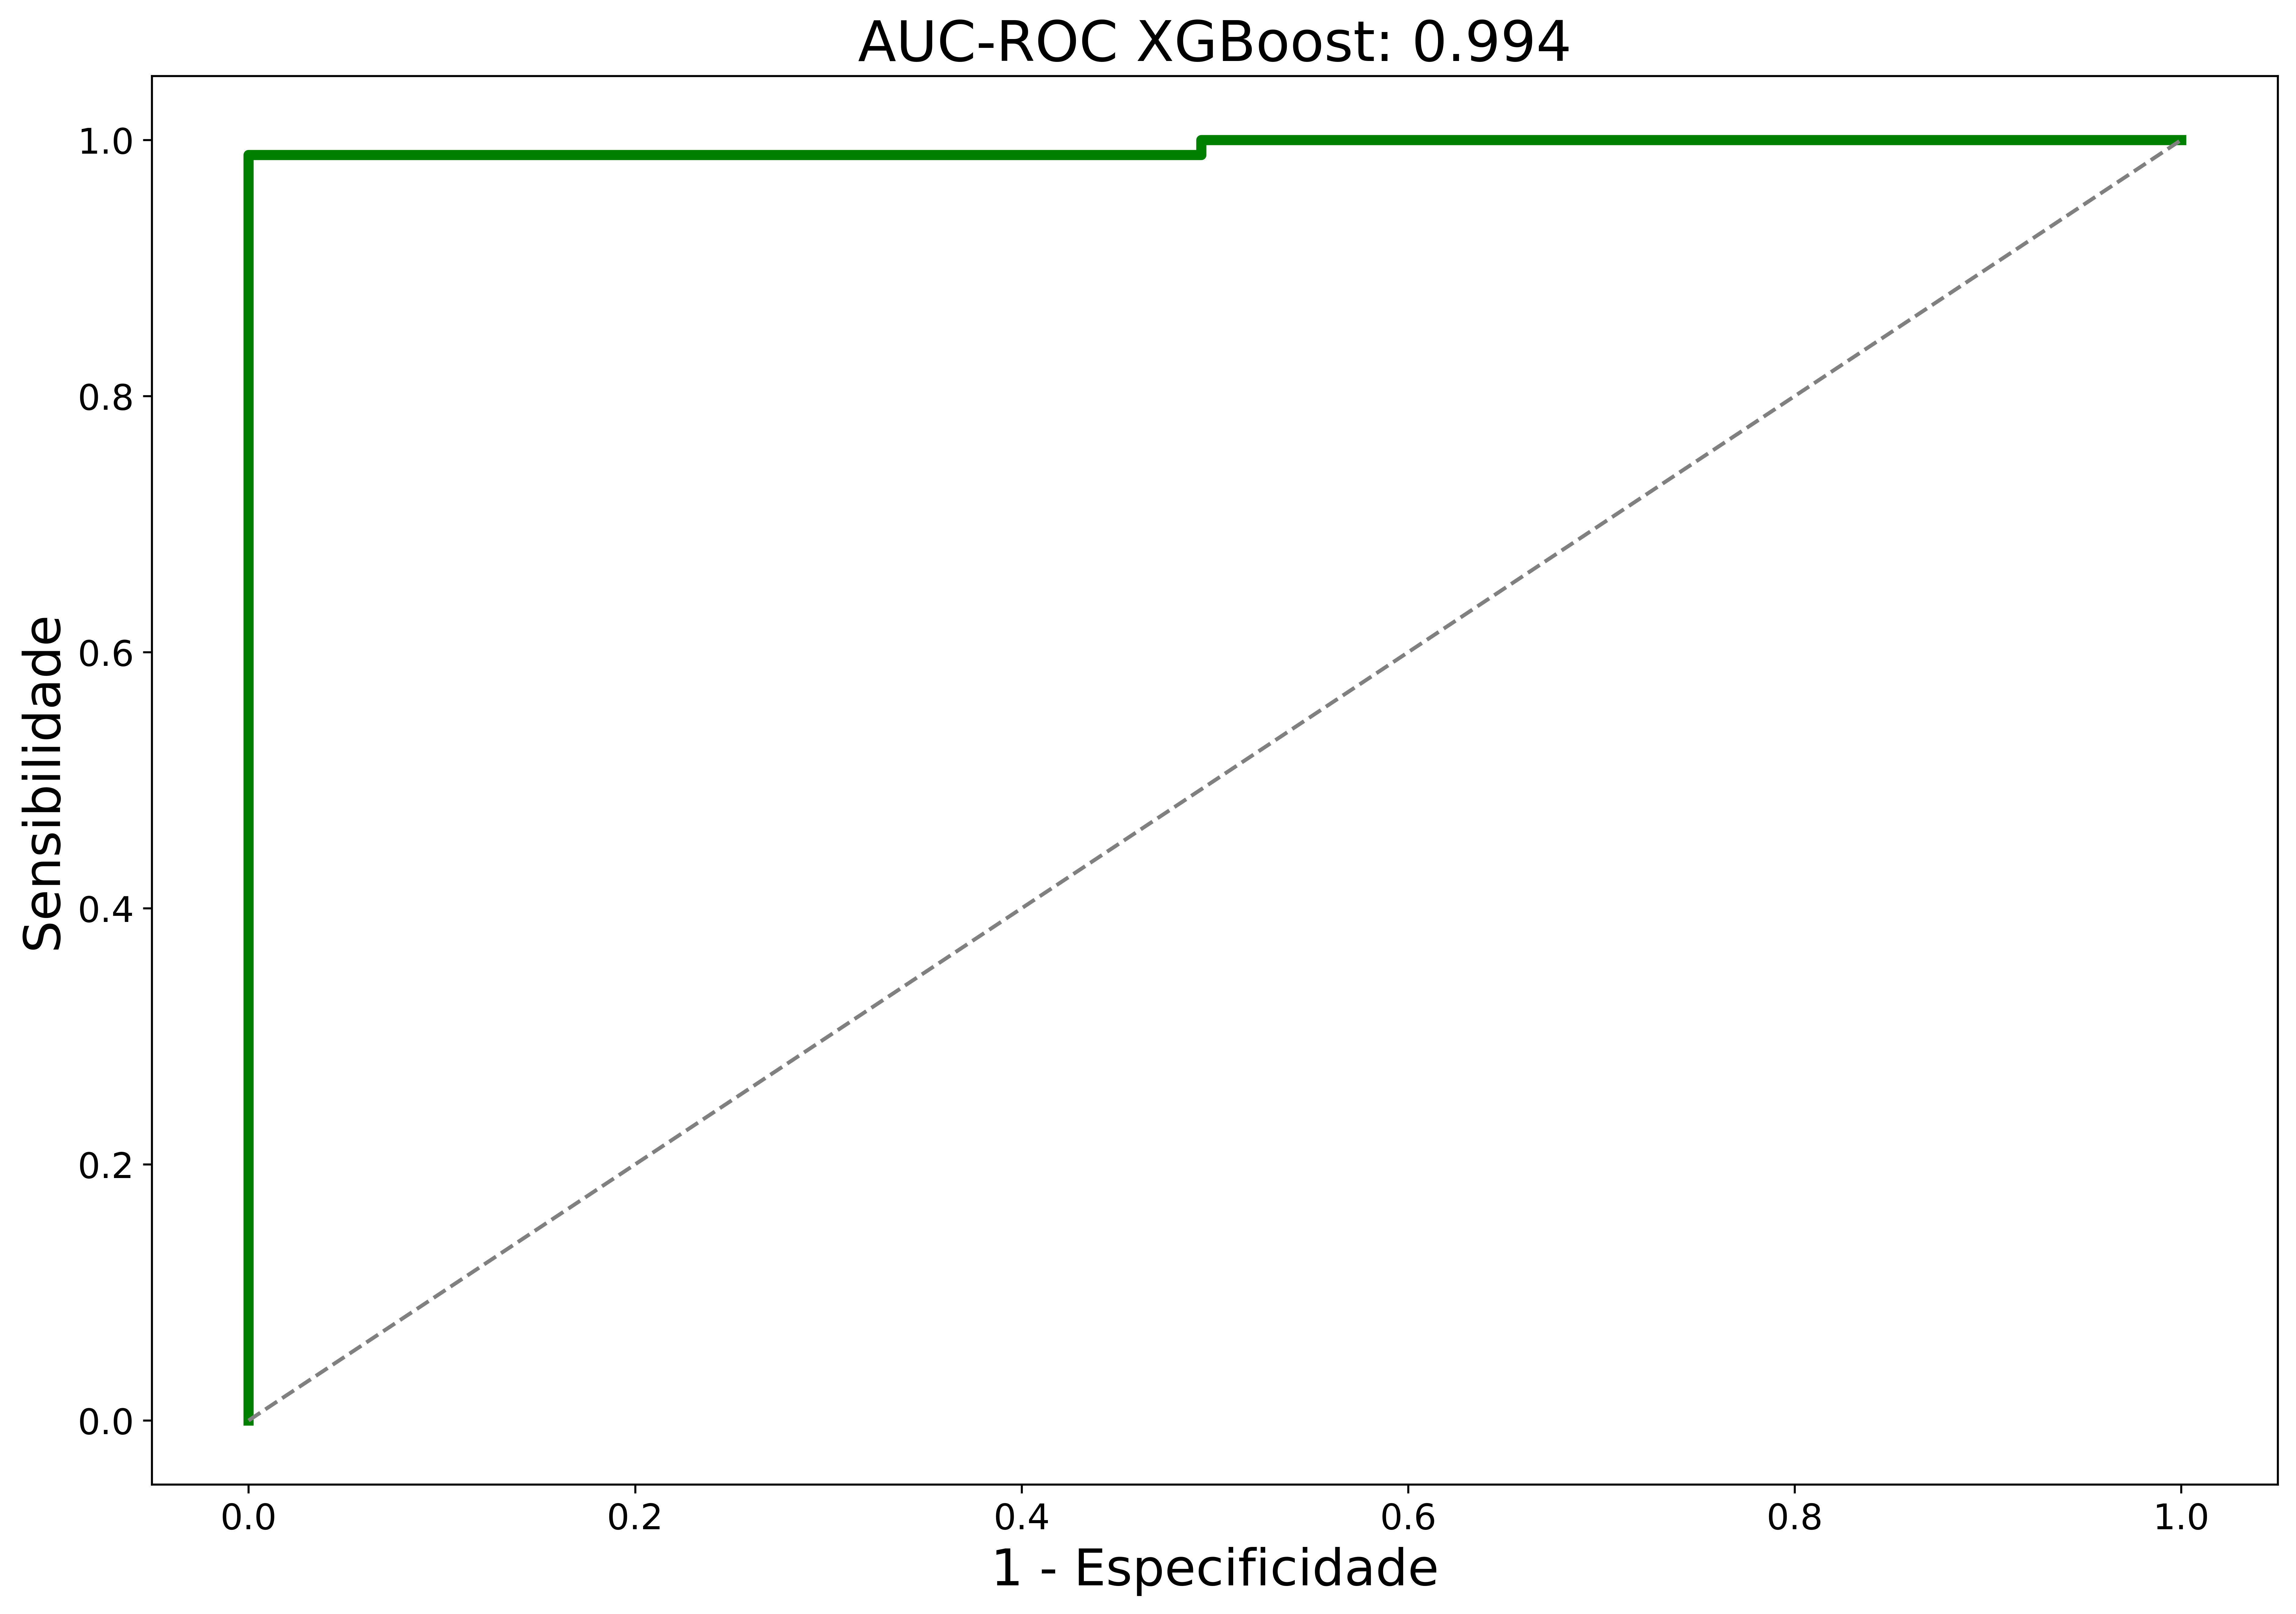

In [90]:
#Curva ROC (base de teste)

# Parametrizando a função da curva ROC (real vs. previsto)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb_grid_pred_test_prob[:,1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotando a curva ROC
plt.figure(figsize=(15,10), dpi=600)
plt.plot(fpr_xgb, tpr_xgb, color='green', linewidth=4)
plt.plot(fpr_xgb, fpr_xgb, color='gray', linestyle='dashed')
plt.title('AUC-ROC XGBoost: %g' % round(roc_auc_xgb, 3), fontsize=22)
plt.xlabel('1 - Especificidade', fontsize=20)
plt.ylabel('Sensibilidade', fontsize=20)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.show()

In [101]:
!pip install scikit-optimize

In [103]:
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
import lightgbm as lgbm

In [105]:
#%% Definir o modelo LightGBM e os hiperparâmetros para otimização
# Criando um classificador base
lgbm_clf = lgbm.LGBMClassifier(boosting_type='gbdt', 
                               objective='binary', 
                               random_state=42)


In [109]:
# Definição do espaço de busca para otimização bayesiana
param_grid = {
    'num_leaves': (20, 60),  # Número de folhas na árvore de decisão
    'max_depth': (3, 15),  # Profundidade máxima da árvore
    'learning_rate': (0.01, 0.3, 'log-uniform'),  # Taxa de aprendizado
    'n_estimators': (50, 100),  # Número de árvores
    'subsample': (0.5, 1.0),  # Proporção de amostras usadas em cada árvore
    'colsample_bytree': (0.5, 1.0),  # Fração de colunas a serem usadas por árvore
    'reg_alpha': (1e-5, 1.0, 'log-uniform'),  # Regularização L1
    'reg_lambda': (1e-5, 1.0, 'log-uniform'),  # Regularização L2
}

In [111]:
#Configurar a busca Bayesiana usando BayesSearchCV

# Criando o otimizador Bayesiano
bayes_search = BayesSearchCV(
    estimator=lgbm_clf,  # Modelo a ser otimizado
    search_spaces=param_grid,  # Espaço de busca definido acima
    scoring='roc_auc',  # Critério de seleção: Área sob a curva ROC (AUC)
    n_iter=10,  # Número de avaliações do modelo
    cv=3,  # Validação cruzada com 5 folds
    random_state=42,
    n_jobs=-1,  # Paralelização total dos cálculos
    verbose=0
)


In [115]:
#Executar a busca Bayesiana
bayes_search.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 513, number of negative: 513
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1834
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

BayesSearchCV(cv=3,
              estimator=LGBMClassifier(objective='binary', random_state=42),
              n_iter=10, n_jobs=-1, random_state=42, scoring='roc_auc',
              search_spaces={'colsample_bytree': (0.5, 1.0),
                             'learning_rate': (0.01, 0.3, 'log-uniform'),
                             'max_depth': (3, 15), 'n_estimators': (50, 100),
                             'num_leaves': (20, 60),
                             'reg_alpha': (1e-05, 1.0, 'log-uniform'),
                             'reg_lambda': (1e-05, 1.0, 'log-uniform'),
                             'subsample': (0.5, 1.0)})

In [119]:
#Resultados da busca
auc = bayes_search.best_score_
gini = auc*2-1
print(f"Melhores hiperparâmetros: {bayes_search.best_params_}")
print(f"\ngini média na validação cruzada: {gini:.2%}")

Melhores hiperparâmetros: OrderedDict({'colsample_bytree': 0.8670140089927842, 'learning_rate': 0.24409731675583402, 'max_depth': 5, 'n_estimators': 59, 'num_leaves': 52, 'reg_alpha': 0.0007292877016846107, 'reg_lambda': 0.0019729794907396908, 'subsample': 0.7673825800605678})

gini média na validação cruzada: 99.44%


In [121]:

#Treinar o modelo final com os melhores hiperparâmetros
final_clf = bayes_search.best_estimator_

#Avaliar no conjunto de teste
bayes_test_score = final_clf.score(X_test, y_test)
bayes_roc = roc_auc_score(y_test, final_clf.predict_proba(X_test)[:,1])
bayes_gini = bayes_roc*2-1
print(f"Acurácia do bayesian search no teste: {bayes_test_score:.4f}")
print(f"Gini do bayesian search no teste: {bayes_gini:.4f}")


Acurácia do bayesian search no teste: 0.9933
Gini do bayesian search no teste: 0.9997


In [123]:
#Avaliação do melhor modelo encontrado

#Melhor conjunto de hiperparâmetros
best_params = bayes_search.best_params_
print("Melhores parâmetros encontrados:", best_params)

# Avaliação no conjunto de teste
best_model = bayes_search.best_estimator_
y_pred = best_model.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC no conjunto de teste: {auc_score:.4f}")


Melhores parâmetros encontrados: OrderedDict({'colsample_bytree': 0.8670140089927842, 'learning_rate': 0.24409731675583402, 'max_depth': 5, 'n_estimators': 59, 'num_leaves': 52, 'reg_alpha': 0.0007292877016846107, 'reg_lambda': 0.0019729794907396908, 'subsample': 0.7673825800605678})
AUC no conjunto de teste: 0.9998


In [173]:
#Obter as previsões do modelo LightGBM na base de TREINO
lgbm_pred_train_class = final_clf.predict(X_train)

#Obter as previsões do modelo LightGBM na base de teste
lgbm_pred_test_class = final_clf.predict(X_test)

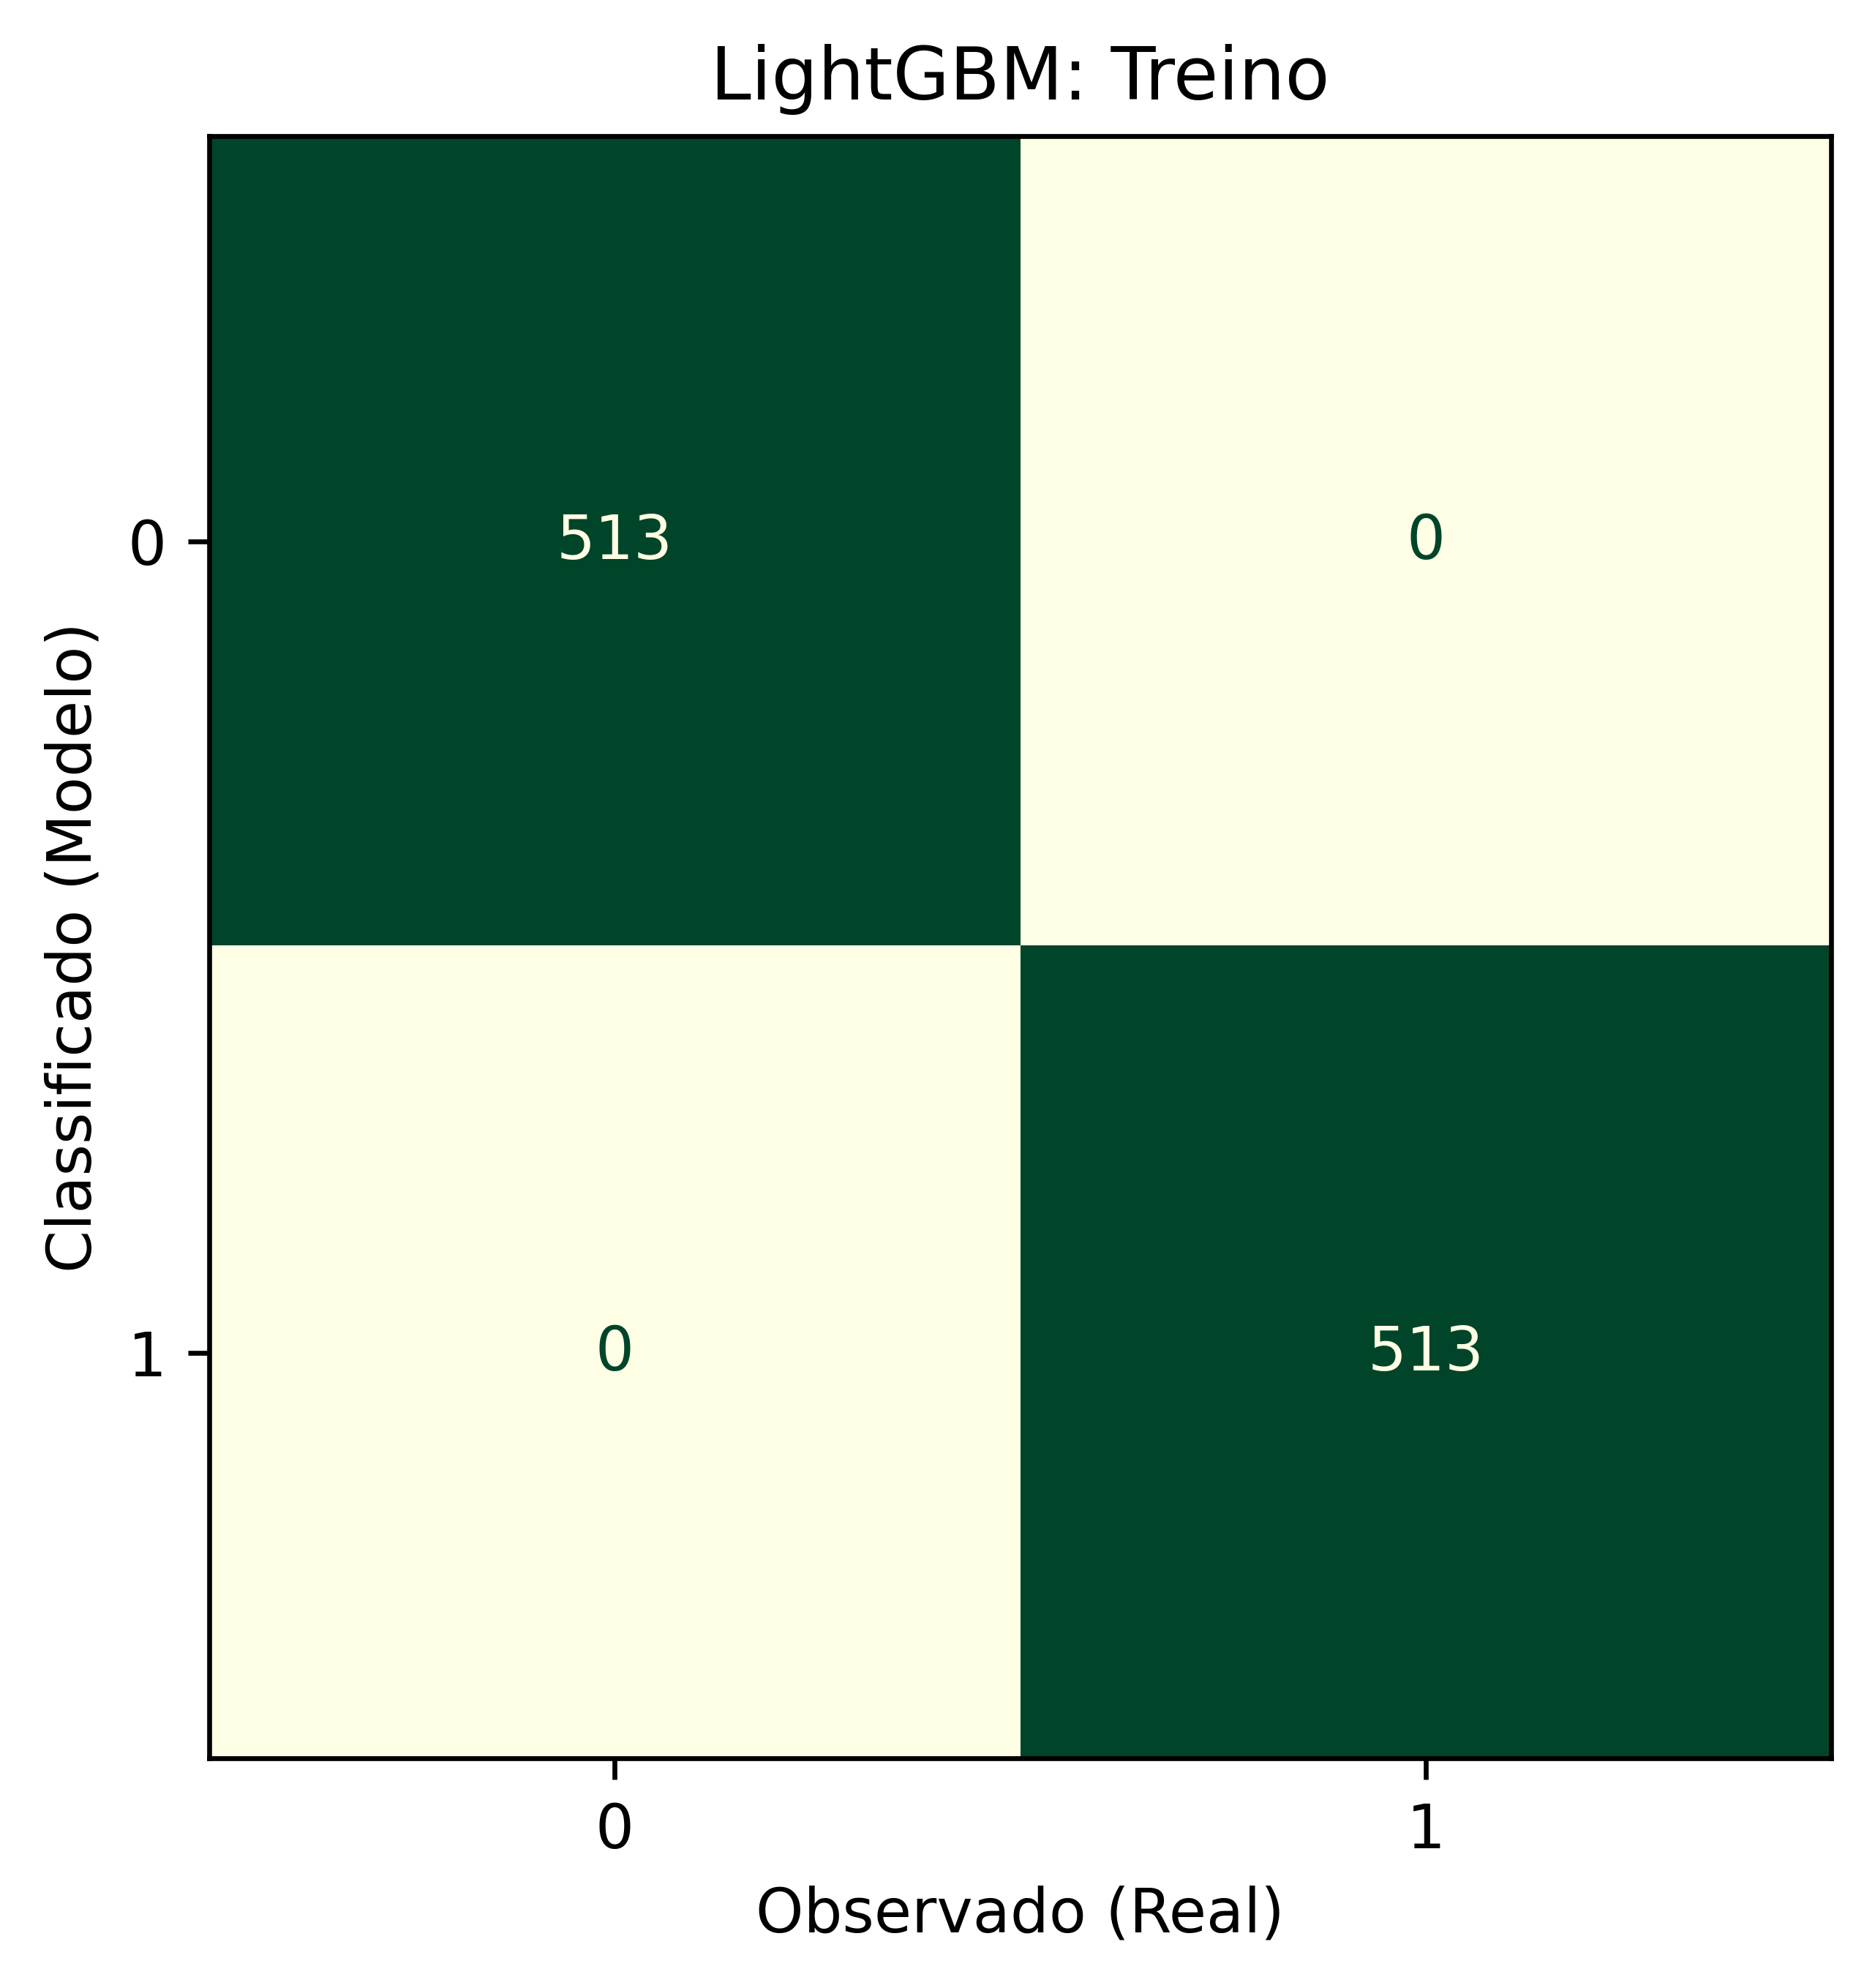


--- Avaliação do LightGBM (Base de Treino) ---
Acurácia: 100.0%
Sensibilidade: 100.0%
Especificidade: 100.0%
Precision: 100.0%


In [175]:
#Plotar a matriz na base de treino

lgbm_cm_train = confusion_matrix(y_train, lgbm_pred_train_class)
cm_lgbm_train = ConfusionMatrixDisplay(lgbm_cm_train)

plt.rcParams['figure.dpi'] = 600
cm_lgbm_train.plot(colorbar=False, cmap='YlGn')
plt.title('LightGBM: Treino')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

# 5. Calcular as métricas de avaliação para a base de treino
acc_lgbm_train = accuracy_score(y_train, lgbm_pred_train_class)
sens_lgbm_train = recall_score(y_train, lgbm_pred_train_class, pos_label=1)
espec_lgbm_train = recall_score(y_train, lgbm_pred_train_class, pos_label=0)
prec_lgbm_train = precision_score(y_train, lgbm_pred_train_class)

# 6. Imprimir os resultados para a base de treino
print("\n--- Avaliação do LightGBM (Base de Treino) ---")
print(f"Acurácia: {acc_lgbm_train:.1%}")
print(f"Sensibilidade: {sens_lgbm_train:.1%}")
print(f"Especificidade: {espec_lgbm_train:.1%}")
print(f"Precision: {prec_lgbm_train:.1%}")

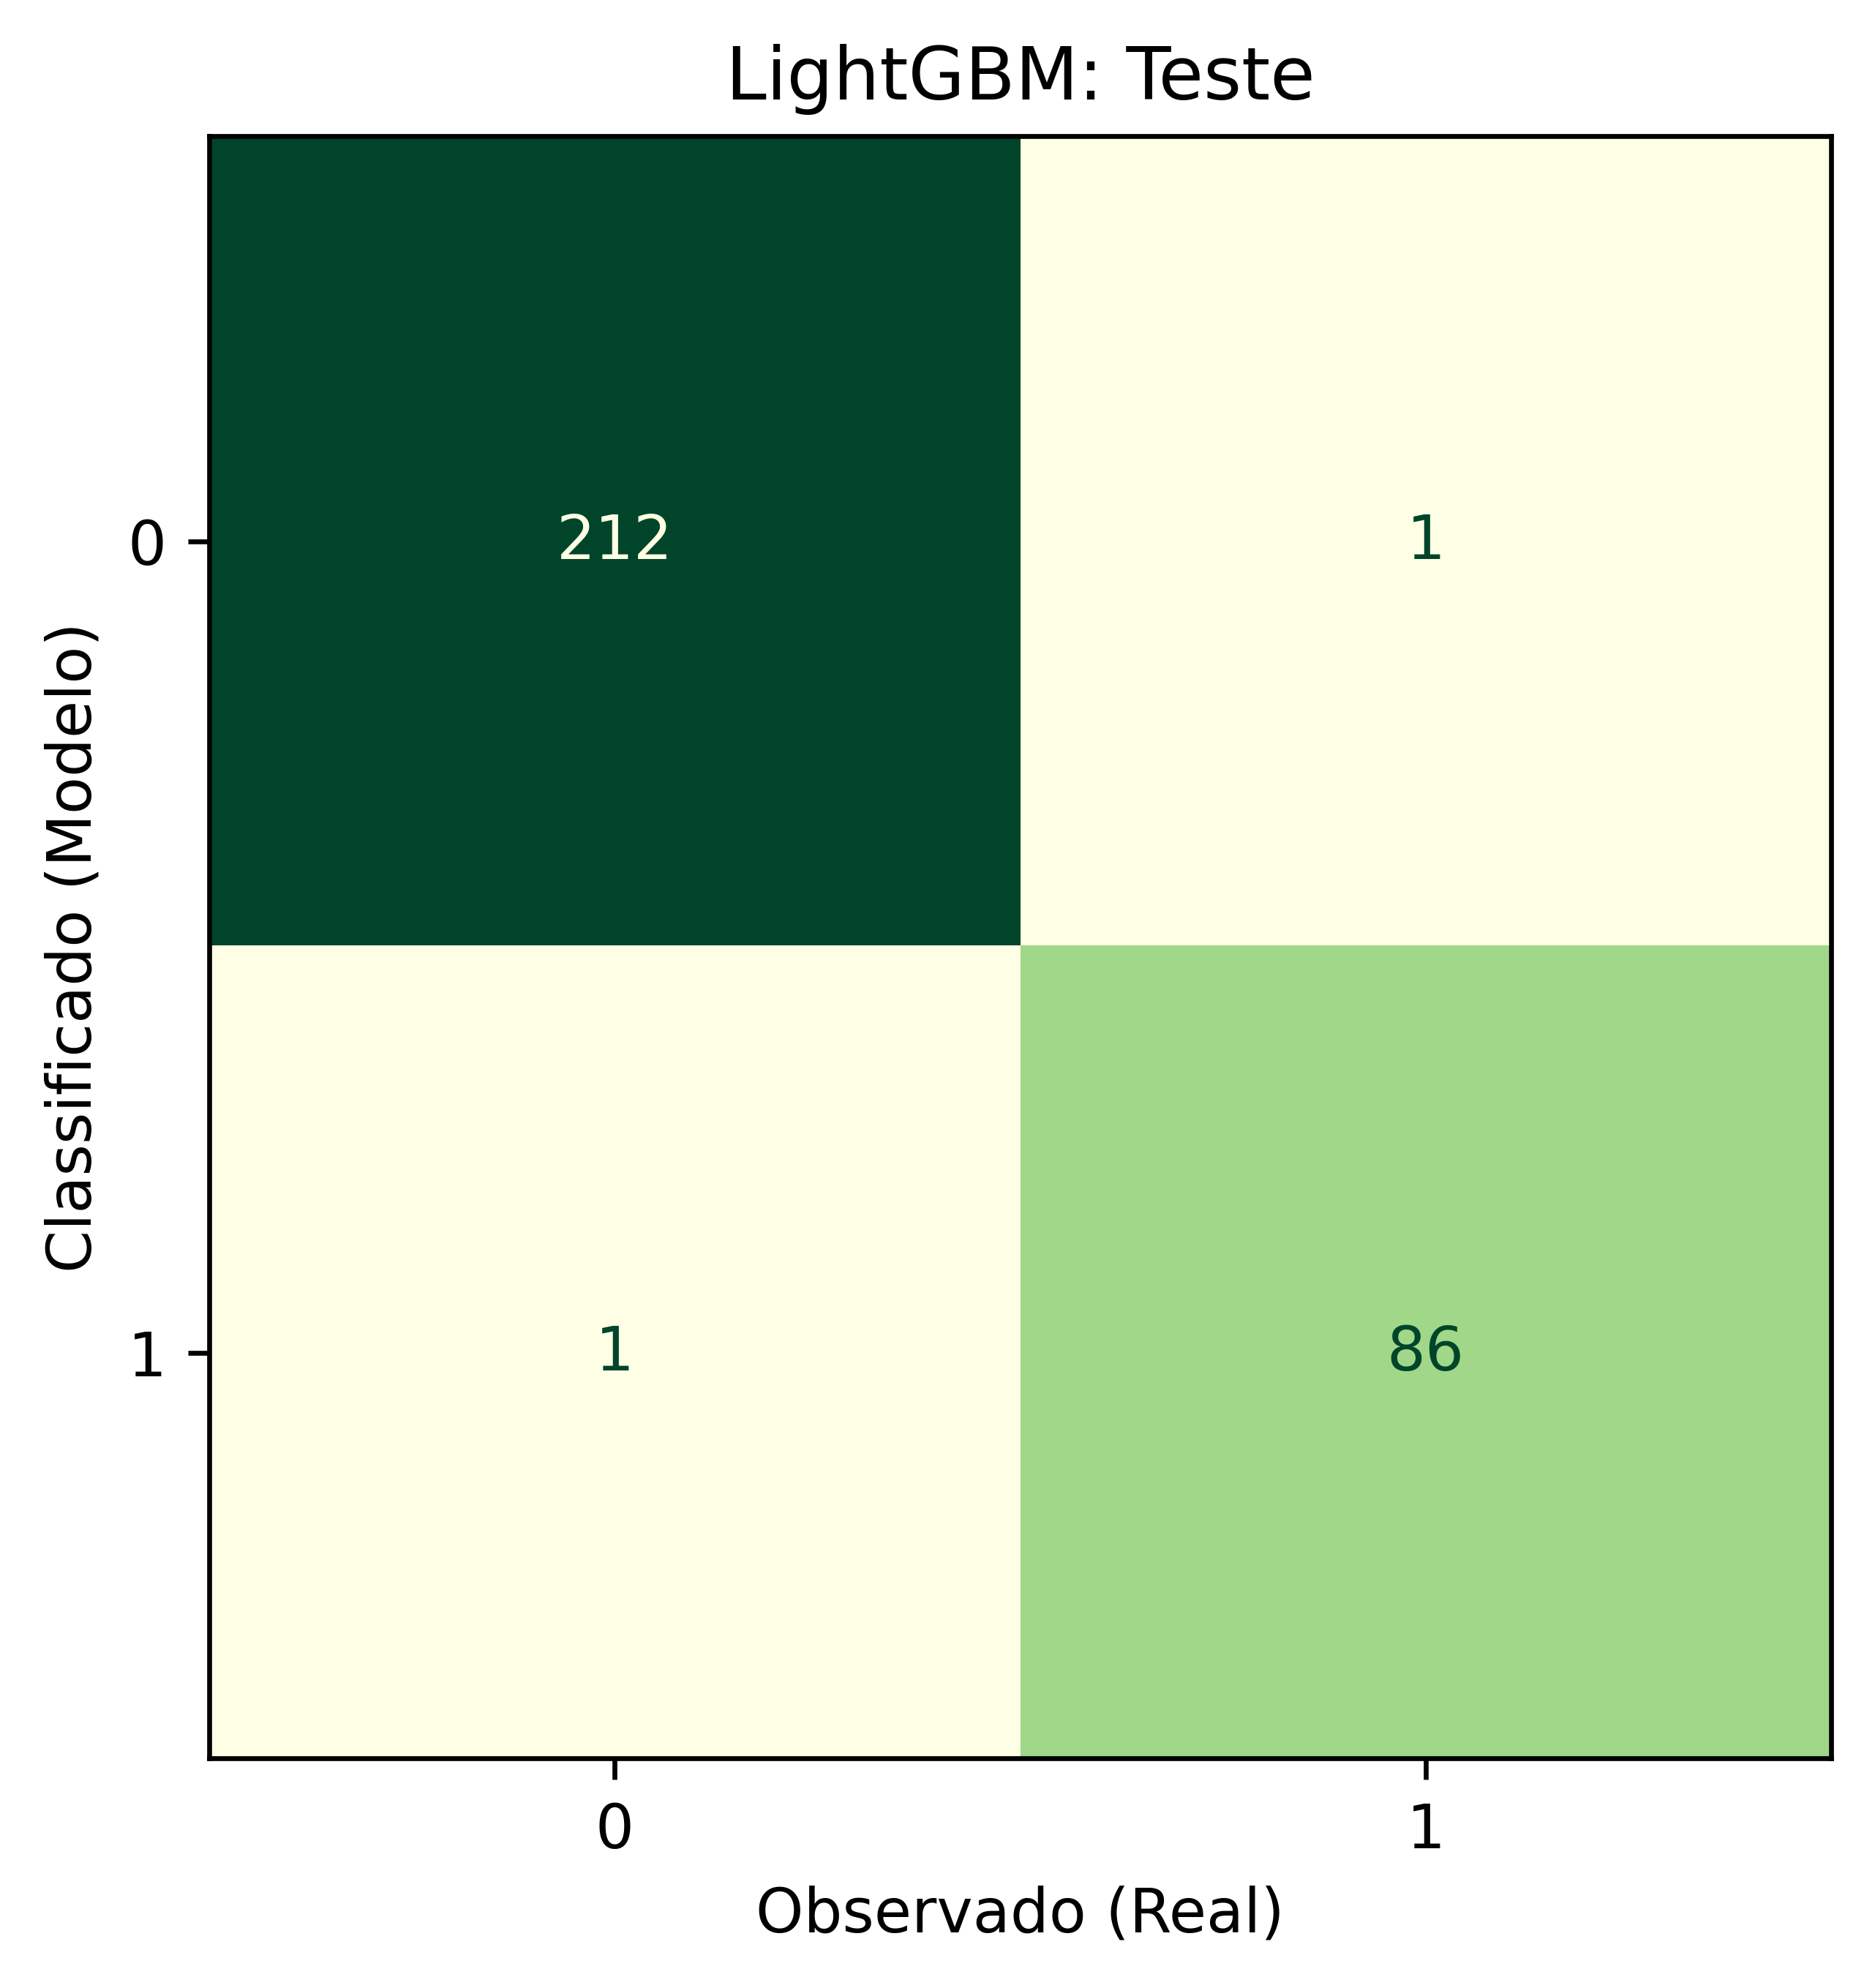

Avaliação do LightGBM (Base de Teste)
Acurácia: 99.3%
Sensibilidade: 98.9%
Especificidade: 99.5%
Precision: 98.9%


In [177]:
# Plotar a matriz com base de treino
lgbm_cm_test = confusion_matrix(y_test, lgbm_pred_test_class)
cm_lgbm_test = ConfusionMatrixDisplay(lgbm_cm_test)

plt.rcParams['figure.dpi'] = 600
cm_lgbm_test.plot(colorbar=False, cmap='YlGn')
plt.title('LightGBM: Teste')
plt.xlabel('Observado (Real)')
plt.ylabel('Classificado (Modelo)')
plt.show()

#Calcular as métricas de avaliação
acc_lgbm_test = accuracy_score(y_test, lgbm_pred_test_class)
sens_lgbm_test = recall_score(y_test, lgbm_pred_test_class, pos_label=1)
espec_lgbm_test = recall_score(y_test, lgbm_pred_test_class, pos_label=0)
prec_lgbm_test = precision_score(y_test, lgbm_pred_test_class)

#Imprimir os resultados
print("Avaliação do LightGBM (Base de Teste)")
print(f"Acurácia: {acc_lgbm_test:.1%}")
print(f"Sensibilidade: {sens_lgbm_test:.1%}")
print(f"Especificidade: {espec_lgbm_test:.1%}")
print(f"Precision: {prec_lgbm_test:.1%}")

In [127]:
nova_analise = pd.DataFrame({'idade': [42],
                             'renda_mensal': [8536],
                             'tempo_emprego_anos': [7],
                             'score_credito': [502],
                             'possui_divida_ativa': [0],
                             'quantidade_cartoes': [2],
                             'valor_total_dividas': [1602],
                             'utilizacao_limite_cartao': [0.25],
                             'movimentacao_media_mensal_credito': [10456],
                             'movimentacao_media_mensal_debito': [11012],
                             'tipo_conta_salario': [1],
                             'tipo_conta_universitaria': [0]})

In [129]:
nova_analise

idade  renda_mensal  tempo_emprego_anos  score_credito  \
0     42          8536                   7            502   

   possui_divida_ativa  quantidade_cartoes  valor_total_dividas  \
0                    0                   2                 1602   

   utilizacao_limite_cartao  movimentacao_media_mensal_credito  \
0                      0.25                              10456   

   movimentacao_media_mensal_debito  tipo_conta_salario  \
0                             11012                   1   

   tipo_conta_universitaria  
0                         0

In [147]:
np.set_printoptions(suppress=True, precision=5)

In [149]:
cliente_tree = tree_clf_aj.predict_proba(nova_analise)
cliente_rf = rf_best.predict_proba(nova_analise)
cliente_xgb = xgb_best.predict_proba(nova_analise)
cliente_GBM = final_clf.predict_proba(nova_analise)

In [133]:
cliente_tree

array([[1., 0.]])

In [135]:
cliente_rf

array([[0.72542955, 0.27457045]])

In [137]:
cliente_xgb 

array([[0.90509, 0.09491]], dtype=float32)

In [179]:
cliente_GBM

array([[0.99997, 0.00003]])